In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

import tensorflow as tf
from tensorflow.keras import models, layers, activations, initializers, metrics, utils, losses, optimizers

import seaborn as sns
from sklearn import model_selection

In [2]:
# # colab on google drive 

# from google.colab import drive
# drive.mount('/content/drive')

# %cd '/content/drive/MyDrive/groom/semi-3/fifa_pay_prediction/03_work_code/ukseongchoi'

In [3]:
train = pd.read_csv("../../00_original_data/FIFA_train.csv")
test = pd.read_csv("../../00_original_data/FIFA_test.csv")

submission = pd.read_csv("../../00_original_data/submission.csv")


### 데이터전처리

In [4]:
# 필요하지 않는 feature 값 제거
train.drop(['id', 'name'], axis = 1, inplace = True)
test.drop(['id', 'name'], axis = 1, inplace = True)

In [5]:
# 학습 데이터(x data)와 타겟 데이터(y data)로 나누기

y_train = train['value'] # 타겟 데이터
x_train = train.copy() # 학습 데이터

#타겟 생성 후 필요없는 열제거
del x_train['value']

In [6]:
# 카테고리 값 확인
print(x_train['continent'].unique())
print(x_train['position'].unique())
print(x_train['prefer_foot'].unique())

['south america' 'europe' 'africa' 'asia' 'oceania']
['ST' 'GK' 'DF' 'MF']
['left' 'right']


In [7]:
# categorical data를 담고있는 Series는 특수 메서드인 cat 속성이 있다.
# 이를 통해 catagories 와 codes 나 categorical 메서드 등에 쉽게 접근할 수 있다.
# 하지만 시리즈에 바로 categories나 codes를 사용하면 에러가 발생하는데 이때 이용하는 것이 cat 속성이다.

x_train['continent']=x_train['continent'].astype('category').cat.codes
test['continent'] = test['continent'].astype('category').cat.codes

x_train['position'] = x_train['position'].astype('category').cat.codes
test['position'] = test['position'].astype('category').cat.codes

x_train['prefer_foot'] = x_train['prefer_foot'].astype('category').cat.codes
test['prefer_foot'] = test['prefer_foot'].astype('category').cat.codes

In [8]:
# 계약 연도에 월, 일 값이 붙어 있는 데이터를 전처리한 뒤,
# 계약 연도에서 object -> int 로 변환
def func(string:object) -> int:
    string = string[-4:] # 계약연도가 제일 끝에 있거나 단독으로 쓰이고 있어 뒤에서 4번째부터 가지고 옴.
    return int(string)

x_train['contract_until'] = x_train['contract_until'].apply(func)
test['contract_until'] = test['contract_until'].apply(func)

In [9]:
new_train_future = pd.DataFrame(x_train['age'] * x_train['stat_overall'] * x_train['stat_potential'],columns=['inner_product'])
new_test_future = pd.DataFrame(test['age'] * test['stat_overall'] * test['stat_potential'],columns=['inner_product'])

In [10]:
x_train = pd.concat([x_train,new_train_future],axis = 1)
test = pd.concat([test,new_test_future],axis = 1)

In [11]:
# x train 확인
x_train

,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,inner_product
0,31,4,2021,3,0,5.0,94,94,4.0,273916
1,27,2,2020,1,1,4.0,91,93,1.0,228501
2,31,4,2021,3,1,5.0,91,91,3.0,256711
3,32,2,2020,0,1,4.0,91,91,3.0,264992
4,25,2,2021,1,1,3.0,90,93,1.0,209250
...,...,...,...,...,...,...,...,...,...,...
8927,18,0,2019,2,1,1.0,48,63,3.0,54432
8928,19,2,2020,0,1,1.0,47,59,2.0,52687
8929,18,4,2021,0,1,1.0,47,64,2.0,54144
8930,18,2,2021,1,1,1.0,47,65,1.0,54990


In [12]:
# 조합찾기 

from itertools import combinations 

arr = ['reputation' , 'stat_skill_moves']
categorics = []
for i in range(len(arr)+1):
    categorics = categorics + list(combinations(arr,i))

for k in range(len(categorics)):
    categorics[k] = list(categorics[k])

numerics = []
for i in range(len(categorics)):
    remove_set = list(categorics[i])
    numerics.append([i for i in arr if i not in remove_set])

categorical_base = ['continent', 'position']
numerical_base = ['stat_overall', 'stat_potential','contract_until', 'age','inner_product']

for k in range(len(categorics)):
    
    categorics[k] = categorical_base + categorics[k]
    numerics[k] = numerical_base + numerics[k]

In [13]:
categorics

[['continent', 'position'],
 ['continent', 'position', 'reputation'],
 ['continent', 'position', 'stat_skill_moves'],
 ['continent', 'position', 'reputation', 'stat_skill_moves']]

In [14]:
# 찾은 조합을 통한 Dataframe list
new_df = x_train.copy()
pd_list = []
for j in range(len(categorics)):
  new_df = x_train.copy()

  for categori_name in categorics[j]:


    num = len(new_df[categori_name].unique())
    make_name =[]
    for i in range(num):
      
      make_name.append(categori_name + str(i))

    en_df = pd.get_dummies(new_df[categori_name])

    en_df.columns = make_name


    del new_df[categori_name]

    new_df = pd.concat([new_df , en_df], axis=1 )

  pd_list.append(new_df)

In [15]:
# 확인

a='''
카테고리로 해석할 열들에 대한 info 입니다.
pd_list[0] == {}
pd_list[1] == {}
pd_list[2] == {}
pd_list[3] == {}
'''.format(categorics[0],categorics[1],categorics[2],categorics[3])


print(a)


카테고리로 해석할 열들에 대한 info 입니다.
pd_list[0] == ['continent', 'position']
pd_list[1] == ['continent', 'position', 'reputation']
pd_list[2] == ['continent', 'position', 'stat_skill_moves']
pd_list[3] == ['continent', 'position', 'reputation', 'stat_skill_moves']



In [16]:
# for i in range(4):
#     del pd_list[0]['prefer_foot']
#     del pd_list[1]['prefer_foot']
#     del pd_list[2]['prefer_foot']
#     del pd_list[3]['prefer_foot']

In [17]:
# x_train = pd_list[0]
# x_train

### 조합을 통한 열을 가지고 딥러닝 모델의 성능비교

In [18]:
del x_train['inner_product']

In [19]:
y_train = train['value']

In [20]:
#조합을 통한 열을 가지고 딥러닝 모델 성능이 가장 우수한 열을 찾는다.
result = []
kk = y_train
xx = x_train
for k in range(2):
    if k == 1:
        del pd_list[0]['prefer_foot']
        del pd_list[1]['prefer_foot']
        del pd_list[2]['prefer_foot']
        del pd_list[3]['prefer_foot']

    for i in range(4):
        x_train = pd_list[i]
        y_train = kk

        x_train, x_test, y_train, y_test = model_selection.train_test_split(x_train, y_train, test_size=0.2, random_state=42)

        input_dim_num = len(x_train.iloc[i])

        model_origin = models.Sequential(name='model_origin')


        model_origin.add(layers.Dense(input_dim=input_dim_num, units=input_dim_num*2, activation='relu',
                           kernel_initializer = initializers.he_uniform()))

        model_origin.add(layers.Dense(units=input_dim_num*2, activation='relu',
                           kernel_initializer = initializers.he_uniform()))

        model_origin.add(layers.Dense(units=input_dim_num*2, activation='relu',
                           kernel_initializer = initializers.he_uniform()))

        model_origin.add(layers.Dense(units=1, activation=None))


        model_origin.compile(optimizer=optimizers.Adam(),
                  loss=losses.mean_squared_error,
                  metrics=['mean_squared_error']) 

        # model fitting 기본맛
        model_name = model_origin.name

        history_origin = model_origin.fit(x_train, y_train,
                                          batch_size = 100,  #default batch_size = 32
                                          epochs = 1000,
                                          )

        result_origin = model_origin.evaluate(x_test, y_test, batch_size=100)
        result.append(result_origin)

Epoch 1/1000
72/72 [==============================] - 1s 1ms/step - loss: 36869635047424.0000 - mean_squared_error: 36869635047424.0000
Epoch 2/1000
72/72 [==============================] - 0s 1ms/step - loss: 29915177025536.0000 - mean_squared_error: 29915177025536.0000
Epoch 3/1000
72/72 [==============================] - 0s 1ms/step - loss: 27106654289920.0000 - mean_squared_error: 27106654289920.0000
Epoch 4/1000
72/72 [==============================] - 0s 1ms/step - loss: 27118085865472.0000 - mean_squared_error: 27118085865472.0000
Epoch 5/1000
72/72 [==============================] - 0s 1ms/step - loss: 27087188525056.0000 - mean_squared_error: 27087188525056.0000
Epoch 6/1000
72/72 [==============================] - 0s 1ms/step - loss: 27073148092416.0000 - mean_squared_error: 27073148092416.0000
Epoch 7/1000
72/72 [==============================] - 0s 1ms/step - loss: 27085106053120.0000 - mean_squared_error: 27085106053120.0000
Epoch 8/1000
72/72 [============================

72/72 [==============================] - 0s 1ms/step - loss: 22299868659712.0000 - mean_squared_error: 22299868659712.0000
Epoch 61/1000
72/72 [==============================] - 0s 1ms/step - loss: 21936692264960.0000 - mean_squared_error: 21936692264960.0000
Epoch 62/1000
72/72 [==============================] - 0s 1ms/step - loss: 21695609962496.0000 - mean_squared_error: 21695609962496.0000
Epoch 63/1000
72/72 [==============================] - 0s 1ms/step - loss: 21403837399040.0000 - mean_squared_error: 21403837399040.0000
Epoch 64/1000
72/72 [==============================] - 0s 1ms/step - loss: 21292147277824.0000 - mean_squared_error: 21292147277824.0000
Epoch 65/1000
72/72 [==============================] - 0s 1ms/step - loss: 21104204709888.0000 - mean_squared_error: 21104204709888.0000
Epoch 66/1000
72/72 [==============================] - 0s 1ms/step - loss: 21285073584128.0000 - mean_squared_error: 21285073584128.0000
Epoch 67/1000
72/72 [==============================] - 

72/72 [==============================] - 0s 1ms/step - loss: 19857626103808.0000 - mean_squared_error: 19857626103808.0000
Epoch 120/1000
72/72 [==============================] - 0s 1ms/step - loss: 19756885213184.0000 - mean_squared_error: 19756885213184.0000
Epoch 121/1000
72/72 [==============================] - 0s 1ms/step - loss: 19708168372224.0000 - mean_squared_error: 19708168372224.0000
Epoch 122/1000
72/72 [==============================] - 0s 1ms/step - loss: 19748966367232.0000 - mean_squared_error: 19748966367232.0000
Epoch 123/1000
72/72 [==============================] - 0s 1ms/step - loss: 19668056145920.0000 - mean_squared_error: 19668058243072.0000
Epoch 124/1000
72/72 [==============================] - 0s 1ms/step - loss: 19669922611200.0000 - mean_squared_error: 19669922611200.0000
Epoch 125/1000
72/72 [==============================] - 0s 1ms/step - loss: 19708742991872.0000 - mean_squared_error: 19708740894720.0000
Epoch 126/1000
72/72 [===========================

72/72 [==============================] - 0s 1ms/step - loss: 19303743094784.0000 - mean_squared_error: 19303743094784.0000
Epoch 179/1000
72/72 [==============================] - 0s 1ms/step - loss: 19303367704576.0000 - mean_squared_error: 19303367704576.0000
Epoch 180/1000
72/72 [==============================] - 0s 1ms/step - loss: 19323059961856.0000 - mean_squared_error: 19323059961856.0000
Epoch 181/1000
72/72 [==============================] - 0s 1ms/step - loss: 19566736441344.0000 - mean_squared_error: 19566736441344.0000
Epoch 182/1000
72/72 [==============================] - 0s 1ms/step - loss: 19349542797312.0000 - mean_squared_error: 19349542797312.0000
Epoch 183/1000
72/72 [==============================] - 0s 1ms/step - loss: 19340227248128.0000 - mean_squared_error: 19340227248128.0000
Epoch 184/1000
72/72 [==============================] - 0s 1ms/step - loss: 19343788212224.0000 - mean_squared_error: 19343788212224.0000
Epoch 185/1000
72/72 [===========================

72/72 [==============================] - 0s 1ms/step - loss: 19184467574784.0000 - mean_squared_error: 19184467574784.0000
Epoch 238/1000
72/72 [==============================] - 0s 1ms/step - loss: 19300601561088.0000 - mean_squared_error: 19300601561088.0000
Epoch 239/1000
72/72 [==============================] - 0s 1ms/step - loss: 19329164771328.0000 - mean_squared_error: 19329164771328.0000
Epoch 240/1000
72/72 [==============================] - 0s 1ms/step - loss: 19348106248192.0000 - mean_squared_error: 19348106248192.0000
Epoch 241/1000
72/72 [==============================] - 0s 1ms/step - loss: 19281475534848.0000 - mean_squared_error: 19281475534848.0000
Epoch 242/1000
72/72 [==============================] - 0s 1ms/step - loss: 19543005069312.0000 - mean_squared_error: 19543005069312.0000
Epoch 243/1000
72/72 [==============================] - 0s 1ms/step - loss: 19147482202112.0000 - mean_squared_error: 19147482202112.0000
Epoch 244/1000
72/72 [===========================

72/72 [==============================] - 0s 1ms/step - loss: 19153951916032.0000 - mean_squared_error: 19153951916032.0000
Epoch 297/1000
72/72 [==============================] - 0s 2ms/step - loss: 19102158553088.0000 - mean_squared_error: 19102158553088.0000
Epoch 298/1000
72/72 [==============================] - 0s 2ms/step - loss: 18968358158336.0000 - mean_squared_error: 18968358158336.0000
Epoch 299/1000
72/72 [==============================] - 0s 1ms/step - loss: 18927461597184.0000 - mean_squared_error: 18927461597184.0000
Epoch 300/1000
72/72 [==============================] - 0s 1ms/step - loss: 19448910053376.0000 - mean_squared_error: 19448910053376.0000
Epoch 301/1000
72/72 [==============================] - 0s 1ms/step - loss: 19279818784768.0000 - mean_squared_error: 19279818784768.0000
Epoch 302/1000
72/72 [==============================] - 0s 1ms/step - loss: 18916191502336.0000 - mean_squared_error: 18916191502336.0000
Epoch 303/1000
72/72 [===========================

72/72 [==============================] - 0s 1ms/step - loss: 18806164422656.0000 - mean_squared_error: 18806164422656.0000
Epoch 356/1000
72/72 [==============================] - 0s 1ms/step - loss: 18794753818624.0000 - mean_squared_error: 18794753818624.0000
Epoch 357/1000
72/72 [==============================] - 0s 1ms/step - loss: 18934327672832.0000 - mean_squared_error: 18934327672832.0000
Epoch 358/1000
72/72 [==============================] - 0s 1ms/step - loss: 18800734896128.0000 - mean_squared_error: 18800736993280.0000
Epoch 359/1000
72/72 [==============================] - 0s 1ms/step - loss: 18955206918144.0000 - mean_squared_error: 18955206918144.0000
Epoch 360/1000
72/72 [==============================] - 0s 1ms/step - loss: 19116953960448.0000 - mean_squared_error: 19116951863296.0000
Epoch 361/1000
72/72 [==============================] - 0s 1ms/step - loss: 18956523929600.0000 - mean_squared_error: 18956523929600.0000
Epoch 362/1000
72/72 [===========================

72/72 [==============================] - 0s 1ms/step - loss: 18658862563328.0000 - mean_squared_error: 18658862563328.0000
Epoch 415/1000
72/72 [==============================] - 0s 1ms/step - loss: 18696498053120.0000 - mean_squared_error: 18696498053120.0000
Epoch 416/1000
72/72 [==============================] - 0s 1ms/step - loss: 18670782775296.0000 - mean_squared_error: 18670782775296.0000
Epoch 417/1000
72/72 [==============================] - 0s 1ms/step - loss: 18719516393472.0000 - mean_squared_error: 18719516393472.0000
Epoch 418/1000
72/72 [==============================] - 0s 1ms/step - loss: 18574192148480.0000 - mean_squared_error: 18574192148480.0000
Epoch 419/1000
72/72 [==============================] - 0s 1ms/step - loss: 18418761728000.0000 - mean_squared_error: 18418761728000.0000
Epoch 420/1000
72/72 [==============================] - 0s 1ms/step - loss: 18765519519744.0000 - mean_squared_error: 18765519519744.0000
Epoch 421/1000
72/72 [===========================

72/72 [==============================] - 0s 1ms/step - loss: 18398446616576.0000 - mean_squared_error: 18398446616576.0000
Epoch 474/1000
72/72 [==============================] - 0s 1ms/step - loss: 18255672508416.0000 - mean_squared_error: 18255672508416.0000
Epoch 475/1000
72/72 [==============================] - 0s 1ms/step - loss: 18357745090560.0000 - mean_squared_error: 18357745090560.0000
Epoch 476/1000
72/72 [==============================] - 0s 1ms/step - loss: 18197612855296.0000 - mean_squared_error: 18197612855296.0000
Epoch 477/1000
72/72 [==============================] - 0s 1ms/step - loss: 18157915865088.0000 - mean_squared_error: 18157915865088.0000
Epoch 478/1000
72/72 [==============================] - 0s 1ms/step - loss: 18375392624640.0000 - mean_squared_error: 18375392624640.0000
Epoch 479/1000
72/72 [==============================] - 0s 1ms/step - loss: 18206284578816.0000 - mean_squared_error: 18206284578816.0000
Epoch 480/1000
72/72 [===========================

72/72 [==============================] - 0s 1ms/step - loss: 17352703868928.0000 - mean_squared_error: 17352703868928.0000
Epoch 533/1000
72/72 [==============================] - 0s 1ms/step - loss: 17232434298880.0000 - mean_squared_error: 17232434298880.0000
Epoch 534/1000
72/72 [==============================] - 0s 1ms/step - loss: 17474622849024.0000 - mean_squared_error: 17474622849024.0000
Epoch 535/1000
72/72 [==============================] - 0s 1ms/step - loss: 17333090254848.0000 - mean_squared_error: 17333091303424.0000
Epoch 536/1000
72/72 [==============================] - 0s 1ms/step - loss: 17359280537600.0000 - mean_squared_error: 17359280537600.0000
Epoch 537/1000
72/72 [==============================] - 0s 1ms/step - loss: 17122253078528.0000 - mean_squared_error: 17122253078528.0000
Epoch 538/1000
72/72 [==============================] - 0s 1ms/step - loss: 17162630594560.0000 - mean_squared_error: 17162631643136.0000
Epoch 539/1000
72/72 [===========================

72/72 [==============================] - 0s 1ms/step - loss: 16146184011776.0000 - mean_squared_error: 16146184011776.0000
Epoch 592/1000
72/72 [==============================] - 0s 1ms/step - loss: 15796518518784.0000 - mean_squared_error: 15796518518784.0000
Epoch 593/1000
72/72 [==============================] - 0s 1ms/step - loss: 15500410093568.0000 - mean_squared_error: 15500410093568.0000
Epoch 594/1000
72/72 [==============================] - 0s 1ms/step - loss: 15785452896256.0000 - mean_squared_error: 15785452896256.0000
Epoch 595/1000
72/72 [==============================] - 0s 1ms/step - loss: 15882725097472.0000 - mean_squared_error: 15882724048896.0000
Epoch 596/1000
72/72 [==============================] - 0s 1ms/step - loss: 15680004947968.0000 - mean_squared_error: 15680004947968.0000
Epoch 597/1000
72/72 [==============================] - 0s 1ms/step - loss: 15629879869440.0000 - mean_squared_error: 15629879869440.0000
Epoch 598/1000
72/72 [===========================

72/72 [==============================] - 0s 1ms/step - loss: 12972600590336.0000 - mean_squared_error: 12972600590336.0000
Epoch 651/1000
72/72 [==============================] - 0s 1ms/step - loss: 13438354980864.0000 - mean_squared_error: 13438354980864.0000
Epoch 652/1000
72/72 [==============================] - 0s 1ms/step - loss: 13014703013888.0000 - mean_squared_error: 13014701965312.0000
Epoch 653/1000
72/72 [==============================] - 0s 1ms/step - loss: 12677983240192.0000 - mean_squared_error: 12677983240192.0000
Epoch 654/1000
72/72 [==============================] - 0s 1ms/step - loss: 12756787920896.0000 - mean_squared_error: 12756787920896.0000
Epoch 655/1000
72/72 [==============================] - 0s 1ms/step - loss: 12922605535232.0000 - mean_squared_error: 12922605535232.0000
Epoch 656/1000
72/72 [==============================] - 0s 1ms/step - loss: 12715102830592.0000 - mean_squared_error: 12715102830592.0000
Epoch 657/1000
72/72 [===========================

72/72 [==============================] - 0s 1ms/step - loss: 10201865388032.0000 - mean_squared_error: 10201865388032.0000
Epoch 710/1000
72/72 [==============================] - 0s 1ms/step - loss: 10050722594816.0000 - mean_squared_error: 10050722594816.0000
Epoch 711/1000
72/72 [==============================] - 0s 1ms/step - loss: 9706960584704.0000 - mean_squared_error: 9706960584704.0000
Epoch 712/1000
72/72 [==============================] - 0s 1ms/step - loss: 10142751916032.0000 - mean_squared_error: 10142751916032.0000
Epoch 713/1000
72/72 [==============================] - 0s 1ms/step - loss: 9635463430144.0000 - mean_squared_error: 9635463430144.0000
Epoch 714/1000
72/72 [==============================] - 0s 1ms/step - loss: 9351597129728.0000 - mean_squared_error: 9351597129728.0000
Epoch 715/1000
72/72 [==============================] - 0s 1ms/step - loss: 9722514112512.0000 - mean_squared_error: 9722515161088.0000
Epoch 716/1000
72/72 [==============================] - 0

72/72 [==============================] - 0s 1ms/step - loss: 6995265454080.0000 - mean_squared_error: 6995265454080.0000
Epoch 770/1000
72/72 [==============================] - 0s 1ms/step - loss: 7137037123584.0000 - mean_squared_error: 7137037123584.0000
Epoch 771/1000
72/72 [==============================] - 0s 1ms/step - loss: 7527255244800.0000 - mean_squared_error: 7527255244800.0000
Epoch 772/1000
72/72 [==============================] - 0s 1ms/step - loss: 7495222296576.0000 - mean_squared_error: 7495222296576.0000
Epoch 773/1000
72/72 [==============================] - 0s 1ms/step - loss: 7467819859968.0000 - mean_squared_error: 7467819859968.0000
Epoch 774/1000
72/72 [==============================] - 0s 1ms/step - loss: 6976060260352.0000 - mean_squared_error: 6976061308928.0000
Epoch 775/1000
72/72 [==============================] - 0s 1ms/step - loss: 8461433700352.0000 - mean_squared_error: 8461433700352.0000
Epoch 776/1000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 5382930432000.0000 - mean_squared_error: 5382930432000.0000
Epoch 830/1000
72/72 [==============================] - 0s 1ms/step - loss: 5561855246336.0000 - mean_squared_error: 5561855246336.0000
Epoch 831/1000
72/72 [==============================] - 0s 1ms/step - loss: 5792502644736.0000 - mean_squared_error: 5792503169024.0000
Epoch 832/1000
72/72 [==============================] - 0s 1ms/step - loss: 5293168656384.0000 - mean_squared_error: 5293168656384.0000
Epoch 833/1000
72/72 [==============================] - 0s 1ms/step - loss: 5096584249344.0000 - mean_squared_error: 5096583725056.0000
Epoch 834/1000
72/72 [==============================] - 0s 1ms/step - loss: 5338436730880.0000 - mean_squared_error: 5338436730880.0000
Epoch 835/1000
72/72 [==============================] - 0s 1ms/step - loss: 5535842172928.0000 - mean_squared_error: 5535842172928.0000
Epoch 836/1000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 5362997526528.0000 - mean_squared_error: 5362997526528.0000
Epoch 890/1000
72/72 [==============================] - 0s 1ms/step - loss: 5501292642304.0000 - mean_squared_error: 5501292642304.0000
Epoch 891/1000
72/72 [==============================] - 0s 1ms/step - loss: 5704595800064.0000 - mean_squared_error: 5704595800064.0000
Epoch 892/1000
72/72 [==============================] - 0s 1ms/step - loss: 4406140469248.0000 - mean_squared_error: 4406140469248.0000
Epoch 893/1000
72/72 [==============================] - 0s 1ms/step - loss: 5227345870848.0000 - mean_squared_error: 5227345870848.0000
Epoch 894/1000
72/72 [==============================] - 0s 1ms/step - loss: 6009330335744.0000 - mean_squared_error: 6009330335744.0000
Epoch 895/1000
72/72 [==============================] - 0s 1ms/step - loss: 4160110723072.0000 - mean_squared_error: 4160110723072.0000
Epoch 896/1000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 3536184147968.0000 - mean_squared_error: 3536184410112.0000
Epoch 950/1000
72/72 [==============================] - 0s 1ms/step - loss: 4467819806720.0000 - mean_squared_error: 4467819806720.0000
Epoch 951/1000
72/72 [==============================] - 0s 1ms/step - loss: 3812966531072.0000 - mean_squared_error: 3812966531072.0000
Epoch 952/1000
72/72 [==============================] - 0s 1ms/step - loss: 4187734933504.0000 - mean_squared_error: 4187734933504.0000
Epoch 953/1000
72/72 [==============================] - 0s 1ms/step - loss: 3644564963328.0000 - mean_squared_error: 3644564963328.0000
Epoch 954/1000
72/72 [==============================] - 0s 1ms/step - loss: 4424544026624.0000 - mean_squared_error: 4424544026624.0000
Epoch 955/1000
72/72 [==============================] - 0s 1ms/step - loss: 3756356796416.0000 - mean_squared_error: 3756356796416.0000
Epoch 956/1000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 27052814106624.0000 - mean_squared_error: 27052814106624.0000
Epoch 9/1000
72/72 [==============================] - 0s 1ms/step - loss: 27144082161664.0000 - mean_squared_error: 27144082161664.0000
Epoch 10/1000
72/72 [==============================] - 0s 1ms/step - loss: 27069029285888.0000 - mean_squared_error: 27069029285888.0000
Epoch 11/1000
72/72 [==============================] - 0s 1ms/step - loss: 27076503535616.0000 - mean_squared_error: 27076503535616.0000
Epoch 12/1000
72/72 [==============================] - 0s 1ms/step - loss: 27070790893568.0000 - mean_squared_error: 27070790893568.0000
Epoch 13/1000
72/72 [==============================] - 0s 1ms/step - loss: 27069736026112.0000 - mean_squared_error: 27069736026112.0000
Epoch 14/1000
72/72 [==============================] - 0s 1ms/step - loss: 27018431299584.0000 - mean_squared_error: 27018431299584.0000
Epoch 15/1000
72/72 [==============================] - 0

72/72 [==============================] - 0s 1ms/step - loss: 21032580677632.0000 - mean_squared_error: 21032580677632.0000
Epoch 68/1000
72/72 [==============================] - 0s 1ms/step - loss: 21104800301056.0000 - mean_squared_error: 21104800301056.0000
Epoch 69/1000
72/72 [==============================] - 0s 1ms/step - loss: 20954505805824.0000 - mean_squared_error: 20954505805824.0000
Epoch 70/1000
72/72 [==============================] - 0s 1ms/step - loss: 20945072816128.0000 - mean_squared_error: 20945072816128.0000
Epoch 71/1000
72/72 [==============================] - 0s 1ms/step - loss: 20691978027008.0000 - mean_squared_error: 20691978027008.0000
Epoch 72/1000
72/72 [==============================] - 0s 1ms/step - loss: 20657492459520.0000 - mean_squared_error: 20657492459520.0000
Epoch 73/1000
72/72 [==============================] - 0s 1ms/step - loss: 20716195938304.0000 - mean_squared_error: 20716195938304.0000
Epoch 74/1000
72/72 [==============================] - 

72/72 [==============================] - 0s 1ms/step - loss: 20079441870848.0000 - mean_squared_error: 20079441870848.0000
Epoch 127/1000
72/72 [==============================] - 0s 1ms/step - loss: 19757015236608.0000 - mean_squared_error: 19757015236608.0000
Epoch 128/1000
72/72 [==============================] - 0s 1ms/step - loss: 19946683760640.0000 - mean_squared_error: 19946683760640.0000
Epoch 129/1000
72/72 [==============================] - 0s 1ms/step - loss: 19805119709184.0000 - mean_squared_error: 19805119709184.0000
Epoch 130/1000
72/72 [==============================] - 0s 1ms/step - loss: 19828247101440.0000 - mean_squared_error: 19828247101440.0000
Epoch 131/1000
72/72 [==============================] - 0s 1ms/step - loss: 19739590000640.0000 - mean_squared_error: 19739590000640.0000
Epoch 132/1000
72/72 [==============================] - 0s 1ms/step - loss: 19716670226432.0000 - mean_squared_error: 19716670226432.0000
Epoch 133/1000
72/72 [===========================

72/72 [==============================] - 0s 1ms/step - loss: 19297703297024.0000 - mean_squared_error: 19297703297024.0000
Epoch 186/1000
72/72 [==============================] - 0s 1ms/step - loss: 19433424683008.0000 - mean_squared_error: 19433424683008.0000
Epoch 187/1000
72/72 [==============================] - 0s 1ms/step - loss: 19383395024896.0000 - mean_squared_error: 19383395024896.0000
Epoch 188/1000
72/72 [==============================] - 0s 1ms/step - loss: 19534524186624.0000 - mean_squared_error: 19534524186624.0000
Epoch 189/1000
72/72 [==============================] - 0s 1ms/step - loss: 19557263605760.0000 - mean_squared_error: 19557263605760.0000
Epoch 190/1000
72/72 [==============================] - 0s 1ms/step - loss: 19494953025536.0000 - mean_squared_error: 19494953025536.0000
Epoch 191/1000
72/72 [==============================] - 0s 1ms/step - loss: 19387249590272.0000 - mean_squared_error: 19387249590272.0000
Epoch 192/1000
72/72 [===========================

72/72 [==============================] - 0s 1ms/step - loss: 19172306190336.0000 - mean_squared_error: 19172306190336.0000
Epoch 245/1000
72/72 [==============================] - 0s 1ms/step - loss: 19371885854720.0000 - mean_squared_error: 19371885854720.0000
Epoch 246/1000
72/72 [==============================] - 0s 1ms/step - loss: 19367064502272.0000 - mean_squared_error: 19367064502272.0000
Epoch 247/1000
72/72 [==============================] - 0s 1ms/step - loss: 19186994642944.0000 - mean_squared_error: 19186994642944.0000
Epoch 248/1000
72/72 [==============================] - 0s 1ms/step - loss: 19464498184192.0000 - mean_squared_error: 19464496087040.0000
Epoch 249/1000
72/72 [==============================] - 0s 1ms/step - loss: 19354989101056.0000 - mean_squared_error: 19354989101056.0000
Epoch 250/1000
72/72 [==============================] - 0s 1ms/step - loss: 19214423293952.0000 - mean_squared_error: 19214423293952.0000
Epoch 251/1000
72/72 [===========================

72/72 [==============================] - 0s 1ms/step - loss: 19110175965184.0000 - mean_squared_error: 19110175965184.0000
Epoch 304/1000
72/72 [==============================] - 0s 1ms/step - loss: 19040938491904.0000 - mean_squared_error: 19040938491904.0000
Epoch 305/1000
72/72 [==============================] - 0s 1ms/step - loss: 19116329009152.0000 - mean_squared_error: 19116329009152.0000
Epoch 306/1000
72/72 [==============================] - 0s 1ms/step - loss: 19150625832960.0000 - mean_squared_error: 19150623735808.0000
Epoch 307/1000
72/72 [==============================] - 0s 1ms/step - loss: 19493466144768.0000 - mean_squared_error: 19493466144768.0000
Epoch 308/1000
72/72 [==============================] - 0s 1ms/step - loss: 19037979410432.0000 - mean_squared_error: 19037979410432.0000
Epoch 309/1000
72/72 [==============================] - 0s 1ms/step - loss: 19095512678400.0000 - mean_squared_error: 19095512678400.0000
Epoch 310/1000
72/72 [===========================

72/72 [==============================] - 0s 1ms/step - loss: 19038709219328.0000 - mean_squared_error: 19038709219328.0000
Epoch 363/1000
72/72 [==============================] - 0s 1ms/step - loss: 19012564025344.0000 - mean_squared_error: 19012564025344.0000
Epoch 364/1000
72/72 [==============================] - 0s 1ms/step - loss: 19376040312832.0000 - mean_squared_error: 19376040312832.0000
Epoch 365/1000
72/72 [==============================] - 0s 1ms/step - loss: 19145854812160.0000 - mean_squared_error: 19145854812160.0000
Epoch 366/1000
72/72 [==============================] - 0s 1ms/step - loss: 18974553145344.0000 - mean_squared_error: 18974553145344.0000
Epoch 367/1000
72/72 [==============================] - 0s 1ms/step - loss: 19127833985024.0000 - mean_squared_error: 19127833985024.0000
Epoch 368/1000
72/72 [==============================] - 0s 1ms/step - loss: 18993540759552.0000 - mean_squared_error: 18993540759552.0000
Epoch 369/1000
72/72 [===========================

72/72 [==============================] - 0s 1ms/step - loss: 18798321074176.0000 - mean_squared_error: 18798321074176.0000
Epoch 422/1000
72/72 [==============================] - 0s 1ms/step - loss: 18933530755072.0000 - mean_squared_error: 18933530755072.0000
Epoch 423/1000
72/72 [==============================] - 0s 1ms/step - loss: 18843810398208.0000 - mean_squared_error: 18843810398208.0000
Epoch 424/1000
72/72 [==============================] - 0s 1ms/step - loss: 18797830340608.0000 - mean_squared_error: 18797828243456.0000
Epoch 425/1000
72/72 [==============================] - 0s 1ms/step - loss: 18920742322176.0000 - mean_squared_error: 18920742322176.0000
Epoch 426/1000
72/72 [==============================] - 0s 1ms/step - loss: 19012614356992.0000 - mean_squared_error: 19012614356992.0000
Epoch 427/1000
72/72 [==============================] - 0s 1ms/step - loss: 18864442179584.0000 - mean_squared_error: 18864442179584.0000
Epoch 428/1000
72/72 [===========================

72/72 [==============================] - 0s 1ms/step - loss: 18760475869184.0000 - mean_squared_error: 18760475869184.0000
Epoch 481/1000
72/72 [==============================] - 0s 1ms/step - loss: 18957425704960.0000 - mean_squared_error: 18957425704960.0000
Epoch 482/1000
72/72 [==============================] - 0s 1ms/step - loss: 18763718066176.0000 - mean_squared_error: 18763718066176.0000
Epoch 483/1000
72/72 [==============================] - 0s 1ms/step - loss: 18997393227776.0000 - mean_squared_error: 18997393227776.0000
Epoch 484/1000
72/72 [==============================] - 0s 1ms/step - loss: 18808796348416.0000 - mean_squared_error: 18808796348416.0000
Epoch 485/1000
72/72 [==============================] - 0s 1ms/step - loss: 18776844140544.0000 - mean_squared_error: 18776844140544.0000
Epoch 486/1000
72/72 [==============================] - 0s 1ms/step - loss: 18734773174272.0000 - mean_squared_error: 18734773174272.0000
Epoch 487/1000
72/72 [===========================

72/72 [==============================] - 0s 1ms/step - loss: 18615436836864.0000 - mean_squared_error: 18615436836864.0000
Epoch 540/1000
72/72 [==============================] - 0s 1ms/step - loss: 18538295197696.0000 - mean_squared_error: 18538295197696.0000
Epoch 541/1000
72/72 [==============================] - 0s 1ms/step - loss: 18624884506624.0000 - mean_squared_error: 18624884506624.0000
Epoch 542/1000
72/72 [==============================] - 0s 1ms/step - loss: 18727462502400.0000 - mean_squared_error: 18727462502400.0000
Epoch 543/1000
72/72 [==============================] - 0s 1ms/step - loss: 18562584412160.0000 - mean_squared_error: 18562584412160.0000
Epoch 544/1000
72/72 [==============================] - 0s 1ms/step - loss: 18526291099648.0000 - mean_squared_error: 18526291099648.0000
Epoch 545/1000
72/72 [==============================] - 0s 1ms/step - loss: 18522312802304.0000 - mean_squared_error: 18522312802304.0000
Epoch 546/1000
72/72 [===========================

72/72 [==============================] - 0s 2ms/step - loss: 18472503345152.0000 - mean_squared_error: 18472503345152.0000
Epoch 599/1000
72/72 [==============================] - 0s 1ms/step - loss: 18393484754944.0000 - mean_squared_error: 18393484754944.0000
Epoch 600/1000
72/72 [==============================] - 0s 2ms/step - loss: 18305370816512.0000 - mean_squared_error: 18305370816512.0000
Epoch 601/1000
72/72 [==============================] - 0s 1ms/step - loss: 18346770694144.0000 - mean_squared_error: 18346770694144.0000
Epoch 602/1000
72/72 [==============================] - 0s 1ms/step - loss: 18320667443200.0000 - mean_squared_error: 18320667443200.0000
Epoch 603/1000
72/72 [==============================] - 0s 1ms/step - loss: 18304542441472.0000 - mean_squared_error: 18304542441472.0000
Epoch 604/1000
72/72 [==============================] - 0s 1ms/step - loss: 18580821245952.0000 - mean_squared_error: 18580821245952.0000
Epoch 605/1000
72/72 [===========================

72/72 [==============================] - 0s 1ms/step - loss: 18269228498944.0000 - mean_squared_error: 18269228498944.0000
Epoch 658/1000
72/72 [==============================] - 0s 1ms/step - loss: 18430721785856.0000 - mean_squared_error: 18430721785856.0000
Epoch 659/1000
72/72 [==============================] - 0s 1ms/step - loss: 18600190541824.0000 - mean_squared_error: 18600190541824.0000
Epoch 660/1000
72/72 [==============================] - 0s 1ms/step - loss: 18383464562688.0000 - mean_squared_error: 18383464562688.0000
Epoch 661/1000
72/72 [==============================] - 0s 1ms/step - loss: 18401405698048.0000 - mean_squared_error: 18401407795200.0000
Epoch 662/1000
72/72 [==============================] - 0s 1ms/step - loss: 18222233419776.0000 - mean_squared_error: 18222233419776.0000
Epoch 663/1000
72/72 [==============================] - 0s 1ms/step - loss: 18101829632000.0000 - mean_squared_error: 18101829632000.0000
Epoch 664/1000
72/72 [===========================

72/72 [==============================] - 0s 1ms/step - loss: 18359498309632.0000 - mean_squared_error: 18359498309632.0000
Epoch 717/1000
72/72 [==============================] - 0s 1ms/step - loss: 17910464512000.0000 - mean_squared_error: 17910464512000.0000
Epoch 718/1000
72/72 [==============================] - 0s 1ms/step - loss: 17856920027136.0000 - mean_squared_error: 17856920027136.0000
Epoch 719/1000
72/72 [==============================] - 0s 1ms/step - loss: 17917219438592.0000 - mean_squared_error: 17917219438592.0000
Epoch 720/1000
72/72 [==============================] - 0s 1ms/step - loss: 17836594429952.0000 - mean_squared_error: 17836594429952.0000
Epoch 721/1000
72/72 [==============================] - 0s 1ms/step - loss: 17839763226624.0000 - mean_squared_error: 17839763226624.0000
Epoch 722/1000
72/72 [==============================] - 0s 1ms/step - loss: 17983476858880.0000 - mean_squared_error: 17983476858880.0000
Epoch 723/1000
72/72 [===========================

72/72 [==============================] - 0s 1ms/step - loss: 17624392007680.0000 - mean_squared_error: 17624392007680.0000
Epoch 776/1000
72/72 [==============================] - 0s 2ms/step - loss: 17774072037376.0000 - mean_squared_error: 17774072037376.0000
Epoch 777/1000
72/72 [==============================] - 0s 1ms/step - loss: 17795865640960.0000 - mean_squared_error: 17795865640960.0000
Epoch 778/1000
72/72 [==============================] - 0s 1ms/step - loss: 17822658854912.0000 - mean_squared_error: 17822658854912.0000
Epoch 779/1000
72/72 [==============================] - 0s 1ms/step - loss: 17543815233536.0000 - mean_squared_error: 17543815233536.0000
Epoch 780/1000
72/72 [==============================] - 0s 1ms/step - loss: 17538880634880.0000 - mean_squared_error: 17538880634880.0000
Epoch 781/1000
72/72 [==============================] - 0s 1ms/step - loss: 17867810537472.0000 - mean_squared_error: 17867808440320.0000
Epoch 782/1000
72/72 [===========================

72/72 [==============================] - 0s 1ms/step - loss: 17407273861120.0000 - mean_squared_error: 17407273861120.0000
Epoch 835/1000
72/72 [==============================] - 0s 1ms/step - loss: 17298090885120.0000 - mean_squared_error: 17298090885120.0000
Epoch 836/1000
72/72 [==============================] - 0s 1ms/step - loss: 17224219754496.0000 - mean_squared_error: 17224219754496.0000
Epoch 837/1000
72/72 [==============================] - 0s 1ms/step - loss: 17382359695360.0000 - mean_squared_error: 17382359695360.0000
Epoch 838/1000
72/72 [==============================] - 0s 1ms/step - loss: 17626428342272.0000 - mean_squared_error: 17626428342272.0000
Epoch 839/1000
72/72 [==============================] - 0s 1ms/step - loss: 17240297570304.0000 - mean_squared_error: 17240297570304.0000
Epoch 840/1000
72/72 [==============================] - 0s 1ms/step - loss: 17320196964352.0000 - mean_squared_error: 17320196964352.0000
Epoch 841/1000
72/72 [===========================

72/72 [==============================] - 0s 1ms/step - loss: 16937414295552.0000 - mean_squared_error: 16937414295552.0000
Epoch 894/1000
72/72 [==============================] - 0s 1ms/step - loss: 17131066359808.0000 - mean_squared_error: 17131066359808.0000
Epoch 895/1000
72/72 [==============================] - 0s 1ms/step - loss: 16928206749696.0000 - mean_squared_error: 16928207798272.0000
Epoch 896/1000
72/72 [==============================] - 0s 1ms/step - loss: 16862574280704.0000 - mean_squared_error: 16862574280704.0000
Epoch 897/1000
72/72 [==============================] - 0s 1ms/step - loss: 17237232582656.0000 - mean_squared_error: 17237232582656.0000
Epoch 898/1000
72/72 [==============================] - 0s 1ms/step - loss: 16694131032064.0000 - mean_squared_error: 16694131032064.0000
Epoch 899/1000
72/72 [==============================] - 0s 1ms/step - loss: 17201054613504.0000 - mean_squared_error: 17201054613504.0000
Epoch 900/1000
72/72 [===========================

72/72 [==============================] - 0s 1ms/step - loss: 16399100542976.0000 - mean_squared_error: 16399100542976.0000
Epoch 953/1000
72/72 [==============================] - 0s 1ms/step - loss: 16288328974336.0000 - mean_squared_error: 16288328974336.0000
Epoch 954/1000
72/72 [==============================] - 0s 1ms/step - loss: 16271552806912.0000 - mean_squared_error: 16271552806912.0000
Epoch 955/1000
72/72 [==============================] - 0s 1ms/step - loss: 16451930947584.0000 - mean_squared_error: 16451930947584.0000
Epoch 956/1000
72/72 [==============================] - 0s 1ms/step - loss: 16184611176448.0000 - mean_squared_error: 16184611176448.0000
Epoch 957/1000
72/72 [==============================] - 0s 1ms/step - loss: 16233399320576.0000 - mean_squared_error: 16233399320576.0000
Epoch 958/1000
72/72 [==============================] - 0s 1ms/step - loss: 16333437665280.0000 - mean_squared_error: 16333437665280.0000
Epoch 959/1000
72/72 [===========================

72/72 [==============================] - 0s 1ms/step - loss: 27076566450176.0000 - mean_squared_error: 27076566450176.0000
Epoch 11/1000
72/72 [==============================] - 0s 2ms/step - loss: 27049198616576.0000 - mean_squared_error: 27049198616576.0000
Epoch 12/1000
72/72 [==============================] - 0s 1ms/step - loss: 27076050550784.0000 - mean_squared_error: 27076050550784.0000
Epoch 13/1000
72/72 [==============================] - 0s 1ms/step - loss: 27039344099328.0000 - mean_squared_error: 27039344099328.0000
Epoch 14/1000
72/72 [==============================] - 0s 1ms/step - loss: 27039216173056.0000 - mean_squared_error: 27039216173056.0000
Epoch 15/1000
72/72 [==============================] - 0s 1ms/step - loss: 27021610582016.0000 - mean_squared_error: 27021610582016.0000
Epoch 16/1000
72/72 [==============================] - 0s 1ms/step - loss: 27012729143296.0000 - mean_squared_error: 27012729143296.0000
Epoch 17/1000
72/72 [==============================] - 

72/72 [==============================] - 0s 1ms/step - loss: 21688674680832.0000 - mean_squared_error: 21688674680832.0000
Epoch 70/1000
72/72 [==============================] - 0s 1ms/step - loss: 21599417794560.0000 - mean_squared_error: 21599417794560.0000
Epoch 71/1000
72/72 [==============================] - 0s 1ms/step - loss: 21344521551872.0000 - mean_squared_error: 21344521551872.0000
Epoch 72/1000
72/72 [==============================] - 0s 1ms/step - loss: 21138367315968.0000 - mean_squared_error: 21138367315968.0000
Epoch 73/1000
72/72 [==============================] - 0s 1ms/step - loss: 21099247042560.0000 - mean_squared_error: 21099247042560.0000
Epoch 74/1000
72/72 [==============================] - 0s 1ms/step - loss: 20976964206592.0000 - mean_squared_error: 20976964206592.0000
Epoch 75/1000
72/72 [==============================] - 0s 1ms/step - loss: 20868663083008.0000 - mean_squared_error: 20868663083008.0000
Epoch 76/1000
72/72 [==============================] - 

72/72 [==============================] - 0s 1ms/step - loss: 20001205518336.0000 - mean_squared_error: 20001205518336.0000
Epoch 129/1000
72/72 [==============================] - 0s 1ms/step - loss: 19848247640064.0000 - mean_squared_error: 19848247640064.0000
Epoch 130/1000
72/72 [==============================] - 0s 1ms/step - loss: 19745046790144.0000 - mean_squared_error: 19745046790144.0000
Epoch 131/1000
72/72 [==============================] - 0s 1ms/step - loss: 19815194427392.0000 - mean_squared_error: 19815194427392.0000
Epoch 132/1000
72/72 [==============================] - 0s 1ms/step - loss: 19880868839424.0000 - mean_squared_error: 19880870936576.0000
Epoch 133/1000
72/72 [==============================] - 0s 1ms/step - loss: 19915434098688.0000 - mean_squared_error: 19915434098688.0000
Epoch 134/1000
72/72 [==============================] - 0s 1ms/step - loss: 19771351367680.0000 - mean_squared_error: 19771351367680.0000
Epoch 135/1000
72/72 [===========================

72/72 [==============================] - 0s 1ms/step - loss: 19519412109312.0000 - mean_squared_error: 19519412109312.0000
Epoch 188/1000
72/72 [==============================] - 0s 1ms/step - loss: 19402558799872.0000 - mean_squared_error: 19402558799872.0000
Epoch 189/1000
72/72 [==============================] - 0s 1ms/step - loss: 19410928533504.0000 - mean_squared_error: 19410928533504.0000
Epoch 190/1000
72/72 [==============================] - 0s 1ms/step - loss: 19423672926208.0000 - mean_squared_error: 19423672926208.0000
Epoch 191/1000
72/72 [==============================] - 0s 1ms/step - loss: 19384575721472.0000 - mean_squared_error: 19384575721472.0000
Epoch 192/1000
72/72 [==============================] - 0s 1ms/step - loss: 19525804228608.0000 - mean_squared_error: 19525804228608.0000
Epoch 193/1000
72/72 [==============================] - 0s 1ms/step - loss: 19714143158272.0000 - mean_squared_error: 19714143158272.0000
Epoch 194/1000
72/72 [===========================

72/72 [==============================] - 0s 1ms/step - loss: 19169579892736.0000 - mean_squared_error: 19169579892736.0000
Epoch 247/1000
72/72 [==============================] - 0s 1ms/step - loss: 19104037601280.0000 - mean_squared_error: 19104035504128.0000
Epoch 248/1000
72/72 [==============================] - 0s 1ms/step - loss: 19140347691008.0000 - mean_squared_error: 19140347691008.0000
Epoch 249/1000
72/72 [==============================] - 0s 1ms/step - loss: 19319262019584.0000 - mean_squared_error: 19319262019584.0000
Epoch 250/1000
72/72 [==============================] - 0s 1ms/step - loss: 19190886957056.0000 - mean_squared_error: 19190886957056.0000
Epoch 251/1000
72/72 [==============================] - 0s 1ms/step - loss: 19174803898368.0000 - mean_squared_error: 19174803898368.0000
Epoch 252/1000
72/72 [==============================] - 0s 1ms/step - loss: 19226605649920.0000 - mean_squared_error: 19226605649920.0000
Epoch 253/1000
72/72 [===========================

72/72 [==============================] - 0s 1ms/step - loss: 18892575473664.0000 - mean_squared_error: 18892575473664.0000
Epoch 306/1000
72/72 [==============================] - 0s 1ms/step - loss: 19137220837376.0000 - mean_squared_error: 19137220837376.0000
Epoch 307/1000
72/72 [==============================] - 0s 1ms/step - loss: 19011597238272.0000 - mean_squared_error: 19011595141120.0000
Epoch 308/1000
72/72 [==============================] - 0s 1ms/step - loss: 19053691273216.0000 - mean_squared_error: 19053691273216.0000
Epoch 309/1000
72/72 [==============================] - 0s 1ms/step - loss: 19104033406976.0000 - mean_squared_error: 19104033406976.0000
Epoch 310/1000
72/72 [==============================] - 0s 1ms/step - loss: 18899338788864.0000 - mean_squared_error: 18899338788864.0000
Epoch 311/1000
72/72 [==============================] - 0s 1ms/step - loss: 19055526281216.0000 - mean_squared_error: 19055526281216.0000
Epoch 312/1000
72/72 [===========================

72/72 [==============================] - 0s 1ms/step - loss: 18889729638400.0000 - mean_squared_error: 18889729638400.0000
Epoch 365/1000
72/72 [==============================] - 0s 1ms/step - loss: 18700730105856.0000 - mean_squared_error: 18700730105856.0000
Epoch 366/1000
72/72 [==============================] - 0s 1ms/step - loss: 18661930696704.0000 - mean_squared_error: 18661930696704.0000
Epoch 367/1000
72/72 [==============================] - 0s 1ms/step - loss: 18931924336640.0000 - mean_squared_error: 18931924336640.0000
Epoch 368/1000
72/72 [==============================] - 0s 1ms/step - loss: 18884490952704.0000 - mean_squared_error: 18884490952704.0000
Epoch 369/1000
72/72 [==============================] - 0s 1ms/step - loss: 19006373232640.0000 - mean_squared_error: 19006373232640.0000
Epoch 370/1000
72/72 [==============================] - 0s 1ms/step - loss: 18730258006016.0000 - mean_squared_error: 18730258006016.0000
Epoch 371/1000
72/72 [===========================

72/72 [==============================] - 0s 1ms/step - loss: 18823679836160.0000 - mean_squared_error: 18823679836160.0000
Epoch 424/1000
72/72 [==============================] - 0s 1ms/step - loss: 18559363186688.0000 - mean_squared_error: 18559363186688.0000
Epoch 425/1000
72/72 [==============================] - 0s 1ms/step - loss: 18454308454400.0000 - mean_squared_error: 18454308454400.0000
Epoch 426/1000
72/72 [==============================] - 0s 1ms/step - loss: 18722146222080.0000 - mean_squared_error: 18722146222080.0000
Epoch 427/1000
72/72 [==============================] - 0s 1ms/step - loss: 18669014876160.0000 - mean_squared_error: 18669014876160.0000
Epoch 428/1000
72/72 [==============================] - 0s 1ms/step - loss: 18512271638528.0000 - mean_squared_error: 18512271638528.0000
Epoch 429/1000
72/72 [==============================] - 0s 1ms/step - loss: 18449361272832.0000 - mean_squared_error: 18449361272832.0000
Epoch 430/1000
72/72 [===========================

72/72 [==============================] - 0s 1ms/step - loss: 18127230337024.0000 - mean_squared_error: 18127230337024.0000
Epoch 483/1000
72/72 [==============================] - 0s 1ms/step - loss: 18339676028928.0000 - mean_squared_error: 18339676028928.0000
Epoch 484/1000
72/72 [==============================] - 0s 1ms/step - loss: 17999761244160.0000 - mean_squared_error: 17999761244160.0000
Epoch 485/1000
72/72 [==============================] - 0s 1ms/step - loss: 18077211164672.0000 - mean_squared_error: 18077211164672.0000
Epoch 486/1000
72/72 [==============================] - 0s 1ms/step - loss: 17961314156544.0000 - mean_squared_error: 17961314156544.0000
Epoch 487/1000
72/72 [==============================] - 0s 1ms/step - loss: 18267986984960.0000 - mean_squared_error: 18267986984960.0000
Epoch 488/1000
72/72 [==============================] - 0s 1ms/step - loss: 18125923811328.0000 - mean_squared_error: 18125923811328.0000
Epoch 489/1000
72/72 [===========================

72/72 [==============================] - 0s 1ms/step - loss: 17435133476864.0000 - mean_squared_error: 17435133476864.0000
Epoch 542/1000
72/72 [==============================] - 0s 1ms/step - loss: 17409625817088.0000 - mean_squared_error: 17409625817088.0000
Epoch 543/1000
72/72 [==============================] - 0s 1ms/step - loss: 17569995030528.0000 - mean_squared_error: 17569995030528.0000
Epoch 544/1000
72/72 [==============================] - 0s 1ms/step - loss: 17303062183936.0000 - mean_squared_error: 17303062183936.0000
Epoch 545/1000
72/72 [==============================] - 0s 1ms/step - loss: 17333744566272.0000 - mean_squared_error: 17333744566272.0000
Epoch 546/1000
72/72 [==============================] - 0s 1ms/step - loss: 17446303956992.0000 - mean_squared_error: 17446303956992.0000
Epoch 547/1000
72/72 [==============================] - 0s 1ms/step - loss: 17285448204288.0000 - mean_squared_error: 17285448204288.0000
Epoch 548/1000
72/72 [===========================

72/72 [==============================] - 0s 1ms/step - loss: 16437174337536.0000 - mean_squared_error: 16437174337536.0000
Epoch 601/1000
72/72 [==============================] - 0s 1ms/step - loss: 16173863272448.0000 - mean_squared_error: 16173863272448.0000
Epoch 602/1000
72/72 [==============================] - 0s 1ms/step - loss: 16098954051584.0000 - mean_squared_error: 16098954051584.0000
Epoch 603/1000
72/72 [==============================] - 0s 1ms/step - loss: 16519377453056.0000 - mean_squared_error: 16519377453056.0000
Epoch 604/1000
72/72 [==============================] - 0s 1ms/step - loss: 16206702575616.0000 - mean_squared_error: 16206702575616.0000
Epoch 605/1000
72/72 [==============================] - 0s 1ms/step - loss: 16161209057280.0000 - mean_squared_error: 16161209057280.0000
Epoch 606/1000
72/72 [==============================] - 0s 1ms/step - loss: 16022576824320.0000 - mean_squared_error: 16022576824320.0000
Epoch 607/1000
72/72 [===========================

72/72 [==============================] - 0s 1ms/step - loss: 14828519292928.0000 - mean_squared_error: 14828519292928.0000
Epoch 660/1000
72/72 [==============================] - 0s 1ms/step - loss: 14701860749312.0000 - mean_squared_error: 14701860749312.0000
Epoch 661/1000
72/72 [==============================] - 0s 1ms/step - loss: 14500275159040.0000 - mean_squared_error: 14500275159040.0000
Epoch 662/1000
72/72 [==============================] - 0s 1ms/step - loss: 14879537758208.0000 - mean_squared_error: 14879537758208.0000
Epoch 663/1000
72/72 [==============================] - 0s 1ms/step - loss: 14493227679744.0000 - mean_squared_error: 14493227679744.0000
Epoch 664/1000
72/72 [==============================] - 0s 1ms/step - loss: 14549749071872.0000 - mean_squared_error: 14549749071872.0000
Epoch 665/1000
72/72 [==============================] - 0s 1ms/step - loss: 14344277458944.0000 - mean_squared_error: 14344277458944.0000
Epoch 666/1000
72/72 [===========================

72/72 [==============================] - 0s 1ms/step - loss: 12900487921664.0000 - mean_squared_error: 12900487921664.0000
Epoch 719/1000
72/72 [==============================] - 0s 1ms/step - loss: 12934553010176.0000 - mean_squared_error: 12934553010176.0000
Epoch 720/1000
72/72 [==============================] - 0s 1ms/step - loss: 12934977683456.0000 - mean_squared_error: 12934977683456.0000
Epoch 721/1000
72/72 [==============================] - 0s 1ms/step - loss: 12672810614784.0000 - mean_squared_error: 12672810614784.0000
Epoch 722/1000
72/72 [==============================] - 0s 1ms/step - loss: 12447860654080.0000 - mean_squared_error: 12447860654080.0000
Epoch 723/1000
72/72 [==============================] - 0s 1ms/step - loss: 12887147937792.0000 - mean_squared_error: 12887147937792.0000
Epoch 724/1000
72/72 [==============================] - 0s 1ms/step - loss: 12591365619712.0000 - mean_squared_error: 12591365619712.0000
Epoch 725/1000
72/72 [===========================

72/72 [==============================] - 0s 1ms/step - loss: 11242707091456.0000 - mean_squared_error: 11242707091456.0000
Epoch 778/1000
72/72 [==============================] - 0s 1ms/step - loss: 11584413892608.0000 - mean_squared_error: 11584414941184.0000
Epoch 779/1000
72/72 [==============================] - 0s 1ms/step - loss: 11895420485632.0000 - mean_squared_error: 11895420485632.0000
Epoch 780/1000
72/72 [==============================] - 0s 1ms/step - loss: 11236329652224.0000 - mean_squared_error: 11236329652224.0000
Epoch 781/1000
72/72 [==============================] - 0s 1ms/step - loss: 11079579074560.0000 - mean_squared_error: 11079579074560.0000
Epoch 782/1000
72/72 [==============================] - 0s 1ms/step - loss: 11478761472000.0000 - mean_squared_error: 11478762520576.0000
Epoch 783/1000
72/72 [==============================] - 0s 1ms/step - loss: 11169090764800.0000 - mean_squared_error: 11169090764800.0000
Epoch 784/1000
72/72 [===========================

72/72 [==============================] - 0s 1ms/step - loss: 10316611059712.0000 - mean_squared_error: 10316611059712.0000
Epoch 837/1000
72/72 [==============================] - 0s 1ms/step - loss: 11008146931712.0000 - mean_squared_error: 11008146931712.0000
Epoch 838/1000
72/72 [==============================] - 0s 1ms/step - loss: 10555226062848.0000 - mean_squared_error: 10555226062848.0000
Epoch 839/1000
72/72 [==============================] - 0s 1ms/step - loss: 10742819454976.0000 - mean_squared_error: 10742819454976.0000
Epoch 840/1000
72/72 [==============================] - 0s 1ms/step - loss: 11102537646080.0000 - mean_squared_error: 11102537646080.0000
Epoch 841/1000
72/72 [==============================] - 0s 1ms/step - loss: 10836770816000.0000 - mean_squared_error: 10836769767424.0000
Epoch 842/1000
72/72 [==============================] - 0s 1ms/step - loss: 10616140988416.0000 - mean_squared_error: 10616140988416.0000
Epoch 843/1000
72/72 [===========================

72/72 [==============================] - 0s 1ms/step - loss: 10075667169280.0000 - mean_squared_error: 10075667169280.0000
Epoch 896/1000
72/72 [==============================] - 0s 1ms/step - loss: 9888878034944.0000 - mean_squared_error: 9888878034944.0000
Epoch 897/1000
72/72 [==============================] - 0s 1ms/step - loss: 11026331336704.0000 - mean_squared_error: 11026331336704.0000
Epoch 898/1000
72/72 [==============================] - 0s 1ms/step - loss: 10174292033536.0000 - mean_squared_error: 10174292033536.0000
Epoch 899/1000
72/72 [==============================] - 0s 1ms/step - loss: 10259099811840.0000 - mean_squared_error: 10259099811840.0000
Epoch 900/1000
72/72 [==============================] - 0s 1ms/step - loss: 9770782162944.0000 - mean_squared_error: 9770782162944.0000
Epoch 901/1000
72/72 [==============================] - 0s 1ms/step - loss: 9794099347456.0000 - mean_squared_error: 9794099347456.0000
Epoch 902/1000
72/72 [==============================] -

72/72 [==============================] - 0s 1ms/step - loss: 9021070245888.0000 - mean_squared_error: 9021070245888.0000
Epoch 956/1000
72/72 [==============================] - 0s 1ms/step - loss: 9349616369664.0000 - mean_squared_error: 9349616369664.0000
Epoch 957/1000
72/72 [==============================] - 0s 1ms/step - loss: 9408162562048.0000 - mean_squared_error: 9408162562048.0000
Epoch 958/1000
72/72 [==============================] - 0s 1ms/step - loss: 9216227016704.0000 - mean_squared_error: 9216227016704.0000
Epoch 959/1000
72/72 [==============================] - 0s 1ms/step - loss: 9432098406400.0000 - mean_squared_error: 9432098406400.0000
Epoch 960/1000
72/72 [==============================] - 0s 1ms/step - loss: 9242681540608.0000 - mean_squared_error: 9242681540608.0000
Epoch 961/1000
72/72 [==============================] - 0s 1ms/step - loss: 9516059983872.0000 - mean_squared_error: 9516059983872.0000
Epoch 962/1000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 27029795766272.0000 - mean_squared_error: 27029795766272.0000
Epoch 15/1000
72/72 [==============================] - 0s 1ms/step - loss: 27024349462528.0000 - mean_squared_error: 27024349462528.0000
Epoch 16/1000
72/72 [==============================] - 0s 1ms/step - loss: 27022988410880.0000 - mean_squared_error: 27022988410880.0000
Epoch 17/1000
72/72 [==============================] - 0s 1ms/step - loss: 27007792447488.0000 - mean_squared_error: 27007792447488.0000
Epoch 18/1000
72/72 [==============================] - 0s 1ms/step - loss: 26983190757376.0000 - mean_squared_error: 26983190757376.0000
Epoch 19/1000
72/72 [==============================] - 0s 1ms/step - loss: 27015241531392.0000 - mean_squared_error: 27015239434240.0000
Epoch 20/1000
72/72 [==============================] - 0s 1ms/step - loss: 26965442560000.0000 - mean_squared_error: 26965442560000.0000
Epoch 21/1000
72/72 [==============================] - 

72/72 [==============================] - 0s 1ms/step - loss: 20617241821184.0000 - mean_squared_error: 20617241821184.0000
Epoch 74/1000
72/72 [==============================] - 0s 1ms/step - loss: 20474205569024.0000 - mean_squared_error: 20474205569024.0000
Epoch 75/1000
72/72 [==============================] - 0s 1ms/step - loss: 20464772579328.0000 - mean_squared_error: 20464772579328.0000
Epoch 76/1000
72/72 [==============================] - 0s 1ms/step - loss: 20434439372800.0000 - mean_squared_error: 20434439372800.0000
Epoch 77/1000
72/72 [==============================] - 0s 1ms/step - loss: 20640117555200.0000 - mean_squared_error: 20640117555200.0000
Epoch 78/1000
72/72 [==============================] - 0s 1ms/step - loss: 20312789876736.0000 - mean_squared_error: 20312789876736.0000
Epoch 79/1000
72/72 [==============================] - 0s 1ms/step - loss: 20473219907584.0000 - mean_squared_error: 20473219907584.0000
Epoch 80/1000
72/72 [==============================] - 

72/72 [==============================] - 0s 1ms/step - loss: 19719482507264.0000 - mean_squared_error: 19719482507264.0000
Epoch 133/1000
72/72 [==============================] - 0s 1ms/step - loss: 19763505922048.0000 - mean_squared_error: 19763505922048.0000
Epoch 134/1000
72/72 [==============================] - 0s 1ms/step - loss: 19709437149184.0000 - mean_squared_error: 19709437149184.0000
Epoch 135/1000
72/72 [==============================] - 0s 1ms/step - loss: 19677325557760.0000 - mean_squared_error: 19677325557760.0000
Epoch 136/1000
72/72 [==============================] - 0s 1ms/step - loss: 19644492546048.0000 - mean_squared_error: 19644492546048.0000
Epoch 137/1000
72/72 [==============================] - 0s 1ms/step - loss: 19672193826816.0000 - mean_squared_error: 19672193826816.0000
Epoch 138/1000
72/72 [==============================] - 0s 1ms/step - loss: 19690097213440.0000 - mean_squared_error: 19690097213440.0000
Epoch 139/1000
72/72 [===========================

72/72 [==============================] - 0s 1ms/step - loss: 19712601751552.0000 - mean_squared_error: 19712601751552.0000
Epoch 192/1000
72/72 [==============================] - 0s 1ms/step - loss: 19310307180544.0000 - mean_squared_error: 19310307180544.0000
Epoch 193/1000
72/72 [==============================] - 0s 1ms/step - loss: 19462275203072.0000 - mean_squared_error: 19462275203072.0000
Epoch 194/1000
72/72 [==============================] - 0s 1ms/step - loss: 19444948533248.0000 - mean_squared_error: 19444948533248.0000
Epoch 195/1000
72/72 [==============================] - 0s 1ms/step - loss: 19258434125824.0000 - mean_squared_error: 19258434125824.0000
Epoch 196/1000
72/72 [==============================] - 0s 1ms/step - loss: 19376038215680.0000 - mean_squared_error: 19376038215680.0000
Epoch 197/1000
72/72 [==============================] - 0s 1ms/step - loss: 19439485452288.0000 - mean_squared_error: 19439485452288.0000
Epoch 198/1000
72/72 [===========================

72/72 [==============================] - 0s 1ms/step - loss: 19116643581952.0000 - mean_squared_error: 19116643581952.0000
Epoch 251/1000
72/72 [==============================] - 0s 1ms/step - loss: 19087526723584.0000 - mean_squared_error: 19087526723584.0000
Epoch 252/1000
72/72 [==============================] - 0s 1ms/step - loss: 19224391057408.0000 - mean_squared_error: 19224391057408.0000
Epoch 253/1000
72/72 [==============================] - 0s 1ms/step - loss: 19226645495808.0000 - mean_squared_error: 19226645495808.0000
Epoch 254/1000
72/72 [==============================] - 0s 1ms/step - loss: 19173468012544.0000 - mean_squared_error: 19173468012544.0000
Epoch 255/1000
72/72 [==============================] - 0s 1ms/step - loss: 19076426498048.0000 - mean_squared_error: 19076426498048.0000
Epoch 256/1000
72/72 [==============================] - 0s 1ms/step - loss: 19067966586880.0000 - mean_squared_error: 19067966586880.0000
Epoch 257/1000
72/72 [===========================

72/72 [==============================] - 0s 1ms/step - loss: 18937970425856.0000 - mean_squared_error: 18937970425856.0000
Epoch 310/1000
72/72 [==============================] - 0s 1ms/step - loss: 18859327225856.0000 - mean_squared_error: 18859327225856.0000
Epoch 311/1000
72/72 [==============================] - 0s 1ms/step - loss: 18850099757056.0000 - mean_squared_error: 18850099757056.0000
Epoch 312/1000
72/72 [==============================] - 0s 1ms/step - loss: 18872157601792.0000 - mean_squared_error: 18872157601792.0000
Epoch 313/1000
72/72 [==============================] - 0s 2ms/step - loss: 18990969651200.0000 - mean_squared_error: 18990969651200.0000
Epoch 314/1000
72/72 [==============================] - 0s 1ms/step - loss: 18821345705984.0000 - mean_squared_error: 18821345705984.0000
Epoch 315/1000
72/72 [==============================] - 0s 1ms/step - loss: 18842543718400.0000 - mean_squared_error: 18842543718400.0000
Epoch 316/1000
72/72 [===========================

72/72 [==============================] - 0s 1ms/step - loss: 18667456692224.0000 - mean_squared_error: 18667456692224.0000
Epoch 369/1000
72/72 [==============================] - 0s 1ms/step - loss: 18455021486080.0000 - mean_squared_error: 18455021486080.0000
Epoch 370/1000
72/72 [==============================] - 0s 1ms/step - loss: 18595123822592.0000 - mean_squared_error: 18595123822592.0000
Epoch 371/1000
72/72 [==============================] - 0s 1ms/step - loss: 18557849042944.0000 - mean_squared_error: 18557849042944.0000
Epoch 372/1000
72/72 [==============================] - 0s 1ms/step - loss: 18543156396032.0000 - mean_squared_error: 18543156396032.0000
Epoch 373/1000
72/72 [==============================] - 0s 1ms/step - loss: 18563175809024.0000 - mean_squared_error: 18563175809024.0000
Epoch 374/1000
72/72 [==============================] - 0s 1ms/step - loss: 18479027585024.0000 - mean_squared_error: 18479027585024.0000
Epoch 375/1000
72/72 [===========================

72/72 [==============================] - 0s 1ms/step - loss: 18231920164864.0000 - mean_squared_error: 18231920164864.0000
Epoch 428/1000
72/72 [==============================] - 0s 1ms/step - loss: 18106275594240.0000 - mean_squared_error: 18106275594240.0000
Epoch 429/1000
72/72 [==============================] - 0s 1ms/step - loss: 17999387951104.0000 - mean_squared_error: 17999387951104.0000
Epoch 430/1000
72/72 [==============================] - 0s 1ms/step - loss: 17965902725120.0000 - mean_squared_error: 17965904822272.0000
Epoch 431/1000
72/72 [==============================] - 0s 1ms/step - loss: 17765784092672.0000 - mean_squared_error: 17765784092672.0000
Epoch 432/1000
72/72 [==============================] - 0s 1ms/step - loss: 18057047048192.0000 - mean_squared_error: 18057047048192.0000
Epoch 433/1000
72/72 [==============================] - 0s 1ms/step - loss: 18000312795136.0000 - mean_squared_error: 18000312795136.0000
Epoch 434/1000
72/72 [===========================

72/72 [==============================] - 0s 1ms/step - loss: 16979120357376.0000 - mean_squared_error: 16979120357376.0000
Epoch 487/1000
72/72 [==============================] - 0s 1ms/step - loss: 17136976134144.0000 - mean_squared_error: 17136976134144.0000
Epoch 488/1000
72/72 [==============================] - 0s 1ms/step - loss: 16937950117888.0000 - mean_squared_error: 16937950117888.0000
Epoch 489/1000
72/72 [==============================] - 0s 2ms/step - loss: 16951121281024.0000 - mean_squared_error: 16951121281024.0000
Epoch 490/1000
72/72 [==============================] - 0s 1ms/step - loss: 16934230818816.0000 - mean_squared_error: 16934230818816.0000
Epoch 491/1000
72/72 [==============================] - 0s 1ms/step - loss: 16540071100416.0000 - mean_squared_error: 16540071100416.0000
Epoch 492/1000
72/72 [==============================] - 0s 1ms/step - loss: 17080837472256.0000 - mean_squared_error: 17080837472256.0000
Epoch 493/1000
72/72 [===========================

72/72 [==============================] - 0s 1ms/step - loss: 15258931429376.0000 - mean_squared_error: 15258931429376.0000
Epoch 546/1000
72/72 [==============================] - 0s 1ms/step - loss: 14769263214592.0000 - mean_squared_error: 14769265311744.0000
Epoch 547/1000
72/72 [==============================] - 0s 1ms/step - loss: 15135308513280.0000 - mean_squared_error: 15135308513280.0000
Epoch 548/1000
72/72 [==============================] - 0s 1ms/step - loss: 15276596789248.0000 - mean_squared_error: 15276596789248.0000
Epoch 549/1000
72/72 [==============================] - 0s 1ms/step - loss: 15614112432128.0000 - mean_squared_error: 15614112432128.0000
Epoch 550/1000
72/72 [==============================] - 0s 1ms/step - loss: 14588120662016.0000 - mean_squared_error: 14588120662016.0000
Epoch 551/1000
72/72 [==============================] - 0s 1ms/step - loss: 14549619048448.0000 - mean_squared_error: 14549619048448.0000
Epoch 552/1000
72/72 [===========================

72/72 [==============================] - 0s 1ms/step - loss: 11898287292416.0000 - mean_squared_error: 11898287292416.0000
Epoch 605/1000
72/72 [==============================] - 0s 1ms/step - loss: 11585133215744.0000 - mean_squared_error: 11585133215744.0000
Epoch 606/1000
72/72 [==============================] - 0s 1ms/step - loss: 12353131249664.0000 - mean_squared_error: 12353131249664.0000
Epoch 607/1000
72/72 [==============================] - 0s 1ms/step - loss: 11821540966400.0000 - mean_squared_error: 11821542014976.0000
Epoch 608/1000
72/72 [==============================] - 0s 1ms/step - loss: 11606987636736.0000 - mean_squared_error: 11606987636736.0000
Epoch 609/1000
72/72 [==============================] - 0s 1ms/step - loss: 11399539458048.0000 - mean_squared_error: 11399539458048.0000
Epoch 610/1000
72/72 [==============================] - 0s 1ms/step - loss: 11301695782912.0000 - mean_squared_error: 11301695782912.0000
Epoch 611/1000
72/72 [===========================

72/72 [==============================] - 0s 1ms/step - loss: 10484476542976.0000 - mean_squared_error: 10484476542976.0000
Epoch 664/1000
72/72 [==============================] - 0s 1ms/step - loss: 9487924592640.0000 - mean_squared_error: 9487924592640.0000
Epoch 665/1000
72/72 [==============================] - 0s 1ms/step - loss: 9665291223040.0000 - mean_squared_error: 9665291223040.0000
Epoch 666/1000
72/72 [==============================] - 0s 1ms/step - loss: 9194469064704.0000 - mean_squared_error: 9194469064704.0000
Epoch 667/1000
72/72 [==============================] - 0s 1ms/step - loss: 9039572369408.0000 - mean_squared_error: 9039572369408.0000
Epoch 668/1000
72/72 [==============================] - 0s 1ms/step - loss: 9813157216256.0000 - mean_squared_error: 9813157216256.0000
Epoch 669/1000
72/72 [==============================] - 0s 1ms/step - loss: 10457388679168.0000 - mean_squared_error: 10457388679168.0000
Epoch 670/1000
72/72 [==============================] - 0s 

72/72 [==============================] - 0s 1ms/step - loss: 7370240425984.0000 - mean_squared_error: 7370240950272.0000
Epoch 724/1000
72/72 [==============================] - 0s 1ms/step - loss: 7934605524992.0000 - mean_squared_error: 7934605524992.0000
Epoch 725/1000
72/72 [==============================] - 0s 1ms/step - loss: 7656948891648.0000 - mean_squared_error: 7656948891648.0000
Epoch 726/1000
72/72 [==============================] - 0s 1ms/step - loss: 7288324096000.0000 - mean_squared_error: 7288323047424.0000
Epoch 727/1000
72/72 [==============================] - 0s 1ms/step - loss: 7382437462016.0000 - mean_squared_error: 7382437462016.0000
Epoch 728/1000
72/72 [==============================] - 0s 1ms/step - loss: 7608444911616.0000 - mean_squared_error: 7608444911616.0000
Epoch 729/1000
72/72 [==============================] - 0s 1ms/step - loss: 7084451561472.0000 - mean_squared_error: 7084451561472.0000
Epoch 730/1000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 6689146798080.0000 - mean_squared_error: 6689146798080.0000
Epoch 784/1000
72/72 [==============================] - 0s 1ms/step - loss: 6746590937088.0000 - mean_squared_error: 6746590937088.0000
Epoch 785/1000
72/72 [==============================] - 0s 1ms/step - loss: 6271928369152.0000 - mean_squared_error: 6271928369152.0000
Epoch 786/1000
72/72 [==============================] - 0s 1ms/step - loss: 6483386826752.0000 - mean_squared_error: 6483386826752.0000
Epoch 787/1000
72/72 [==============================] - 0s 1ms/step - loss: 6277034409984.0000 - mean_squared_error: 6277034409984.0000
Epoch 788/1000
72/72 [==============================] - 0s 1ms/step - loss: 6612909031424.0000 - mean_squared_error: 6612909031424.0000
Epoch 789/1000
72/72 [==============================] - 0s 1ms/step - loss: 6682046889984.0000 - mean_squared_error: 6682046889984.0000
Epoch 790/1000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 5302070018048.0000 - mean_squared_error: 5302070018048.0000
Epoch 844/1000
72/72 [==============================] - 0s 1ms/step - loss: 5940584644608.0000 - mean_squared_error: 5940584644608.0000
Epoch 845/1000
72/72 [==============================] - 0s 1ms/step - loss: 6138505986048.0000 - mean_squared_error: 6138505986048.0000
Epoch 846/1000
72/72 [==============================] - 0s 1ms/step - loss: 5643167596544.0000 - mean_squared_error: 5643167596544.0000
Epoch 847/1000
72/72 [==============================] - 0s 1ms/step - loss: 5310699798528.0000 - mean_squared_error: 5310699798528.0000
Epoch 848/1000
72/72 [==============================] - 0s 1ms/step - loss: 5798978650112.0000 - mean_squared_error: 5798978650112.0000
Epoch 849/1000
72/72 [==============================] - 0s 1ms/step - loss: 7562647306240.0000 - mean_squared_error: 7562647306240.0000
Epoch 850/1000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 4963342745600.0000 - mean_squared_error: 4963342745600.0000
Epoch 904/1000
72/72 [==============================] - 0s 1ms/step - loss: 5275977252864.0000 - mean_squared_error: 5275977252864.0000
Epoch 905/1000
72/72 [==============================] - 0s 1ms/step - loss: 5189025660928.0000 - mean_squared_error: 5189025660928.0000
Epoch 906/1000
72/72 [==============================] - 0s 1ms/step - loss: 4529090723840.0000 - mean_squared_error: 4529090723840.0000
Epoch 907/1000
72/72 [==============================] - 0s 1ms/step - loss: 5401097011200.0000 - mean_squared_error: 5401097011200.0000
Epoch 908/1000
72/72 [==============================] - 0s 1ms/step - loss: 6133175025664.0000 - mean_squared_error: 6133175025664.0000
Epoch 909/1000
72/72 [==============================] - 0s 1ms/step - loss: 6146894069760.0000 - mean_squared_error: 6146894069760.0000
Epoch 910/1000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 4301407649792.0000 - mean_squared_error: 4301407649792.0000
Epoch 964/1000
72/72 [==============================] - 0s 1ms/step - loss: 5084487352320.0000 - mean_squared_error: 5084487352320.0000
Epoch 965/1000
72/72 [==============================] - 0s 1ms/step - loss: 3949604110336.0000 - mean_squared_error: 3949604110336.0000
Epoch 966/1000
72/72 [==============================] - 0s 1ms/step - loss: 5239464787968.0000 - mean_squared_error: 5239464787968.0000
Epoch 967/1000
72/72 [==============================] - 0s 1ms/step - loss: 6069002698752.0000 - mean_squared_error: 6069002698752.0000
Epoch 968/1000
72/72 [==============================] - 0s 1ms/step - loss: 4035604381696.0000 - mean_squared_error: 4035604381696.0000
Epoch 969/1000
72/72 [==============================] - 0s 2ms/step - loss: 4135559888896.0000 - mean_squared_error: 4135559888896.0000
Epoch 970/1000
72/72 [==============================] - 0s 2ms/

72/72 [==============================] - 0s 1ms/step - loss: 26959362916352.0000 - mean_squared_error: 26959365013504.0000
Epoch 23/1000
72/72 [==============================] - 0s 1ms/step - loss: 26940377399296.0000 - mean_squared_error: 26940377399296.0000
Epoch 24/1000
72/72 [==============================] - 0s 985us/step - loss: 26919366033408.0000 - mean_squared_error: 26919366033408.0000
Epoch 25/1000
72/72 [==============================] - 0s 1ms/step - loss: 26922935386112.0000 - mean_squared_error: 26922937483264.0000
Epoch 26/1000
72/72 [==============================] - 0s 1ms/step - loss: 26912315408384.0000 - mean_squared_error: 26912311214080.0000
Epoch 27/1000
72/72 [==============================] - 0s 1ms/step - loss: 26906388856832.0000 - mean_squared_error: 26906388856832.0000
Epoch 28/1000
72/72 [==============================] - 0s 1ms/step - loss: 26882869297152.0000 - mean_squared_error: 26882871394304.0000
Epoch 29/1000
72/72 [==============================] 

72/72 [==============================] - 0s 1ms/step - loss: 20394396352512.0000 - mean_squared_error: 20394396352512.0000
Epoch 82/1000
72/72 [==============================] - 0s 1ms/step - loss: 20455155040256.0000 - mean_squared_error: 20455155040256.0000
Epoch 83/1000
72/72 [==============================] - 0s 1ms/step - loss: 20333044170752.0000 - mean_squared_error: 20333044170752.0000
Epoch 84/1000
72/72 [==============================] - 0s 986us/step - loss: 20578528395264.0000 - mean_squared_error: 20578528395264.0000
Epoch 85/1000
72/72 [==============================] - 0s 1ms/step - loss: 20303092645888.0000 - mean_squared_error: 20303092645888.0000
Epoch 86/1000
72/72 [==============================] - 0s 1ms/step - loss: 20284721594368.0000 - mean_squared_error: 20284721594368.0000
Epoch 87/1000
72/72 [==============================] - 0s 1ms/step - loss: 20321423851520.0000 - mean_squared_error: 20321423851520.0000
Epoch 88/1000
72/72 [==============================] 

72/72 [==============================] - 0s 1ms/step - loss: 19901936828416.0000 - mean_squared_error: 19901936828416.0000
Epoch 141/1000
72/72 [==============================] - 0s 1ms/step - loss: 19903784419328.0000 - mean_squared_error: 19903784419328.0000
Epoch 142/1000
72/72 [==============================] - 0s 1ms/step - loss: 19839682871296.0000 - mean_squared_error: 19839682871296.0000
Epoch 143/1000
72/72 [==============================] - 0s 1ms/step - loss: 19646470160384.0000 - mean_squared_error: 19646470160384.0000
Epoch 144/1000
72/72 [==============================] - 0s 1ms/step - loss: 19778152431616.0000 - mean_squared_error: 19778152431616.0000
Epoch 145/1000
72/72 [==============================] - 0s 1ms/step - loss: 19730670813184.0000 - mean_squared_error: 19730670813184.0000
Epoch 146/1000
72/72 [==============================] - 0s 1ms/step - loss: 19595805065216.0000 - mean_squared_error: 19595805065216.0000
Epoch 147/1000
72/72 [===========================

72/72 [==============================] - 0s 1ms/step - loss: 19364216569856.0000 - mean_squared_error: 19364216569856.0000
Epoch 200/1000
72/72 [==============================] - 0s 1ms/step - loss: 19364761829376.0000 - mean_squared_error: 19364761829376.0000
Epoch 201/1000
72/72 [==============================] - 0s 1ms/step - loss: 19456048758784.0000 - mean_squared_error: 19456044564480.0000
Epoch 202/1000
72/72 [==============================] - 0s 1ms/step - loss: 19350601859072.0000 - mean_squared_error: 19350601859072.0000
Epoch 203/1000
72/72 [==============================] - 0s 1ms/step - loss: 19332140630016.0000 - mean_squared_error: 19332140630016.0000
Epoch 204/1000
72/72 [==============================] - 0s 1ms/step - loss: 19487357140992.0000 - mean_squared_error: 19487357140992.0000
Epoch 205/1000
72/72 [==============================] - 0s 1ms/step - loss: 19540517847040.0000 - mean_squared_error: 19540517847040.0000
Epoch 206/1000
72/72 [===========================

72/72 [==============================] - 0s 1ms/step - loss: 19393150976000.0000 - mean_squared_error: 19393150976000.0000
Epoch 259/1000
72/72 [==============================] - 0s 1ms/step - loss: 19118950449152.0000 - mean_squared_error: 19118950449152.0000
Epoch 260/1000
72/72 [==============================] - 0s 1ms/step - loss: 19064143478784.0000 - mean_squared_error: 19064143478784.0000
Epoch 261/1000
72/72 [==============================] - 0s 1ms/step - loss: 19162655096832.0000 - mean_squared_error: 19162655096832.0000
Epoch 262/1000
72/72 [==============================] - 0s 1ms/step - loss: 19072876019712.0000 - mean_squared_error: 19072873922560.0000
Epoch 263/1000
72/72 [==============================] - 0s 1ms/step - loss: 19163256979456.0000 - mean_squared_error: 19163256979456.0000
Epoch 264/1000
72/72 [==============================] - 0s 1ms/step - loss: 19128723177472.0000 - mean_squared_error: 19128723177472.0000
Epoch 265/1000
72/72 [===========================

72/72 [==============================] - 0s 972us/step - loss: 19050998530048.0000 - mean_squared_error: 19050998530048.0000
Epoch 318/1000
72/72 [==============================] - 0s 1ms/step - loss: 18998280323072.0000 - mean_squared_error: 18998280323072.0000
Epoch 319/1000
72/72 [==============================] - 0s 1ms/step - loss: 18993825972224.0000 - mean_squared_error: 18993825972224.0000
Epoch 320/1000
72/72 [==============================] - 0s 1ms/step - loss: 19182796144640.0000 - mean_squared_error: 19182796144640.0000
Epoch 321/1000
72/72 [==============================] - 0s 1ms/step - loss: 19025757208576.0000 - mean_squared_error: 19025757208576.0000
Epoch 322/1000
72/72 [==============================] - 0s 1ms/step - loss: 18914222276608.0000 - mean_squared_error: 18914222276608.0000
Epoch 323/1000
72/72 [==============================] - 0s 1ms/step - loss: 19112600272896.0000 - mean_squared_error: 19112600272896.0000
Epoch 324/1000
72/72 [=========================

72/72 [==============================] - 0s 1ms/step - loss: 18795762548736.0000 - mean_squared_error: 18795762548736.0000
Epoch 377/1000
72/72 [==============================] - 0s 1ms/step - loss: 18783666176000.0000 - mean_squared_error: 18783666176000.0000
Epoch 378/1000
72/72 [==============================] - 0s 1ms/step - loss: 18823021330432.0000 - mean_squared_error: 18823025524736.0000
Epoch 379/1000
72/72 [==============================] - 0s 1ms/step - loss: 18912422920192.0000 - mean_squared_error: 18912425017344.0000
Epoch 380/1000
72/72 [==============================] - 0s 1ms/step - loss: 18831250554880.0000 - mean_squared_error: 18831250554880.0000
Epoch 381/1000
72/72 [==============================] - 0s 1ms/step - loss: 18737482694656.0000 - mean_squared_error: 18737482694656.0000
Epoch 382/1000
72/72 [==============================] - 0s 1ms/step - loss: 18769086775296.0000 - mean_squared_error: 18769086775296.0000
Epoch 383/1000
72/72 [===========================

72/72 [==============================] - 0s 1ms/step - loss: 18614788816896.0000 - mean_squared_error: 18614788816896.0000
Epoch 436/1000
72/72 [==============================] - 0s 1ms/step - loss: 18567382695936.0000 - mean_squared_error: 18567382695936.0000
Epoch 437/1000
72/72 [==============================] - 0s 1ms/step - loss: 18829698662400.0000 - mean_squared_error: 18829698662400.0000
Epoch 438/1000
72/72 [==============================] - 0s 1ms/step - loss: 18626027454464.0000 - mean_squared_error: 18626027454464.0000
Epoch 439/1000
72/72 [==============================] - 0s 1ms/step - loss: 18544362258432.0000 - mean_squared_error: 18544362258432.0000
Epoch 440/1000
72/72 [==============================] - 0s 972us/step - loss: 18883131998208.0000 - mean_squared_error: 18883131998208.0000
Epoch 441/1000
72/72 [==============================] - 0s 1ms/step - loss: 18585789399040.0000 - mean_squared_error: 18585789399040.0000
Epoch 442/1000
72/72 [=========================

72/72 [==============================] - 0s 1ms/step - loss: 18586013794304.0000 - mean_squared_error: 18586015891456.0000
Epoch 495/1000
72/72 [==============================] - 0s 1ms/step - loss: 18565644156928.0000 - mean_squared_error: 18565644156928.0000
Epoch 496/1000
72/72 [==============================] - 0s 1ms/step - loss: 18382946566144.0000 - mean_squared_error: 18382946566144.0000
Epoch 497/1000
72/72 [==============================] - 0s 1ms/step - loss: 18354312052736.0000 - mean_squared_error: 18354312052736.0000
Epoch 498/1000
72/72 [==============================] - 0s 1ms/step - loss: 18472476082176.0000 - mean_squared_error: 18472476082176.0000
Epoch 499/1000
72/72 [==============================] - 0s 1ms/step - loss: 18337136377856.0000 - mean_squared_error: 18337136377856.0000
Epoch 500/1000
72/72 [==============================] - 0s 1ms/step - loss: 18542130888704.0000 - mean_squared_error: 18542130888704.0000
Epoch 501/1000
72/72 [===========================

72/72 [==============================] - 0s 1ms/step - loss: 18022823624704.0000 - mean_squared_error: 18022823624704.0000
Epoch 554/1000
72/72 [==============================] - 0s 1ms/step - loss: 18188286820352.0000 - mean_squared_error: 18188286820352.0000
Epoch 555/1000
72/72 [==============================] - 0s 1ms/step - loss: 18356644085760.0000 - mean_squared_error: 18356644085760.0000
Epoch 556/1000
72/72 [==============================] - 0s 1ms/step - loss: 18116199317504.0000 - mean_squared_error: 18116199317504.0000
Epoch 557/1000
72/72 [==============================] - 0s 1ms/step - loss: 18032885760000.0000 - mean_squared_error: 18032885760000.0000
Epoch 558/1000
72/72 [==============================] - 0s 997us/step - loss: 18085962579968.0000 - mean_squared_error: 18085962579968.0000
Epoch 559/1000
72/72 [==============================] - 0s 1ms/step - loss: 18008365858816.0000 - mean_squared_error: 18008365858816.0000
Epoch 560/1000
72/72 [=========================

72/72 [==============================] - 0s 1ms/step - loss: 17663925420032.0000 - mean_squared_error: 17663925420032.0000
Epoch 613/1000
72/72 [==============================] - 0s 1ms/step - loss: 17413887229952.0000 - mean_squared_error: 17413887229952.0000
Epoch 614/1000
72/72 [==============================] - 0s 1ms/step - loss: 17434927955968.0000 - mean_squared_error: 17434927955968.0000
Epoch 615/1000
72/72 [==============================] - 0s 1ms/step - loss: 17359274246144.0000 - mean_squared_error: 17359274246144.0000
Epoch 616/1000
72/72 [==============================] - 0s 1ms/step - loss: 17644042321920.0000 - mean_squared_error: 17644042321920.0000
Epoch 617/1000
72/72 [==============================] - 0s 2ms/step - loss: 17442208219136.0000 - mean_squared_error: 17442206121984.0000
Epoch 618/1000
72/72 [==============================] - 0s 1ms/step - loss: 17642798710784.0000 - mean_squared_error: 17642798710784.0000
Epoch 619/1000
72/72 [===========================

72/72 [==============================] - 0s 1ms/step - loss: 16594536235008.0000 - mean_squared_error: 16594536235008.0000
Epoch 672/1000
72/72 [==============================] - 0s 1ms/step - loss: 16527741943808.0000 - mean_squared_error: 16527741943808.0000
Epoch 673/1000
72/72 [==============================] - 0s 1ms/step - loss: 16539760721920.0000 - mean_squared_error: 16539761770496.0000
Epoch 674/1000
72/72 [==============================] - 0s 1ms/step - loss: 16577763213312.0000 - mean_squared_error: 16577763213312.0000
Epoch 675/1000
72/72 [==============================] - 0s 1ms/step - loss: 16341684715520.0000 - mean_squared_error: 16341684715520.0000
Epoch 676/1000
72/72 [==============================] - 0s 1ms/step - loss: 16554182836224.0000 - mean_squared_error: 16554182836224.0000
Epoch 677/1000
72/72 [==============================] - 0s 1ms/step - loss: 16467624984576.0000 - mean_squared_error: 16467624984576.0000
Epoch 678/1000
72/72 [===========================

72/72 [==============================] - 0s 1ms/step - loss: 15333590040576.0000 - mean_squared_error: 15333590040576.0000
Epoch 731/1000
72/72 [==============================] - 0s 1ms/step - loss: 15470600126464.0000 - mean_squared_error: 15470600126464.0000
Epoch 732/1000
72/72 [==============================] - 0s 1ms/step - loss: 14895363915776.0000 - mean_squared_error: 14895363915776.0000
Epoch 733/1000
72/72 [==============================] - 0s 1ms/step - loss: 15474007998464.0000 - mean_squared_error: 15474007998464.0000
Epoch 734/1000
72/72 [==============================] - 0s 1ms/step - loss: 15616776863744.0000 - mean_squared_error: 15616776863744.0000
Epoch 735/1000
72/72 [==============================] - 0s 1ms/step - loss: 14870914269184.0000 - mean_squared_error: 14870914269184.0000
Epoch 736/1000
72/72 [==============================] - 0s 1ms/step - loss: 15115029053440.0000 - mean_squared_error: 15115029053440.0000
Epoch 737/1000
72/72 [===========================

72/72 [==============================] - 0s 1ms/step - loss: 13310118330368.0000 - mean_squared_error: 13310118330368.0000
Epoch 790/1000
72/72 [==============================] - 0s 1ms/step - loss: 12557552189440.0000 - mean_squared_error: 12557552189440.0000
Epoch 791/1000
72/72 [==============================] - 0s 1ms/step - loss: 12408007426048.0000 - mean_squared_error: 12408007426048.0000
Epoch 792/1000
72/72 [==============================] - 0s 1ms/step - loss: 12870668517376.0000 - mean_squared_error: 12870668517376.0000
Epoch 793/1000
72/72 [==============================] - 0s 2ms/step - loss: 12694250848256.0000 - mean_squared_error: 12694250848256.0000
Epoch 794/1000
72/72 [==============================] - 0s 1ms/step - loss: 12432430858240.0000 - mean_squared_error: 12432430858240.0000
Epoch 795/1000
72/72 [==============================] - 0s 1ms/step - loss: 12461083197440.0000 - mean_squared_error: 12461083197440.0000
Epoch 796/1000
72/72 [===========================

72/72 [==============================] - 0s 1ms/step - loss: 10163033473024.0000 - mean_squared_error: 10163033473024.0000
Epoch 849/1000
72/72 [==============================] - 0s 1ms/step - loss: 9661627498496.0000 - mean_squared_error: 9661627498496.0000
Epoch 850/1000
72/72 [==============================] - 0s 1ms/step - loss: 9994443423744.0000 - mean_squared_error: 9994443423744.0000
Epoch 851/1000
72/72 [==============================] - 0s 1ms/step - loss: 9463088021504.0000 - mean_squared_error: 9463088021504.0000
Epoch 852/1000
72/72 [==============================] - 0s 1ms/step - loss: 9291025088512.0000 - mean_squared_error: 9291025088512.0000
Epoch 853/1000
72/72 [==============================] - 0s 1ms/step - loss: 9178788659200.0000 - mean_squared_error: 9178788659200.0000
Epoch 854/1000
72/72 [==============================] - 0s 1ms/step - loss: 9857913585664.0000 - mean_squared_error: 9857913585664.0000
Epoch 855/1000
72/72 [==============================] - 0s 1m

72/72 [==============================] - 0s 1ms/step - loss: 6883290120192.0000 - mean_squared_error: 6883290120192.0000
Epoch 909/1000
72/72 [==============================] - 0s 1ms/step - loss: 7258120388608.0000 - mean_squared_error: 7258120388608.0000
Epoch 910/1000
72/72 [==============================] - 0s 1ms/step - loss: 7036724576256.0000 - mean_squared_error: 7036724576256.0000
Epoch 911/1000
72/72 [==============================] - 0s 1ms/step - loss: 6800349331456.0000 - mean_squared_error: 6800349331456.0000
Epoch 912/1000
72/72 [==============================] - 0s 1ms/step - loss: 7214559395840.0000 - mean_squared_error: 7214559395840.0000
Epoch 913/1000
72/72 [==============================] - 0s 1ms/step - loss: 6523473887232.0000 - mean_squared_error: 6523473887232.0000
Epoch 914/1000
72/72 [==============================] - 0s 1ms/step - loss: 7063351590912.0000 - mean_squared_error: 7063351590912.0000
Epoch 915/1000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 5145222971392.0000 - mean_squared_error: 5145222971392.0000
Epoch 969/1000
72/72 [==============================] - 0s 986us/step - loss: 5372893986816.0000 - mean_squared_error: 5372893986816.0000
Epoch 970/1000
72/72 [==============================] - 0s 1ms/step - loss: 5894507069440.0000 - mean_squared_error: 5894507069440.0000
Epoch 971/1000
72/72 [==============================] - 0s 1ms/step - loss: 5317566398464.0000 - mean_squared_error: 5317566398464.0000
Epoch 972/1000
72/72 [==============================] - 0s 1ms/step - loss: 5193367814144.0000 - mean_squared_error: 5193367814144.0000
Epoch 973/1000
72/72 [==============================] - 0s 1ms/step - loss: 6024890155008.0000 - mean_squared_error: 6024890155008.0000
Epoch 974/1000
72/72 [==============================] - 0s 1ms/step - loss: 5219969662976.0000 - mean_squared_error: 5219969662976.0000
Epoch 975/1000
72/72 [==============================] - 0s 1m

72/72 [==============================] - 0s 1ms/step - loss: 26956982648832.0000 - mean_squared_error: 26956982648832.0000
Epoch 28/1000
72/72 [==============================] - 0s 1ms/step - loss: 26923551948800.0000 - mean_squared_error: 26923551948800.0000
Epoch 29/1000
72/72 [==============================] - 0s 1ms/step - loss: 26913015857152.0000 - mean_squared_error: 26913015857152.0000
Epoch 30/1000
72/72 [==============================] - 0s 1ms/step - loss: 26906904756224.0000 - mean_squared_error: 26906904756224.0000
Epoch 31/1000
72/72 [==============================] - 0s 1ms/step - loss: 26887839547392.0000 - mean_squared_error: 26887839547392.0000
Epoch 32/1000
72/72 [==============================] - 0s 1ms/step - loss: 26886296043520.0000 - mean_squared_error: 26886296043520.0000
Epoch 33/1000
72/72 [==============================] - 0s 1ms/step - loss: 26861297991680.0000 - mean_squared_error: 26861297991680.0000
Epoch 34/1000
72/72 [==============================] - 

72/72 [==============================] - 0s 1ms/step - loss: 21491244597248.0000 - mean_squared_error: 21491244597248.0000
Epoch 87/1000
72/72 [==============================] - 0s 1ms/step - loss: 21374301110272.0000 - mean_squared_error: 21374301110272.0000
Epoch 88/1000
72/72 [==============================] - 0s 1ms/step - loss: 21270726967296.0000 - mean_squared_error: 21270726967296.0000
Epoch 89/1000
72/72 [==============================] - 0s 1ms/step - loss: 21088442515456.0000 - mean_squared_error: 21088442515456.0000
Epoch 90/1000
72/72 [==============================] - 0s 1ms/step - loss: 20893906501632.0000 - mean_squared_error: 20893906501632.0000
Epoch 91/1000
72/72 [==============================] - 0s 1ms/step - loss: 20821865136128.0000 - mean_squared_error: 20821863038976.0000
Epoch 92/1000
72/72 [==============================] - 0s 1ms/step - loss: 20783214624768.0000 - mean_squared_error: 20783212527616.0000
Epoch 93/1000
72/72 [==============================] - 

72/72 [==============================] - 0s 1ms/step - loss: 19735882235904.0000 - mean_squared_error: 19735882235904.0000
Epoch 146/1000
72/72 [==============================] - 0s 1ms/step - loss: 19652090527744.0000 - mean_squared_error: 19652090527744.0000
Epoch 147/1000
72/72 [==============================] - 0s 1ms/step - loss: 19699517620224.0000 - mean_squared_error: 19699517620224.0000
Epoch 148/1000
72/72 [==============================] - 0s 1ms/step - loss: 19785190473728.0000 - mean_squared_error: 19785190473728.0000
Epoch 149/1000
72/72 [==============================] - 0s 1ms/step - loss: 19613874126848.0000 - mean_squared_error: 19613874126848.0000
Epoch 150/1000
72/72 [==============================] - 0s 1ms/step - loss: 19552228343808.0000 - mean_squared_error: 19552228343808.0000
Epoch 151/1000
72/72 [==============================] - 0s 1ms/step - loss: 19638471622656.0000 - mean_squared_error: 19638471622656.0000
Epoch 152/1000
72/72 [===========================

72/72 [==============================] - 0s 1ms/step - loss: 19374526169088.0000 - mean_squared_error: 19374526169088.0000
Epoch 205/1000
72/72 [==============================] - 0s 1ms/step - loss: 19493422104576.0000 - mean_squared_error: 19493422104576.0000
Epoch 206/1000
72/72 [==============================] - 0s 1ms/step - loss: 19396042948608.0000 - mean_squared_error: 19396040851456.0000
Epoch 207/1000
72/72 [==============================] - 0s 1ms/step - loss: 19660330237952.0000 - mean_squared_error: 19660330237952.0000
Epoch 208/1000
72/72 [==============================] - 0s 1ms/step - loss: 19304227536896.0000 - mean_squared_error: 19304227536896.0000
Epoch 209/1000
72/72 [==============================] - 0s 1ms/step - loss: 19273583951872.0000 - mean_squared_error: 19273583951872.0000
Epoch 210/1000
72/72 [==============================] - 0s 1ms/step - loss: 19472968581120.0000 - mean_squared_error: 19472968581120.0000
Epoch 211/1000
72/72 [===========================

72/72 [==============================] - 0s 1ms/step - loss: 19203165782016.0000 - mean_squared_error: 19203165782016.0000
Epoch 264/1000
72/72 [==============================] - 0s 1ms/step - loss: 19278491287552.0000 - mean_squared_error: 19278491287552.0000
Epoch 265/1000
72/72 [==============================] - 0s 1ms/step - loss: 19173293948928.0000 - mean_squared_error: 19173293948928.0000
Epoch 266/1000
72/72 [==============================] - 0s 1ms/step - loss: 19179545559040.0000 - mean_squared_error: 19179545559040.0000
Epoch 267/1000
72/72 [==============================] - 0s 1ms/step - loss: 19371263000576.0000 - mean_squared_error: 19371263000576.0000
Epoch 268/1000
72/72 [==============================] - 0s 1ms/step - loss: 19200993132544.0000 - mean_squared_error: 19200993132544.0000
Epoch 269/1000
72/72 [==============================] - 0s 1ms/step - loss: 19342435549184.0000 - mean_squared_error: 19342435549184.0000
Epoch 270/1000
72/72 [===========================

72/72 [==============================] - 0s 1ms/step - loss: 18974592991232.0000 - mean_squared_error: 18974592991232.0000
Epoch 323/1000
72/72 [==============================] - 0s 1ms/step - loss: 19144925773824.0000 - mean_squared_error: 19144925773824.0000
Epoch 324/1000
72/72 [==============================] - 0s 1ms/step - loss: 19264627015680.0000 - mean_squared_error: 19264627015680.0000
Epoch 325/1000
72/72 [==============================] - 0s 1ms/step - loss: 19056526622720.0000 - mean_squared_error: 19056526622720.0000
Epoch 326/1000
72/72 [==============================] - 0s 1ms/step - loss: 19083303059456.0000 - mean_squared_error: 19083303059456.0000
Epoch 327/1000
72/72 [==============================] - 0s 1ms/step - loss: 19062302179328.0000 - mean_squared_error: 19062302179328.0000
Epoch 328/1000
72/72 [==============================] - 0s 1ms/step - loss: 19029905375232.0000 - mean_squared_error: 19029905375232.0000
Epoch 329/1000
72/72 [===========================

72/72 [==============================] - 0s 1ms/step - loss: 18916273291264.0000 - mean_squared_error: 18916273291264.0000
Epoch 382/1000
72/72 [==============================] - 0s 1ms/step - loss: 18856909209600.0000 - mean_squared_error: 18856909209600.0000
Epoch 383/1000
72/72 [==============================] - 0s 1ms/step - loss: 18930311626752.0000 - mean_squared_error: 18930311626752.0000
Epoch 384/1000
72/72 [==============================] - 0s 1ms/step - loss: 18992643178496.0000 - mean_squared_error: 18992643178496.0000
Epoch 385/1000
72/72 [==============================] - 0s 1ms/step - loss: 19052009357312.0000 - mean_squared_error: 19052009357312.0000
Epoch 386/1000
72/72 [==============================] - 0s 1ms/step - loss: 18987349966848.0000 - mean_squared_error: 18987349966848.0000
Epoch 387/1000
72/72 [==============================] - 0s 1ms/step - loss: 18857341222912.0000 - mean_squared_error: 18857341222912.0000
Epoch 388/1000
72/72 [===========================

72/72 [==============================] - 0s 1ms/step - loss: 18698158997504.0000 - mean_squared_error: 18698158997504.0000
Epoch 441/1000
72/72 [==============================] - 0s 1ms/step - loss: 18806105702400.0000 - mean_squared_error: 18806103605248.0000
Epoch 442/1000
72/72 [==============================] - 0s 1ms/step - loss: 18950318456832.0000 - mean_squared_error: 18950318456832.0000
Epoch 443/1000
72/72 [==============================] - 0s 1ms/step - loss: 18913412775936.0000 - mean_squared_error: 18913412775936.0000
Epoch 444/1000
72/72 [==============================] - 0s 1ms/step - loss: 19144703475712.0000 - mean_squared_error: 19144703475712.0000
Epoch 445/1000
72/72 [==============================] - 0s 1ms/step - loss: 18809811369984.0000 - mean_squared_error: 18809811369984.0000
Epoch 446/1000
72/72 [==============================] - 0s 1ms/step - loss: 19090934595584.0000 - mean_squared_error: 19090934595584.0000
Epoch 447/1000
72/72 [===========================

72/72 [==============================] - 0s 1ms/step - loss: 18676321353728.0000 - mean_squared_error: 18676321353728.0000
Epoch 500/1000
72/72 [==============================] - 0s 1ms/step - loss: 18694891634688.0000 - mean_squared_error: 18694891634688.0000
Epoch 501/1000
72/72 [==============================] - 0s 1ms/step - loss: 18603608899584.0000 - mean_squared_error: 18603608899584.0000
Epoch 502/1000
72/72 [==============================] - 0s 1ms/step - loss: 18653896507392.0000 - mean_squared_error: 18653894410240.0000
Epoch 503/1000
72/72 [==============================] - 0s 1ms/step - loss: 18766930903040.0000 - mean_squared_error: 18766930903040.0000
Epoch 504/1000
72/72 [==============================] - 0s 1ms/step - loss: 18880690913280.0000 - mean_squared_error: 18880690913280.0000
Epoch 505/1000
72/72 [==============================] - 0s 1ms/step - loss: 18754622717952.0000 - mean_squared_error: 18754622717952.0000
Epoch 506/1000
72/72 [===========================

72/72 [==============================] - 0s 1ms/step - loss: 18440559525888.0000 - mean_squared_error: 18440559525888.0000
Epoch 559/1000
72/72 [==============================] - 0s 1ms/step - loss: 18350574927872.0000 - mean_squared_error: 18350574927872.0000
Epoch 560/1000
72/72 [==============================] - 0s 1ms/step - loss: 18454528655360.0000 - mean_squared_error: 18454528655360.0000
Epoch 561/1000
72/72 [==============================] - 0s 1ms/step - loss: 18404826152960.0000 - mean_squared_error: 18404826152960.0000
Epoch 562/1000
72/72 [==============================] - 0s 1ms/step - loss: 18327348969472.0000 - mean_squared_error: 18327348969472.0000
Epoch 563/1000
72/72 [==============================] - 0s 1ms/step - loss: 18422849077248.0000 - mean_squared_error: 18422849077248.0000
Epoch 564/1000
72/72 [==============================] - 0s 1ms/step - loss: 18407334346752.0000 - mean_squared_error: 18407334346752.0000
Epoch 565/1000
72/72 [===========================

72/72 [==============================] - 0s 1ms/step - loss: 17933218611200.0000 - mean_squared_error: 17933218611200.0000
Epoch 618/1000
72/72 [==============================] - 0s 1ms/step - loss: 17896973533184.0000 - mean_squared_error: 17896973533184.0000
Epoch 619/1000
72/72 [==============================] - 0s 1ms/step - loss: 17912198856704.0000 - mean_squared_error: 17912198856704.0000
Epoch 620/1000
72/72 [==============================] - 0s 1ms/step - loss: 17946810253312.0000 - mean_squared_error: 17946810253312.0000
Epoch 621/1000
72/72 [==============================] - 0s 1ms/step - loss: 17848835506176.0000 - mean_squared_error: 17848835506176.0000
Epoch 622/1000
72/72 [==============================] - 0s 1ms/step - loss: 17934537719808.0000 - mean_squared_error: 17934537719808.0000
Epoch 623/1000
72/72 [==============================] - 0s 1ms/step - loss: 17872606724096.0000 - mean_squared_error: 17872606724096.0000
Epoch 624/1000
72/72 [===========================

72/72 [==============================] - 0s 1ms/step - loss: 17296837836800.0000 - mean_squared_error: 17296837836800.0000
Epoch 677/1000
72/72 [==============================] - 0s 1ms/step - loss: 17042767872000.0000 - mean_squared_error: 17042767872000.0000
Epoch 678/1000
72/72 [==============================] - 0s 1ms/step - loss: 16921266225152.0000 - mean_squared_error: 16921266225152.0000
Epoch 679/1000
72/72 [==============================] - 0s 1ms/step - loss: 17076973469696.0000 - mean_squared_error: 17076973469696.0000
Epoch 680/1000
72/72 [==============================] - 0s 1ms/step - loss: 16821353709568.0000 - mean_squared_error: 16821353709568.0000
Epoch 681/1000
72/72 [==============================] - 0s 1ms/step - loss: 17100714278912.0000 - mean_squared_error: 17100714278912.0000
Epoch 682/1000
72/72 [==============================] - 0s 1ms/step - loss: 17265578737664.0000 - mean_squared_error: 17265578737664.0000
Epoch 683/1000
72/72 [===========================

72/72 [==============================] - 0s 1ms/step - loss: 15333076238336.0000 - mean_squared_error: 15333075189760.0000
Epoch 736/1000
72/72 [==============================] - 0s 1ms/step - loss: 14990316666880.0000 - mean_squared_error: 14990316666880.0000
Epoch 737/1000
72/72 [==============================] - 0s 1ms/step - loss: 14934426517504.0000 - mean_squared_error: 14934426517504.0000
Epoch 738/1000
72/72 [==============================] - 0s 1ms/step - loss: 15123518324736.0000 - mean_squared_error: 15123518324736.0000
Epoch 739/1000
72/72 [==============================] - 0s 1ms/step - loss: 14950138380288.0000 - mean_squared_error: 14950138380288.0000
Epoch 740/1000
72/72 [==============================] - 0s 1ms/step - loss: 14919003013120.0000 - mean_squared_error: 14919003013120.0000
Epoch 741/1000
72/72 [==============================] - 0s 1ms/step - loss: 15059022512128.0000 - mean_squared_error: 15059022512128.0000
Epoch 742/1000
72/72 [===========================

72/72 [==============================] - 0s 1ms/step - loss: 12004162011136.0000 - mean_squared_error: 12004162011136.0000
Epoch 795/1000
72/72 [==============================] - 0s 1ms/step - loss: 11737643352064.0000 - mean_squared_error: 11737643352064.0000
Epoch 796/1000
72/72 [==============================] - 0s 1ms/step - loss: 11770474266624.0000 - mean_squared_error: 11770474266624.0000
Epoch 797/1000
72/72 [==============================] - 0s 1ms/step - loss: 11716919296000.0000 - mean_squared_error: 11716919296000.0000
Epoch 798/1000
72/72 [==============================] - 0s 1ms/step - loss: 11379014631424.0000 - mean_squared_error: 11379014631424.0000
Epoch 799/1000
72/72 [==============================] - 0s 1ms/step - loss: 11447890345984.0000 - mean_squared_error: 11447890345984.0000
Epoch 800/1000
72/72 [==============================] - 0s 1ms/step - loss: 11535882649600.0000 - mean_squared_error: 11535882649600.0000
Epoch 801/1000
72/72 [===========================

72/72 [==============================] - 0s 1ms/step - loss: 8859856928768.0000 - mean_squared_error: 8859856928768.0000
Epoch 854/1000
72/72 [==============================] - 0s 1ms/step - loss: 8713173204992.0000 - mean_squared_error: 8713173204992.0000
Epoch 855/1000
72/72 [==============================] - 0s 1ms/step - loss: 8485534695424.0000 - mean_squared_error: 8485534695424.0000
Epoch 856/1000
72/72 [==============================] - 0s 1ms/step - loss: 8701907828736.0000 - mean_squared_error: 8701907828736.0000
Epoch 857/1000
72/72 [==============================] - 0s 1ms/step - loss: 8843516968960.0000 - mean_squared_error: 8843516968960.0000
Epoch 858/1000
72/72 [==============================] - 0s 1ms/step - loss: 9688947097600.0000 - mean_squared_error: 9688947097600.0000
Epoch 859/1000
72/72 [==============================] - 0s 1ms/step - loss: 8538762510336.0000 - mean_squared_error: 8538762510336.0000
Epoch 860/1000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 7016508555264.0000 - mean_squared_error: 7016508555264.0000
Epoch 914/1000
72/72 [==============================] - 0s 1ms/step - loss: 7078579535872.0000 - mean_squared_error: 7078579535872.0000
Epoch 915/1000
72/72 [==============================] - 0s 1ms/step - loss: 7014711296000.0000 - mean_squared_error: 7014711296000.0000
Epoch 916/1000
72/72 [==============================] - 0s 1ms/step - loss: 6899867582464.0000 - mean_squared_error: 6899867582464.0000
Epoch 917/1000
72/72 [==============================] - 0s 1ms/step - loss: 7305866772480.0000 - mean_squared_error: 7305866772480.0000
Epoch 918/1000
72/72 [==============================] - 0s 1ms/step - loss: 7138505654272.0000 - mean_squared_error: 7138505654272.0000
Epoch 919/1000
72/72 [==============================] - 0s 1ms/step - loss: 6858623942656.0000 - mean_squared_error: 6858623942656.0000
Epoch 920/1000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 6388062879744.0000 - mean_squared_error: 6388062879744.0000
Epoch 974/1000
72/72 [==============================] - 0s 1ms/step - loss: 5996319080448.0000 - mean_squared_error: 5996319080448.0000
Epoch 975/1000
72/72 [==============================] - 0s 1ms/step - loss: 5377942355968.0000 - mean_squared_error: 5377942355968.0000
Epoch 976/1000
72/72 [==============================] - 0s 1ms/step - loss: 6175649693696.0000 - mean_squared_error: 6175649693696.0000
Epoch 977/1000
72/72 [==============================] - 0s 1ms/step - loss: 5541429510144.0000 - mean_squared_error: 5541429510144.0000
Epoch 978/1000
72/72 [==============================] - 0s 1ms/step - loss: 5367631183872.0000 - mean_squared_error: 5367631183872.0000
Epoch 979/1000
72/72 [==============================] - 0s 1ms/step - loss: 5445292392448.0000 - mean_squared_error: 5445292392448.0000
Epoch 980/1000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 26845405773824.0000 - mean_squared_error: 26845405773824.0000
Epoch 33/1000
72/72 [==============================] - 0s 1ms/step - loss: 26853901336576.0000 - mean_squared_error: 26853901336576.0000
Epoch 34/1000
72/72 [==============================] - 0s 1ms/step - loss: 26827632410624.0000 - mean_squared_error: 26827632410624.0000
Epoch 35/1000
72/72 [==============================] - 0s 1ms/step - loss: 26825591881728.0000 - mean_squared_error: 26825591881728.0000
Epoch 36/1000
72/72 [==============================] - 0s 1ms/step - loss: 26783514624000.0000 - mean_squared_error: 26783514624000.0000
Epoch 37/1000
72/72 [==============================] - 0s 1ms/step - loss: 26753990918144.0000 - mean_squared_error: 26753990918144.0000
Epoch 38/1000
72/72 [==============================] - 0s 1ms/step - loss: 26766041153536.0000 - mean_squared_error: 26766041153536.0000
Epoch 39/1000
72/72 [==============================] - 

72/72 [==============================] - 0s 1ms/step - loss: 20236097028096.0000 - mean_squared_error: 20236097028096.0000
Epoch 92/1000
72/72 [==============================] - 0s 1ms/step - loss: 20267801772032.0000 - mean_squared_error: 20267801772032.0000
Epoch 93/1000
72/72 [==============================] - 0s 1ms/step - loss: 20243053281280.0000 - mean_squared_error: 20243053281280.0000
Epoch 94/1000
72/72 [==============================] - 0s 1ms/step - loss: 20277104738304.0000 - mean_squared_error: 20277104738304.0000
Epoch 95/1000
72/72 [==============================] - 0s 1ms/step - loss: 20158710022144.0000 - mean_squared_error: 20158710022144.0000
Epoch 96/1000
72/72 [==============================] - 0s 1ms/step - loss: 20077386661888.0000 - mean_squared_error: 20077386661888.0000
Epoch 97/1000
72/72 [==============================] - 0s 1ms/step - loss: 20098140078080.0000 - mean_squared_error: 20098140078080.0000
Epoch 98/1000
72/72 [==============================] - 

72/72 [==============================] - 0s 1ms/step - loss: 19534811496448.0000 - mean_squared_error: 19534811496448.0000
Epoch 151/1000
72/72 [==============================] - 0s 1ms/step - loss: 19609142951936.0000 - mean_squared_error: 19609142951936.0000
Epoch 152/1000
72/72 [==============================] - 0s 1ms/step - loss: 19630592622592.0000 - mean_squared_error: 19630592622592.0000
Epoch 153/1000
72/72 [==============================] - 0s 1ms/step - loss: 19512613142528.0000 - mean_squared_error: 19512613142528.0000
Epoch 154/1000
72/72 [==============================] - 0s 1ms/step - loss: 19527670693888.0000 - mean_squared_error: 19527670693888.0000
Epoch 155/1000
72/72 [==============================] - 0s 1ms/step - loss: 19629713915904.0000 - mean_squared_error: 19629713915904.0000
Epoch 156/1000
72/72 [==============================] - 0s 1ms/step - loss: 19444711555072.0000 - mean_squared_error: 19444711555072.0000
Epoch 157/1000
72/72 [===========================

72/72 [==============================] - 0s 1ms/step - loss: 19396066017280.0000 - mean_squared_error: 19396066017280.0000
Epoch 210/1000
72/72 [==============================] - 0s 1ms/step - loss: 19664816046080.0000 - mean_squared_error: 19664818143232.0000
Epoch 211/1000
72/72 [==============================] - 0s 1ms/step - loss: 19406541291520.0000 - mean_squared_error: 19406541291520.0000
Epoch 212/1000
72/72 [==============================] - 0s 1ms/step - loss: 19325738024960.0000 - mean_squared_error: 19325738024960.0000
Epoch 213/1000
72/72 [==============================] - 0s 2ms/step - loss: 19366649266176.0000 - mean_squared_error: 19366649266176.0000
Epoch 214/1000
72/72 [==============================] - 0s 1ms/step - loss: 19184626958336.0000 - mean_squared_error: 19184626958336.0000
Epoch 215/1000
72/72 [==============================] - 0s 1ms/step - loss: 19348215300096.0000 - mean_squared_error: 19348215300096.0000
Epoch 216/1000
72/72 [===========================

72/72 [==============================] - 0s 1ms/step - loss: 19128993710080.0000 - mean_squared_error: 19128993710080.0000
Epoch 269/1000
72/72 [==============================] - 0s 1ms/step - loss: 19207584481280.0000 - mean_squared_error: 19207584481280.0000
Epoch 270/1000
72/72 [==============================] - 0s 1ms/step - loss: 19322334347264.0000 - mean_squared_error: 19322334347264.0000
Epoch 271/1000
72/72 [==============================] - 0s 1ms/step - loss: 19522383773696.0000 - mean_squared_error: 19522383773696.0000
Epoch 272/1000
72/72 [==============================] - 0s 1ms/step - loss: 19206697385984.0000 - mean_squared_error: 19206697385984.0000
Epoch 273/1000
72/72 [==============================] - 0s 1ms/step - loss: 19292946956288.0000 - mean_squared_error: 19292944859136.0000
Epoch 274/1000
72/72 [==============================] - 0s 1ms/step - loss: 19433183510528.0000 - mean_squared_error: 19433183510528.0000
Epoch 275/1000
72/72 [===========================

72/72 [==============================] - 0s 1ms/step - loss: 19083546329088.0000 - mean_squared_error: 19083546329088.0000
Epoch 328/1000
72/72 [==============================] - 0s 1ms/step - loss: 19020818415616.0000 - mean_squared_error: 19020818415616.0000
Epoch 329/1000
72/72 [==============================] - 0s 1ms/step - loss: 18984606892032.0000 - mean_squared_error: 18984606892032.0000
Epoch 330/1000
72/72 [==============================] - 0s 1ms/step - loss: 19012998135808.0000 - mean_squared_error: 19012998135808.0000
Epoch 331/1000
72/72 [==============================] - 0s 1ms/step - loss: 19008808026112.0000 - mean_squared_error: 19008808026112.0000
Epoch 332/1000
72/72 [==============================] - 0s 1ms/step - loss: 19307270504448.0000 - mean_squared_error: 19307270504448.0000
Epoch 333/1000
72/72 [==============================] - 0s 1ms/step - loss: 19010986967040.0000 - mean_squared_error: 19010986967040.0000
Epoch 334/1000
72/72 [===========================

72/72 [==============================] - 0s 1ms/step - loss: 18781132816384.0000 - mean_squared_error: 18781132816384.0000
Epoch 387/1000
72/72 [==============================] - 0s 1ms/step - loss: 18794070147072.0000 - mean_squared_error: 18794070147072.0000
Epoch 388/1000
72/72 [==============================] - 0s 1ms/step - loss: 18861957054464.0000 - mean_squared_error: 18861957054464.0000
Epoch 389/1000
72/72 [==============================] - 0s 1ms/step - loss: 18988262227968.0000 - mean_squared_error: 18988262227968.0000
Epoch 390/1000
72/72 [==============================] - 0s 1ms/step - loss: 18788896473088.0000 - mean_squared_error: 18788896473088.0000
Epoch 391/1000
72/72 [==============================] - 0s 1ms/step - loss: 18839997775872.0000 - mean_squared_error: 18839997775872.0000
Epoch 392/1000
72/72 [==============================] - 0s 1ms/step - loss: 18826947198976.0000 - mean_squared_error: 18826947198976.0000
Epoch 393/1000
72/72 [===========================

72/72 [==============================] - 0s 1ms/step - loss: 18674171772928.0000 - mean_squared_error: 18674171772928.0000
Epoch 446/1000
72/72 [==============================] - 0s 1ms/step - loss: 18654313840640.0000 - mean_squared_error: 18654313840640.0000
Epoch 447/1000
72/72 [==============================] - 0s 1ms/step - loss: 18878379851776.0000 - mean_squared_error: 18878379851776.0000
Epoch 448/1000
72/72 [==============================] - 0s 1ms/step - loss: 18692790288384.0000 - mean_squared_error: 18692790288384.0000
Epoch 449/1000
72/72 [==============================] - 0s 1ms/step - loss: 18652862611456.0000 - mean_squared_error: 18652862611456.0000
Epoch 450/1000
72/72 [==============================] - 0s 1ms/step - loss: 18629089296384.0000 - mean_squared_error: 18629089296384.0000
Epoch 451/1000
72/72 [==============================] - 0s 1ms/step - loss: 18686777753600.0000 - mean_squared_error: 18686777753600.0000
Epoch 452/1000
72/72 [===========================

72/72 [==============================] - 0s 1ms/step - loss: 18224729030656.0000 - mean_squared_error: 18224729030656.0000
Epoch 505/1000
72/72 [==============================] - 0s 1ms/step - loss: 18354085560320.0000 - mean_squared_error: 18354085560320.0000
Epoch 506/1000
72/72 [==============================] - 0s 1ms/step - loss: 18480258613248.0000 - mean_squared_error: 18480258613248.0000
Epoch 507/1000
72/72 [==============================] - 0s 1ms/step - loss: 18218485809152.0000 - mean_squared_error: 18218485809152.0000
Epoch 508/1000
72/72 [==============================] - 0s 1ms/step - loss: 18306622816256.0000 - mean_squared_error: 18306622816256.0000
Epoch 509/1000
72/72 [==============================] - 0s 1ms/step - loss: 18253072039936.0000 - mean_squared_error: 18253072039936.0000
Epoch 510/1000
72/72 [==============================] - 0s 1ms/step - loss: 18193496145920.0000 - mean_squared_error: 18193496145920.0000
Epoch 511/1000
72/72 [===========================

72/72 [==============================] - 0s 1ms/step - loss: 17815933288448.0000 - mean_squared_error: 17815933288448.0000
Epoch 564/1000
72/72 [==============================] - 0s 1ms/step - loss: 17758641192960.0000 - mean_squared_error: 17758641192960.0000
Epoch 565/1000
72/72 [==============================] - 0s 1ms/step - loss: 18027605131264.0000 - mean_squared_error: 18027609325568.0000
Epoch 566/1000
72/72 [==============================] - 0s 1ms/step - loss: 17708766724096.0000 - mean_squared_error: 17708766724096.0000
Epoch 567/1000
72/72 [==============================] - 0s 1ms/step - loss: 17771077304320.0000 - mean_squared_error: 17771077304320.0000
Epoch 568/1000
72/72 [==============================] - 0s 1ms/step - loss: 17664690880512.0000 - mean_squared_error: 17664690880512.0000
Epoch 569/1000
72/72 [==============================] - 0s 1ms/step - loss: 17684435566592.0000 - mean_squared_error: 17684435566592.0000
Epoch 570/1000
72/72 [===========================

72/72 [==============================] - 0s 1ms/step - loss: 16766386307072.0000 - mean_squared_error: 16766386307072.0000
Epoch 623/1000
72/72 [==============================] - 0s 1ms/step - loss: 16862938136576.0000 - mean_squared_error: 16862938136576.0000
Epoch 624/1000
72/72 [==============================] - 0s 1ms/step - loss: 16891576844288.0000 - mean_squared_error: 16891576844288.0000
Epoch 625/1000
72/72 [==============================] - 0s 1ms/step - loss: 16740893327360.0000 - mean_squared_error: 16740893327360.0000
Epoch 626/1000
72/72 [==============================] - 0s 1ms/step - loss: 16711472381952.0000 - mean_squared_error: 16711472381952.0000
Epoch 627/1000
72/72 [==============================] - 0s 1ms/step - loss: 16698445922304.0000 - mean_squared_error: 16698445922304.0000
Epoch 628/1000
72/72 [==============================] - 0s 1ms/step - loss: 16675228352512.0000 - mean_squared_error: 16675227303936.0000
Epoch 629/1000
72/72 [===========================

72/72 [==============================] - 0s 1ms/step - loss: 15149127696384.0000 - mean_squared_error: 15149127696384.0000
Epoch 682/1000
72/72 [==============================] - 0s 1ms/step - loss: 15150726774784.0000 - mean_squared_error: 15150726774784.0000
Epoch 683/1000
72/72 [==============================] - 0s 1ms/step - loss: 15229635264512.0000 - mean_squared_error: 15229635264512.0000
Epoch 684/1000
72/72 [==============================] - 0s 1ms/step - loss: 15065388417024.0000 - mean_squared_error: 15065388417024.0000
Epoch 685/1000
72/72 [==============================] - 0s 1ms/step - loss: 14982708199424.0000 - mean_squared_error: 14982708199424.0000
Epoch 686/1000
72/72 [==============================] - 0s 1ms/step - loss: 15044229201920.0000 - mean_squared_error: 15044229201920.0000
Epoch 687/1000
72/72 [==============================] - 0s 1ms/step - loss: 14971705491456.0000 - mean_squared_error: 14971705491456.0000
Epoch 688/1000
72/72 [===========================

72/72 [==============================] - 0s 1ms/step - loss: 12167259619328.0000 - mean_squared_error: 12167259619328.0000
Epoch 741/1000
72/72 [==============================] - 0s 1ms/step - loss: 11856291823616.0000 - mean_squared_error: 11856291823616.0000
Epoch 742/1000
72/72 [==============================] - 0s 1ms/step - loss: 12189731651584.0000 - mean_squared_error: 12189731651584.0000
Epoch 743/1000
72/72 [==============================] - 0s 1ms/step - loss: 11983639281664.0000 - mean_squared_error: 11983639281664.0000
Epoch 744/1000
72/72 [==============================] - 0s 1ms/step - loss: 11624193720320.0000 - mean_squared_error: 11624193720320.0000
Epoch 745/1000
72/72 [==============================] - 0s 1ms/step - loss: 11881858203648.0000 - mean_squared_error: 11881858203648.0000
Epoch 746/1000
72/72 [==============================] - 0s 1ms/step - loss: 11721727016960.0000 - mean_squared_error: 11721727016960.0000
Epoch 747/1000
72/72 [===========================

72/72 [==============================] - 0s 1ms/step - loss: 8889358614528.0000 - mean_squared_error: 8889358614528.0000
Epoch 800/1000
72/72 [==============================] - 0s 1ms/step - loss: 8932298850304.0000 - mean_squared_error: 8932298850304.0000
Epoch 801/1000
72/72 [==============================] - 0s 1ms/step - loss: 8869117952000.0000 - mean_squared_error: 8869117952000.0000
Epoch 802/1000
72/72 [==============================] - 0s 1ms/step - loss: 8497285562368.0000 - mean_squared_error: 8497285562368.0000
Epoch 803/1000
72/72 [==============================] - 0s 1ms/step - loss: 8677962022912.0000 - mean_squared_error: 8677962022912.0000
Epoch 804/1000
72/72 [==============================] - 0s 1ms/step - loss: 8542079156224.0000 - mean_squared_error: 8542079156224.0000
Epoch 805/1000
72/72 [==============================] - 0s 1ms/step - loss: 10032308551680.0000 - mean_squared_error: 10032308551680.0000
Epoch 806/1000
72/72 [==============================] - 0s 2m

72/72 [==============================] - 0s 2ms/step - loss: 6860710084608.0000 - mean_squared_error: 6860710084608.0000
Epoch 860/1000
72/72 [==============================] - 0s 1ms/step - loss: 7198575427584.0000 - mean_squared_error: 7198575427584.0000
Epoch 861/1000
72/72 [==============================] - 0s 2ms/step - loss: 7588014981120.0000 - mean_squared_error: 7588016029696.0000
Epoch 862/1000
72/72 [==============================] - 0s 2ms/step - loss: 6367816974336.0000 - mean_squared_error: 6367816974336.0000
Epoch 863/1000
72/72 [==============================] - 0s 1ms/step - loss: 7025474928640.0000 - mean_squared_error: 7025474928640.0000
Epoch 864/1000
72/72 [==============================] - 0s 1ms/step - loss: 6515066404864.0000 - mean_squared_error: 6515066404864.0000
Epoch 865/1000
72/72 [==============================] - 0s 1ms/step - loss: 7240391589888.0000 - mean_squared_error: 7240391589888.0000
Epoch 866/1000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 6173168238592.0000 - mean_squared_error: 6173167714304.0000
Epoch 920/1000
72/72 [==============================] - 0s 1ms/step - loss: 4975858024448.0000 - mean_squared_error: 4975858024448.0000
Epoch 921/1000
72/72 [==============================] - 0s 1ms/step - loss: 4890600407040.0000 - mean_squared_error: 4890600407040.0000
Epoch 922/1000
72/72 [==============================] - 0s 1ms/step - loss: 6067885441024.0000 - mean_squared_error: 6067885441024.0000
Epoch 923/1000
72/72 [==============================] - 0s 1ms/step - loss: 5582061305856.0000 - mean_squared_error: 5582061305856.0000
Epoch 924/1000
72/72 [==============================] - 0s 1ms/step - loss: 5449167405056.0000 - mean_squared_error: 5449167405056.0000
Epoch 925/1000
72/72 [==============================] - 0s 1ms/step - loss: 5045063516160.0000 - mean_squared_error: 5045063516160.0000
Epoch 926/1000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 5097181937664.0000 - mean_squared_error: 5097181937664.0000
Epoch 980/1000
72/72 [==============================] - 0s 1ms/step - loss: 4594019074048.0000 - mean_squared_error: 4594019074048.0000
Epoch 981/1000
72/72 [==============================] - 0s 1ms/step - loss: 4743593197568.0000 - mean_squared_error: 4743593197568.0000
Epoch 982/1000
72/72 [==============================] - 0s 1ms/step - loss: 4622123532288.0000 - mean_squared_error: 4622124056576.0000
Epoch 983/1000
72/72 [==============================] - 0s 1ms/step - loss: 4457724116992.0000 - mean_squared_error: 4457724116992.0000
Epoch 984/1000
72/72 [==============================] - 0s 1ms/step - loss: 4570193330176.0000 - mean_squared_error: 4570193330176.0000
Epoch 985/1000
72/72 [==============================] - 0s 1ms/step - loss: 4161242136576.0000 - mean_squared_error: 4161242136576.0000
Epoch 986/1000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 25488678453248.0000 - mean_squared_error: 25488678453248.0000
Epoch 39/1000
72/72 [==============================] - 0s 1ms/step - loss: 25282618589184.0000 - mean_squared_error: 25282618589184.0000
Epoch 40/1000
72/72 [==============================] - 0s 1ms/step - loss: 24998429327360.0000 - mean_squared_error: 24998429327360.0000
Epoch 41/1000
72/72 [==============================] - 0s 1ms/step - loss: 24660628471808.0000 - mean_squared_error: 24660628471808.0000
Epoch 42/1000
72/72 [==============================] - 0s 1ms/step - loss: 24342255632384.0000 - mean_squared_error: 24342255632384.0000
Epoch 43/1000
72/72 [==============================] - 0s 1ms/step - loss: 23887123316736.0000 - mean_squared_error: 23887123316736.0000
Epoch 44/1000
72/72 [==============================] - 0s 1ms/step - loss: 23458245246976.0000 - mean_squared_error: 23458245246976.0000
Epoch 45/1000
72/72 [==============================] - 

72/72 [==============================] - 0s 1ms/step - loss: 19839605276672.0000 - mean_squared_error: 19839605276672.0000
Epoch 98/1000
72/72 [==============================] - 0s 1ms/step - loss: 20039163969536.0000 - mean_squared_error: 20039163969536.0000
Epoch 99/1000
72/72 [==============================] - 0s 1ms/step - loss: 19710850629632.0000 - mean_squared_error: 19710850629632.0000
Epoch 100/1000
72/72 [==============================] - 0s 1ms/step - loss: 19847790460928.0000 - mean_squared_error: 19847790460928.0000
Epoch 101/1000
72/72 [==============================] - 0s 1ms/step - loss: 19765154283520.0000 - mean_squared_error: 19765154283520.0000
Epoch 102/1000
72/72 [==============================] - 0s 1ms/step - loss: 19912399519744.0000 - mean_squared_error: 19912399519744.0000
Epoch 103/1000
72/72 [==============================] - 0s 1ms/step - loss: 19773138141184.0000 - mean_squared_error: 19773138141184.0000
Epoch 104/1000
72/72 [=============================

72/72 [==============================] - 0s 1ms/step - loss: 19373901217792.0000 - mean_squared_error: 19373901217792.0000
Epoch 157/1000
72/72 [==============================] - 0s 1ms/step - loss: 19612374663168.0000 - mean_squared_error: 19612374663168.0000
Epoch 158/1000
72/72 [==============================] - 0s 1ms/step - loss: 19266030010368.0000 - mean_squared_error: 19266030010368.0000
Epoch 159/1000
72/72 [==============================] - 0s 1ms/step - loss: 19208098283520.0000 - mean_squared_error: 19208098283520.0000
Epoch 160/1000
72/72 [==============================] - 0s 1ms/step - loss: 19604227227648.0000 - mean_squared_error: 19604227227648.0000
Epoch 161/1000
72/72 [==============================] - 0s 1ms/step - loss: 19468216434688.0000 - mean_squared_error: 19468216434688.0000
Epoch 162/1000
72/72 [==============================] - 0s 1ms/step - loss: 19330154627072.0000 - mean_squared_error: 19330154627072.0000
Epoch 163/1000
72/72 [===========================

72/72 [==============================] - 0s 1ms/step - loss: 19166065065984.0000 - mean_squared_error: 19166065065984.0000
Epoch 216/1000
72/72 [==============================] - 0s 1ms/step - loss: 19045680152576.0000 - mean_squared_error: 19045680152576.0000
Epoch 217/1000
72/72 [==============================] - 0s 1ms/step - loss: 19165572235264.0000 - mean_squared_error: 19165572235264.0000
Epoch 218/1000
72/72 [==============================] - 0s 1ms/step - loss: 19267013574656.0000 - mean_squared_error: 19267013574656.0000
Epoch 219/1000
72/72 [==============================] - 0s 1ms/step - loss: 19282375213056.0000 - mean_squared_error: 19282375213056.0000
Epoch 220/1000
72/72 [==============================] - 0s 1ms/step - loss: 19352835325952.0000 - mean_squared_error: 19352835325952.0000
Epoch 221/1000
72/72 [==============================] - 0s 1ms/step - loss: 19114374463488.0000 - mean_squared_error: 19114374463488.0000
Epoch 222/1000
72/72 [===========================

72/72 [==============================] - 0s 1ms/step - loss: 19160465670144.0000 - mean_squared_error: 19160465670144.0000
Epoch 275/1000
72/72 [==============================] - 0s 1ms/step - loss: 19546849148928.0000 - mean_squared_error: 19546849148928.0000
Epoch 276/1000
72/72 [==============================] - 0s 1ms/step - loss: 19164026634240.0000 - mean_squared_error: 19164026634240.0000
Epoch 277/1000
72/72 [==============================] - 0s 1ms/step - loss: 19117780238336.0000 - mean_squared_error: 19117780238336.0000
Epoch 278/1000
72/72 [==============================] - 0s 1ms/step - loss: 19106224930816.0000 - mean_squared_error: 19106224930816.0000
Epoch 279/1000
72/72 [==============================] - 0s 1ms/step - loss: 19132600811520.0000 - mean_squared_error: 19132600811520.0000
Epoch 280/1000
72/72 [==============================] - 0s 1ms/step - loss: 18972789440512.0000 - mean_squared_error: 18972789440512.0000
Epoch 281/1000
72/72 [===========================

72/72 [==============================] - 0s 1ms/step - loss: 19188961771520.0000 - mean_squared_error: 19188961771520.0000
Epoch 334/1000
72/72 [==============================] - 0s 2ms/step - loss: 18730943774720.0000 - mean_squared_error: 18730943774720.0000
Epoch 335/1000
72/72 [==============================] - 0s 1ms/step - loss: 18847163744256.0000 - mean_squared_error: 18847163744256.0000
Epoch 336/1000
72/72 [==============================] - 0s 1ms/step - loss: 18802506989568.0000 - mean_squared_error: 18802506989568.0000
Epoch 337/1000
72/72 [==============================] - 0s 1ms/step - loss: 19218338676736.0000 - mean_squared_error: 19218338676736.0000
Epoch 338/1000
72/72 [==============================] - 0s 1ms/step - loss: 18866474319872.0000 - mean_squared_error: 18866474319872.0000
Epoch 339/1000
72/72 [==============================] - 0s 1ms/step - loss: 19186944311296.0000 - mean_squared_error: 19186944311296.0000
Epoch 340/1000
72/72 [===========================

72/72 [==============================] - 0s 1ms/step - loss: 18825684713472.0000 - mean_squared_error: 18825684713472.0000
Epoch 393/1000
72/72 [==============================] - 0s 1ms/step - loss: 18936796020736.0000 - mean_squared_error: 18936796020736.0000
Epoch 394/1000
72/72 [==============================] - 0s 1ms/step - loss: 18747223965696.0000 - mean_squared_error: 18747226062848.0000
Epoch 395/1000
72/72 [==============================] - 0s 1ms/step - loss: 18759139983360.0000 - mean_squared_error: 18759139983360.0000
Epoch 396/1000
72/72 [==============================] - 0s 1ms/step - loss: 18630620217344.0000 - mean_squared_error: 18630620217344.0000
Epoch 397/1000
72/72 [==============================] - 0s 1ms/step - loss: 18645109440512.0000 - mean_squared_error: 18645109440512.0000
Epoch 398/1000
72/72 [==============================] - 0s 1ms/step - loss: 18691901095936.0000 - mean_squared_error: 18691901095936.0000
Epoch 399/1000
72/72 [===========================

72/72 [==============================] - 0s 1ms/step - loss: 18605320175616.0000 - mean_squared_error: 18605320175616.0000
Epoch 452/1000
72/72 [==============================] - 0s 1ms/step - loss: 18660078911488.0000 - mean_squared_error: 18660078911488.0000
Epoch 453/1000
72/72 [==============================] - 0s 1ms/step - loss: 18761759326208.0000 - mean_squared_error: 18761759326208.0000
Epoch 454/1000
72/72 [==============================] - 0s 1ms/step - loss: 18656306135040.0000 - mean_squared_error: 18656306135040.0000
Epoch 455/1000
72/72 [==============================] - 0s 1ms/step - loss: 18671032336384.0000 - mean_squared_error: 18671032336384.0000
Epoch 456/1000
72/72 [==============================] - 0s 1ms/step - loss: 18746875838464.0000 - mean_squared_error: 18746875838464.0000
Epoch 457/1000
72/72 [==============================] - 0s 1ms/step - loss: 18714005078016.0000 - mean_squared_error: 18714005078016.0000
Epoch 458/1000
72/72 [===========================

72/72 [==============================] - 0s 1ms/step - loss: 18633252143104.0000 - mean_squared_error: 18633252143104.0000
Epoch 511/1000
72/72 [==============================] - 0s 1ms/step - loss: 18327191683072.0000 - mean_squared_error: 18327191683072.0000
Epoch 512/1000
72/72 [==============================] - 0s 1ms/step - loss: 18660592713728.0000 - mean_squared_error: 18660592713728.0000
Epoch 513/1000
72/72 [==============================] - 0s 1ms/step - loss: 18388560642048.0000 - mean_squared_error: 18388560642048.0000
Epoch 514/1000
72/72 [==============================] - 0s 1ms/step - loss: 18313769910272.0000 - mean_squared_error: 18313769910272.0000
Epoch 515/1000
72/72 [==============================] - 0s 1ms/step - loss: 18316552830976.0000 - mean_squared_error: 18316552830976.0000
Epoch 516/1000
72/72 [==============================] - 0s 1ms/step - loss: 18527851380736.0000 - mean_squared_error: 18527851380736.0000
Epoch 517/1000
72/72 [===========================

72/72 [==============================] - 0s 1ms/step - loss: 18154686251008.0000 - mean_squared_error: 18154686251008.0000
Epoch 570/1000
72/72 [==============================] - 0s 1ms/step - loss: 18314841554944.0000 - mean_squared_error: 18314841554944.0000
Epoch 571/1000
72/72 [==============================] - 0s 1ms/step - loss: 18466459353088.0000 - mean_squared_error: 18466459353088.0000
Epoch 572/1000
72/72 [==============================] - 0s 1ms/step - loss: 18355809419264.0000 - mean_squared_error: 18355809419264.0000
Epoch 573/1000
72/72 [==============================] - 0s 1ms/step - loss: 18093904494592.0000 - mean_squared_error: 18093904494592.0000
Epoch 574/1000
72/72 [==============================] - 0s 1ms/step - loss: 18672332570624.0000 - mean_squared_error: 18672332570624.0000
Epoch 575/1000
72/72 [==============================] - 0s 1ms/step - loss: 18181546573824.0000 - mean_squared_error: 18181546573824.0000
Epoch 576/1000
72/72 [===========================

72/72 [==============================] - 0s 1ms/step - loss: 17939512164352.0000 - mean_squared_error: 17939512164352.0000
Epoch 629/1000
72/72 [==============================] - 0s 1ms/step - loss: 17958011142144.0000 - mean_squared_error: 17958011142144.0000
Epoch 630/1000
72/72 [==============================] - 0s 1ms/step - loss: 17924167303168.0000 - mean_squared_error: 17924167303168.0000
Epoch 631/1000
72/72 [==============================] - 0s 1ms/step - loss: 17891682418688.0000 - mean_squared_error: 17891682418688.0000
Epoch 632/1000
72/72 [==============================] - 0s 1ms/step - loss: 18090473553920.0000 - mean_squared_error: 18090473553920.0000
Epoch 633/1000
72/72 [==============================] - 0s 1ms/step - loss: 17913404719104.0000 - mean_squared_error: 17913404719104.0000
Epoch 634/1000
72/72 [==============================] - 0s 1ms/step - loss: 17919897501696.0000 - mean_squared_error: 17919897501696.0000
Epoch 635/1000
72/72 [===========================

72/72 [==============================] - 0s 1ms/step - loss: 18109515694080.0000 - mean_squared_error: 18109515694080.0000
Epoch 688/1000
72/72 [==============================] - 0s 1ms/step - loss: 17926274940928.0000 - mean_squared_error: 17926274940928.0000
Epoch 689/1000
72/72 [==============================] - 0s 1ms/step - loss: 17636041687040.0000 - mean_squared_error: 17636041687040.0000
Epoch 690/1000
72/72 [==============================] - 0s 2ms/step - loss: 17604697653248.0000 - mean_squared_error: 17604697653248.0000
Epoch 691/1000
72/72 [==============================] - 0s 1ms/step - loss: 17744588177408.0000 - mean_squared_error: 17744588177408.0000
Epoch 692/1000
72/72 [==============================] - 0s 1ms/step - loss: 17860715872256.0000 - mean_squared_error: 17860715872256.0000
Epoch 693/1000
72/72 [==============================] - 0s 1ms/step - loss: 17904724606976.0000 - mean_squared_error: 17904724606976.0000
Epoch 694/1000
72/72 [===========================

72/72 [==============================] - 0s 1ms/step - loss: 17305074401280.0000 - mean_squared_error: 17305074401280.0000
Epoch 747/1000
72/72 [==============================] - 0s 1ms/step - loss: 17364732084224.0000 - mean_squared_error: 17364732084224.0000
Epoch 748/1000
72/72 [==============================] - 0s 1ms/step - loss: 17458493652992.0000 - mean_squared_error: 17458493652992.0000
Epoch 749/1000
72/72 [==============================] - 0s 1ms/step - loss: 17516893044736.0000 - mean_squared_error: 17516893044736.0000
Epoch 750/1000
72/72 [==============================] - 0s 1ms/step - loss: 17279078105088.0000 - mean_squared_error: 17279078105088.0000
Epoch 751/1000
72/72 [==============================] - 0s 1ms/step - loss: 17768023851008.0000 - mean_squared_error: 17768023851008.0000
Epoch 752/1000
72/72 [==============================] - 0s 1ms/step - loss: 17444989042688.0000 - mean_squared_error: 17444989042688.0000
Epoch 753/1000
72/72 [===========================

72/72 [==============================] - 0s 1ms/step - loss: 17201028399104.0000 - mean_squared_error: 17201028399104.0000
Epoch 806/1000
72/72 [==============================] - 0s 1ms/step - loss: 16827292844032.0000 - mean_squared_error: 16827292844032.0000
Epoch 807/1000
72/72 [==============================] - 0s 1ms/step - loss: 16883400048640.0000 - mean_squared_error: 16883400048640.0000
Epoch 808/1000
72/72 [==============================] - 0s 1ms/step - loss: 16864349519872.0000 - mean_squared_error: 16864349519872.0000
Epoch 809/1000
72/72 [==============================] - 0s 1ms/step - loss: 16670046289920.0000 - mean_squared_error: 16670046289920.0000
Epoch 810/1000
72/72 [==============================] - 0s 1ms/step - loss: 17188054368256.0000 - mean_squared_error: 17188054368256.0000
Epoch 811/1000
72/72 [==============================] - 0s 1ms/step - loss: 16950444949504.0000 - mean_squared_error: 16950444949504.0000
Epoch 812/1000
72/72 [===========================

72/72 [==============================] - 0s 1ms/step - loss: 16259660906496.0000 - mean_squared_error: 16259663003648.0000
Epoch 865/1000
72/72 [==============================] - 0s 1ms/step - loss: 16729278251008.0000 - mean_squared_error: 16729278251008.0000
Epoch 866/1000
72/72 [==============================] - 0s 1ms/step - loss: 16269686341632.0000 - mean_squared_error: 16269686341632.0000
Epoch 867/1000
72/72 [==============================] - 0s 1ms/step - loss: 16231835893760.0000 - mean_squared_error: 16231835893760.0000
Epoch 868/1000
72/72 [==============================] - 0s 1ms/step - loss: 16639392219136.0000 - mean_squared_error: 16639391170560.0000
Epoch 869/1000
72/72 [==============================] - 0s 1ms/step - loss: 16719934390272.0000 - mean_squared_error: 16719934390272.0000
Epoch 870/1000
72/72 [==============================] - 0s 1ms/step - loss: 16136555986944.0000 - mean_squared_error: 16136555986944.0000
Epoch 871/1000
72/72 [===========================

72/72 [==============================] - 0s 1ms/step - loss: 15446386409472.0000 - mean_squared_error: 15446386409472.0000
Epoch 924/1000
72/72 [==============================] - 0s 1ms/step - loss: 15121387618304.0000 - mean_squared_error: 15121387618304.0000
Epoch 925/1000
72/72 [==============================] - 0s 1ms/step - loss: 15413898379264.0000 - mean_squared_error: 15413898379264.0000
Epoch 926/1000
72/72 [==============================] - 0s 1ms/step - loss: 15307650367488.0000 - mean_squared_error: 15307650367488.0000
Epoch 927/1000
72/72 [==============================] - 0s 1ms/step - loss: 15200555106304.0000 - mean_squared_error: 15200555106304.0000
Epoch 928/1000
72/72 [==============================] - 0s 1ms/step - loss: 15202729852928.0000 - mean_squared_error: 15202729852928.0000
Epoch 929/1000
72/72 [==============================] - 0s 1ms/step - loss: 15836048785408.0000 - mean_squared_error: 15836048785408.0000
Epoch 930/1000
72/72 [===========================

72/72 [==============================] - 0s 1ms/step - loss: 13341309272064.0000 - mean_squared_error: 13341309272064.0000
Epoch 983/1000
72/72 [==============================] - 0s 1ms/step - loss: 13474185871360.0000 - mean_squared_error: 13474185871360.0000
Epoch 984/1000
72/72 [==============================] - 0s 1ms/step - loss: 13369459343360.0000 - mean_squared_error: 13369461440512.0000
Epoch 985/1000
72/72 [==============================] - 0s 1ms/step - loss: 13156008067072.0000 - mean_squared_error: 13156008067072.0000
Epoch 986/1000
72/72 [==============================] - 0s 1ms/step - loss: 13238399926272.0000 - mean_squared_error: 13238398877696.0000
Epoch 987/1000
72/72 [==============================] - 0s 1ms/step - loss: 13311631425536.0000 - mean_squared_error: 13311631425536.0000
Epoch 988/1000
72/72 [==============================] - 0s 1ms/step - loss: 13032161804288.0000 - mean_squared_error: 13032161804288.0000
Epoch 989/1000
72/72 [===========================

In [22]:
combination_result = []
for i in range(8):
    combination_result.append(result[i][0])

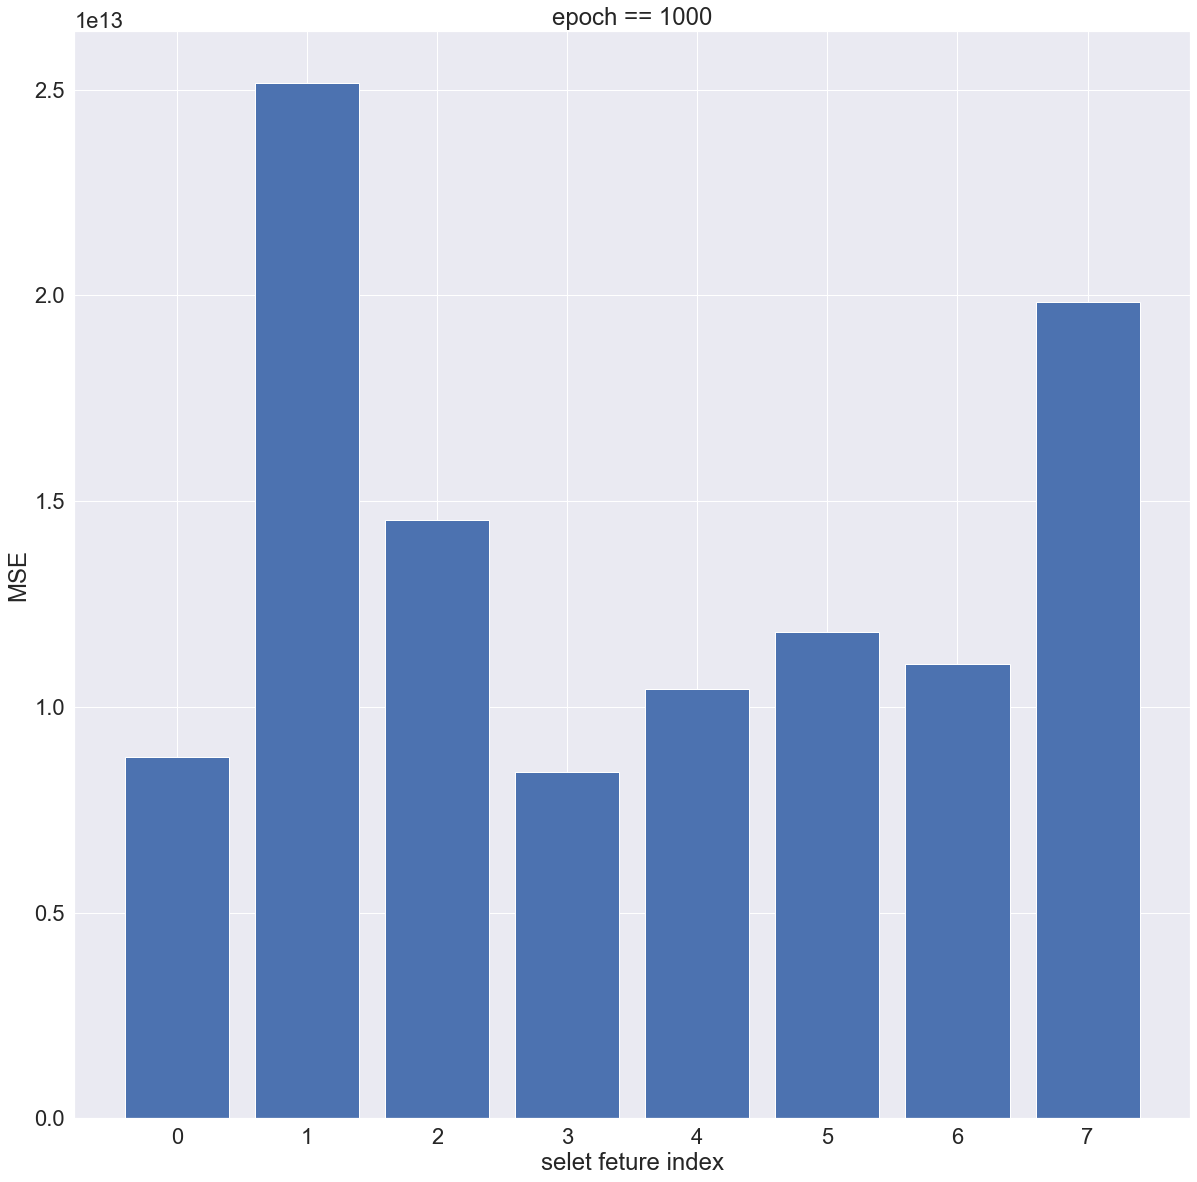

In [23]:
# 시각화

sns.set(font_scale=2, rc={'figure.figsize':(20, 20)})

combination_len = range(len(combination_result))

plt.title('epoch == 1000')
plt.bar(combination_len,combination_result)


plt.xlabel('selet feture index')
plt.ylabel('MSE')
plt.show()

### 모델 기본값 찾기(batch nomalization, drop out)

In [24]:
y_train = train['value']
x_train = pd_list[0] # 인덱스 선택 가능

try:
    del x_train['inner_product']
except:
    pass

In [25]:
# Training & Test set 으로 나눠주기

x_train, x_test, y_train, y_test = model_selection.train_test_split(x_train, y_train, test_size=0.2, random_state=42) # -> 아래 딥러닝 부분에 추가함

In [26]:
input_dim_num = len(x_train.iloc[0])

### 레이어층 비교

In [27]:
#Sequential
model_1 = models.Sequential(name='model_1')


model_1.add(layers.Dense(input_dim=input_dim_num, units=input_dim_num*2, activation='relu',
                       kernel_initializer = initializers.he_uniform()))

model_1.add(layers.Dense(units=1, activation=None))


model_1.compile(optimizer=optimizers.Adam(),
              loss=losses.mean_squared_error,
              metrics=['mean_squared_error']) 

# summary
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_32 (Dense)            (None, 30)                480       
                                                                 
 dense_33 (Dense)            (None, 1)                 31        
                                                                 
Total params: 511
Trainable params: 511
Non-trainable params: 0
_________________________________________________________________


In [28]:
# model fitting 
model_name = model_1.name

history_model1 = model_1.fit(x_train, y_train,
                                  batch_size = 100,  #default batch_size = 32
                                  epochs = 1000,
                                  )

Epoch 1/1000
72/72 [==============================] - 0s 958us/step - loss: 38777166757888.0000 - mean_squared_error: 38777166757888.0000
Epoch 2/1000
72/72 [==============================] - 0s 972us/step - loss: 38772901150720.0000 - mean_squared_error: 38772901150720.0000
Epoch 3/1000
72/72 [==============================] - 0s 972us/step - loss: 38768442605568.0000 - mean_squared_error: 38768442605568.0000
Epoch 4/1000
72/72 [==============================] - 0s 972us/step - loss: 38763350720512.0000 - mean_squared_error: 38763350720512.0000
Epoch 5/1000
72/72 [==============================] - 0s 1ms/step - loss: 38757231230976.0000 - mean_squared_error: 38757231230976.0000
Epoch 6/1000
72/72 [==============================] - 0s 1ms/step - loss: 38749526294528.0000 - mean_squared_error: 38749526294528.0000
Epoch 7/1000
72/72 [==============================] - 0s 972us/step - loss: 38739749371904.0000 - mean_squared_error: 38739749371904.0000
Epoch 8/1000
72/72 [==================

72/72 [==============================] - 0s 930us/step - loss: 36034939191296.0000 - mean_squared_error: 36034939191296.0000
Epoch 61/1000
72/72 [==============================] - 0s 958us/step - loss: 35965166944256.0000 - mean_squared_error: 35965166944256.0000
Epoch 62/1000
72/72 [==============================] - 0s 944us/step - loss: 35895579246592.0000 - mean_squared_error: 35895579246592.0000
Epoch 63/1000
72/72 [==============================] - 0s 930us/step - loss: 35825605672960.0000 - mean_squared_error: 35825605672960.0000
Epoch 64/1000
72/72 [==============================] - 0s 902us/step - loss: 35755808260096.0000 - mean_squared_error: 35755808260096.0000
Epoch 65/1000
72/72 [==============================] - 0s 930us/step - loss: 35685763383296.0000 - mean_squared_error: 35685763383296.0000
Epoch 66/1000
72/72 [==============================] - 0s 930us/step - loss: 35615890472960.0000 - mean_squared_error: 35615890472960.0000
Epoch 67/1000
72/72 [====================

72/72 [==============================] - 0s 1ms/step - loss: 32375448797184.0000 - mean_squared_error: 32375448797184.0000
Epoch 120/1000
72/72 [==============================] - 0s 1ms/step - loss: 32331714789376.0000 - mean_squared_error: 32331714789376.0000
Epoch 121/1000
72/72 [==============================] - 0s 1ms/step - loss: 32289100660736.0000 - mean_squared_error: 32289100660736.0000
Epoch 122/1000
72/72 [==============================] - 0s 1ms/step - loss: 32247447027712.0000 - mean_squared_error: 32247447027712.0000
Epoch 123/1000
72/72 [==============================] - 0s 1ms/step - loss: 32206621769728.0000 - mean_squared_error: 32206621769728.0000
Epoch 124/1000
72/72 [==============================] - 0s 972us/step - loss: 32166861864960.0000 - mean_squared_error: 32166861864960.0000
Epoch 125/1000
72/72 [==============================] - 0s 1ms/step - loss: 32127160680448.0000 - mean_squared_error: 32127164874752.0000
Epoch 126/1000
72/72 [=========================

Epoch 178/1000
72/72 [==============================] - 0s 1ms/step - loss: 31215665020928.0000 - mean_squared_error: 31215665020928.0000
Epoch 179/1000
72/72 [==============================] - 0s 1ms/step - loss: 31212812894208.0000 - mean_squared_error: 31212812894208.0000
Epoch 180/1000
72/72 [==============================] - 0s 1ms/step - loss: 31210143219712.0000 - mean_squared_error: 31210143219712.0000
Epoch 181/1000
72/72 [==============================] - 0s 1ms/step - loss: 31207777632256.0000 - mean_squared_error: 31207777632256.0000
Epoch 182/1000
72/72 [==============================] - 0s 958us/step - loss: 31205680480256.0000 - mean_squared_error: 31205680480256.0000
Epoch 183/1000
72/72 [==============================] - 0s 930us/step - loss: 31203633659904.0000 - mean_squared_error: 31203633659904.0000
Epoch 184/1000
72/72 [==============================] - 0s 1ms/step - loss: 31202291482624.0000 - mean_squared_error: 31202291482624.0000
Epoch 185/1000
72/72 [========

72/72 [==============================] - 0s 1ms/step - loss: 31166113513472.0000 - mean_squared_error: 31166109319168.0000
Epoch 237/1000
72/72 [==============================] - 0s 1ms/step - loss: 31165744414720.0000 - mean_squared_error: 31165744414720.0000
Epoch 238/1000
72/72 [==============================] - 0s 1ms/step - loss: 31165322887168.0000 - mean_squared_error: 31165322887168.0000
Epoch 239/1000
72/72 [==============================] - 0s 873us/step - loss: 31164949594112.0000 - mean_squared_error: 31164949594112.0000
Epoch 240/1000
72/72 [==============================] - 0s 972us/step - loss: 31164649701376.0000 - mean_squared_error: 31164649701376.0000
Epoch 241/1000
72/72 [==============================] - 0s 1ms/step - loss: 31164125413376.0000 - mean_squared_error: 31164121219072.0000
Epoch 242/1000
72/72 [==============================] - 0s 1ms/step - loss: 31163689205760.0000 - mean_squared_error: 31163689205760.0000
Epoch 243/1000
72/72 [=======================

72/72 [==============================] - 0s 944us/step - loss: 31140888969216.0000 - mean_squared_error: 31140888969216.0000
Epoch 296/1000
72/72 [==============================] - 0s 916us/step - loss: 31140408721408.0000 - mean_squared_error: 31140408721408.0000
Epoch 297/1000
72/72 [==============================] - 0s 902us/step - loss: 31139934765056.0000 - mean_squared_error: 31139934765056.0000
Epoch 298/1000
72/72 [==============================] - 0s 944us/step - loss: 31139511140352.0000 - mean_squared_error: 31139511140352.0000
Epoch 299/1000
72/72 [==============================] - 0s 986us/step - loss: 31139001532416.0000 - mean_squared_error: 31139001532416.0000
Epoch 300/1000
72/72 [==============================] - 0s 902us/step - loss: 31138735194112.0000 - mean_squared_error: 31138735194112.0000
Epoch 301/1000
72/72 [==============================] - 0s 916us/step - loss: 31138263334912.0000 - mean_squared_error: 31138263334912.0000
Epoch 302/1000
72/72 [=============

72/72 [==============================] - 0s 972us/step - loss: 31114630529024.0000 - mean_squared_error: 31114630529024.0000
Epoch 354/1000
72/72 [==============================] - 0s 1ms/step - loss: 31113894428672.0000 - mean_squared_error: 31113894428672.0000
Epoch 355/1000
72/72 [==============================] - 0s 1ms/step - loss: 31113470803968.0000 - mean_squared_error: 31113470803968.0000
Epoch 356/1000
72/72 [==============================] - 0s 1ms/step - loss: 31113080733696.0000 - mean_squared_error: 31113080733696.0000
Epoch 357/1000
72/72 [==============================] - 0s 944us/step - loss: 31112610971648.0000 - mean_squared_error: 31112610971648.0000
Epoch 358/1000
72/72 [==============================] - 0s 1ms/step - loss: 31112048934912.0000 - mean_squared_error: 31112048934912.0000
Epoch 359/1000
72/72 [==============================] - 0s 1ms/step - loss: 31111507869696.0000 - mean_squared_error: 31111507869696.0000
Epoch 360/1000
72/72 [=======================

72/72 [==============================] - 0s 1ms/step - loss: 31086262353920.0000 - mean_squared_error: 31086262353920.0000
Epoch 412/1000
72/72 [==============================] - 0s 944us/step - loss: 31085664665600.0000 - mean_squared_error: 31085664665600.0000
Epoch 413/1000
72/72 [==============================] - 0s 958us/step - loss: 31085171834880.0000 - mean_squared_error: 31085173932032.0000
Epoch 414/1000
72/72 [==============================] - 0s 902us/step - loss: 31084551077888.0000 - mean_squared_error: 31084551077888.0000
Epoch 415/1000
72/72 [==============================] - 0s 859us/step - loss: 31084049858560.0000 - mean_squared_error: 31084049858560.0000
Epoch 416/1000
72/72 [==============================] - 0s 944us/step - loss: 31083636719616.0000 - mean_squared_error: 31083636719616.0000
Epoch 417/1000
72/72 [==============================] - 0s 859us/step - loss: 31083250843648.0000 - mean_squared_error: 31083246649344.0000
Epoch 418/1000
72/72 [===============

72/72 [==============================] - 0s 916us/step - loss: 31055721529344.0000 - mean_squared_error: 31055721529344.0000
Epoch 470/1000
72/72 [==============================] - 0s 972us/step - loss: 31055291613184.0000 - mean_squared_error: 31055291613184.0000
Epoch 471/1000
72/72 [==============================] - 0s 1ms/step - loss: 31054786199552.0000 - mean_squared_error: 31054786199552.0000
Epoch 472/1000
72/72 [==============================] - 0s 916us/step - loss: 31054354186240.0000 - mean_squared_error: 31054354186240.0000
Epoch 473/1000
72/72 [==============================] - 0s 902us/step - loss: 31053708263424.0000 - mean_squared_error: 31053708263424.0000
Epoch 474/1000
72/72 [==============================] - 0s 972us/step - loss: 31053127352320.0000 - mean_squared_error: 31053127352320.0000
Epoch 475/1000
72/72 [==============================] - 0s 1ms/step - loss: 31052724699136.0000 - mean_squared_error: 31052730990592.0000
Epoch 476/1000
72/72 [=================

72/72 [==============================] - 0s 888us/step - loss: 31024008396800.0000 - mean_squared_error: 31024008396800.0000
Epoch 528/1000
72/72 [==============================] - 0s 930us/step - loss: 31023270199296.0000 - mean_squared_error: 31023270199296.0000
Epoch 529/1000
72/72 [==============================] - 0s 888us/step - loss: 31022806728704.0000 - mean_squared_error: 31022806728704.0000
Epoch 530/1000
72/72 [==============================] - 0s 902us/step - loss: 31022095794176.0000 - mean_squared_error: 31022095794176.0000
Epoch 531/1000
72/72 [==============================] - 0s 1ms/step - loss: 31021477134336.0000 - mean_squared_error: 31021477134336.0000
Epoch 532/1000
72/72 [==============================] - 0s 1ms/step - loss: 31021114327040.0000 - mean_squared_error: 31021114327040.0000
Epoch 533/1000
72/72 [==============================] - 0s 1ms/step - loss: 31020476792832.0000 - mean_squared_error: 31020476792832.0000
Epoch 534/1000
72/72 [===================

72/72 [==============================] - 0s 1ms/step - loss: 30989090816000.0000 - mean_squared_error: 30989090816000.0000
Epoch 587/1000
72/72 [==============================] - 0s 1ms/step - loss: 30988627345408.0000 - mean_squared_error: 30988627345408.0000
Epoch 588/1000
72/72 [==============================] - 0s 2ms/step - loss: 30988103057408.0000 - mean_squared_error: 30988103057408.0000
Epoch 589/1000
72/72 [==============================] - 0s 1ms/step - loss: 30987381637120.0000 - mean_squared_error: 30987383734272.0000
Epoch 590/1000
72/72 [==============================] - 0s 1ms/step - loss: 30986681188352.0000 - mean_squared_error: 30986681188352.0000
Epoch 591/1000
72/72 [==============================] - 0s 1ms/step - loss: 30986008002560.0000 - mean_squared_error: 30986008002560.0000
Epoch 592/1000
72/72 [==============================] - 0s 986us/step - loss: 30985555017728.0000 - mean_squared_error: 30985555017728.0000
Epoch 593/1000
72/72 [=========================

72/72 [==============================] - 0s 1ms/step - loss: 30953179185152.0000 - mean_squared_error: 30953179185152.0000
Epoch 645/1000
72/72 [==============================] - 0s 1ms/step - loss: 30952610856960.0000 - mean_squared_error: 30952610856960.0000
Epoch 646/1000
72/72 [==============================] - 0s 972us/step - loss: 30951958642688.0000 - mean_squared_error: 30951958642688.0000
Epoch 647/1000
72/72 [==============================] - 0s 902us/step - loss: 30951264485376.0000 - mean_squared_error: 30951264485376.0000
Epoch 648/1000
72/72 [==============================] - 0s 888us/step - loss: 30950698254336.0000 - mean_squared_error: 30950698254336.0000
Epoch 649/1000
72/72 [==============================] - 0s 916us/step - loss: 30950079594496.0000 - mean_squared_error: 30950079594496.0000
Epoch 650/1000
72/72 [==============================] - 0s 1ms/step - loss: 30949389631488.0000 - mean_squared_error: 30949389631488.0000
Epoch 651/1000
72/72 [===================

72/72 [==============================] - 0s 902us/step - loss: 30915497558016.0000 - mean_squared_error: 30915497558016.0000
Epoch 703/1000
72/72 [==============================] - 0s 902us/step - loss: 30914769846272.0000 - mean_squared_error: 30914767749120.0000
Epoch 704/1000
72/72 [==============================] - 0s 972us/step - loss: 30914071494656.0000 - mean_squared_error: 30914071494656.0000
Epoch 705/1000
72/72 [==============================] - 0s 930us/step - loss: 30913593344000.0000 - mean_squared_error: 30913591246848.0000
Epoch 706/1000
72/72 [==============================] - 0s 972us/step - loss: 30912718831616.0000 - mean_squared_error: 30912714637312.0000
Epoch 707/1000
72/72 [==============================] - 0s 972us/step - loss: 30912058228736.0000 - mean_squared_error: 30912058228736.0000
Epoch 708/1000
72/72 [==============================] - 0s 944us/step - loss: 30911491997696.0000 - mean_squared_error: 30911491997696.0000
Epoch 709/1000
72/72 [=============

72/72 [==============================] - 0s 1ms/step - loss: 30875389526016.0000 - mean_squared_error: 30875389526016.0000
Epoch 761/1000
72/72 [==============================] - 0s 986us/step - loss: 30874538082304.0000 - mean_squared_error: 30874538082304.0000
Epoch 762/1000
72/72 [==============================] - 0s 986us/step - loss: 30873894256640.0000 - mean_squared_error: 30873894256640.0000
Epoch 763/1000
72/72 [==============================] - 0s 888us/step - loss: 30873189613568.0000 - mean_squared_error: 30873189613568.0000
Epoch 764/1000
72/72 [==============================] - 0s 916us/step - loss: 30872468193280.0000 - mean_squared_error: 30872463998976.0000
Epoch 765/1000
72/72 [==============================] - 0s 902us/step - loss: 30871845339136.0000 - mean_squared_error: 30871845339136.0000
Epoch 766/1000
72/72 [==============================] - 0s 986us/step - loss: 30871302176768.0000 - mean_squared_error: 30871304273920.0000
Epoch 767/1000
72/72 [===============

72/72 [==============================] - 0s 930us/step - loss: 30833536663552.0000 - mean_squared_error: 30833536663552.0000
Epoch 819/1000
72/72 [==============================] - 0s 916us/step - loss: 30832439853056.0000 - mean_squared_error: 30832439853056.0000
Epoch 820/1000
72/72 [==============================] - 0s 859us/step - loss: 30831502426112.0000 - mean_squared_error: 30831502426112.0000
Epoch 821/1000
72/72 [==============================] - 0s 902us/step - loss: 30830913126400.0000 - mean_squared_error: 30830913126400.0000
Epoch 822/1000
72/72 [==============================] - 0s 916us/step - loss: 30830153957376.0000 - mean_squared_error: 30830153957376.0000
Epoch 823/1000
72/72 [==============================] - 0s 888us/step - loss: 30829344456704.0000 - mean_squared_error: 30829344456704.0000
Epoch 824/1000
72/72 [==============================] - 0s 986us/step - loss: 30828830654464.0000 - mean_squared_error: 30828830654464.0000
Epoch 825/1000
72/72 [=============

72/72 [==============================] - 0s 916us/step - loss: 30789110595584.0000 - mean_squared_error: 30789112692736.0000
Epoch 877/1000
72/72 [==============================] - 0s 873us/step - loss: 30788240277504.0000 - mean_squared_error: 30788242374656.0000
Epoch 878/1000
72/72 [==============================] - 0s 944us/step - loss: 30787451748352.0000 - mean_squared_error: 30787453845504.0000
Epoch 879/1000
72/72 [==============================] - 0s 902us/step - loss: 30786719842304.0000 - mean_squared_error: 30786719842304.0000
Epoch 880/1000
72/72 [==============================] - 0s 916us/step - loss: 30785985839104.0000 - mean_squared_error: 30785985839104.0000
Epoch 881/1000
72/72 [==============================] - 0s 1ms/step - loss: 30785006469120.0000 - mean_squared_error: 30785006469120.0000
Epoch 882/1000
72/72 [==============================] - 0s 958us/step - loss: 30784475889664.0000 - mean_squared_error: 30784475889664.0000
Epoch 883/1000
72/72 [===============

72/72 [==============================] - 0s 1ms/step - loss: 30742184722432.0000 - mean_squared_error: 30742184722432.0000
Epoch 935/1000
72/72 [==============================] - 0s 1ms/step - loss: 30741438136320.0000 - mean_squared_error: 30741438136320.0000
Epoch 936/1000
72/72 [==============================] - 0s 930us/step - loss: 30740714618880.0000 - mean_squared_error: 30740714618880.0000
Epoch 937/1000
72/72 [==============================] - 0s 902us/step - loss: 30739760414720.0000 - mean_squared_error: 30739760414720.0000
Epoch 938/1000
72/72 [==============================] - 0s 888us/step - loss: 30739150143488.0000 - mean_squared_error: 30739150143488.0000
Epoch 939/1000
72/72 [==============================] - 0s 930us/step - loss: 30738147704832.0000 - mean_squared_error: 30738147704832.0000
Epoch 940/1000
72/72 [==============================] - 0s 902us/step - loss: 30737268998144.0000 - mean_squared_error: 30737268998144.0000
Epoch 941/1000
72/72 [=================

72/72 [==============================] - 0s 873us/step - loss: 30693063131136.0000 - mean_squared_error: 30693063131136.0000
Epoch 993/1000
72/72 [==============================] - 0s 873us/step - loss: 30692633214976.0000 - mean_squared_error: 30692633214976.0000
Epoch 994/1000
72/72 [==============================] - 0s 916us/step - loss: 30691532210176.0000 - mean_squared_error: 30691532210176.0000
Epoch 995/1000
72/72 [==============================] - 0s 859us/step - loss: 30690787721216.0000 - mean_squared_error: 30690789818368.0000
Epoch 996/1000
72/72 [==============================] - 0s 930us/step - loss: 30689697202176.0000 - mean_squared_error: 30689697202176.0000
Epoch 997/1000
72/72 [==============================] - 0s 916us/step - loss: 30688940130304.0000 - mean_squared_error: 30688940130304.0000
Epoch 998/1000
72/72 [==============================] - 0s 888us/step - loss: 30688120143872.0000 - mean_squared_error: 30688120143872.0000
Epoch 999/1000
72/72 [=============

In [29]:
#Sequential
model_2 = models.Sequential(name='model_2')


model_2.add(layers.Dense(input_dim=input_dim_num, units=input_dim_num*2, activation='relu',
                       kernel_initializer = initializers.he_uniform()))

model_2.add(layers.Dense(units=input_dim_num*2, activation='relu',
                       kernel_initializer = initializers.he_uniform()))


model_2.add(layers.Dense(units=1, activation=None))


model_2.compile(optimizer=optimizers.Adam(),
              loss=losses.mean_squared_error,
              metrics=['mean_squared_error']) 

# summary
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_34 (Dense)            (None, 30)                480       
                                                                 
 dense_35 (Dense)            (None, 30)                930       
                                                                 
 dense_36 (Dense)            (None, 1)                 31        
                                                                 
Total params: 1,441
Trainable params: 1,441
Non-trainable params: 0
_________________________________________________________________


In [30]:
# model fitting 
model_name = model_2.name

history_model2 = model_2.fit(x_train, y_train,
                                  batch_size = 100,  #default batch_size = 32
                                  epochs = 1000,
                                  )

Epoch 1/1000
72/72 [==============================] - 0s 1ms/step - loss: 38747018100736.0000 - mean_squared_error: 38747018100736.0000
Epoch 2/1000
72/72 [==============================] - 0s 1ms/step - loss: 38696438988800.0000 - mean_squared_error: 38696438988800.0000
Epoch 3/1000
72/72 [==============================] - 0s 1ms/step - loss: 38588016230400.0000 - mean_squared_error: 38588016230400.0000
Epoch 4/1000
72/72 [==============================] - 0s 1ms/step - loss: 38387994066944.0000 - mean_squared_error: 38387994066944.0000
Epoch 5/1000
72/72 [==============================] - 0s 1ms/step - loss: 38063556263936.0000 - mean_squared_error: 38063556263936.0000
Epoch 6/1000
72/72 [==============================] - 0s 1ms/step - loss: 37598240178176.0000 - mean_squared_error: 37598240178176.0000
Epoch 7/1000
72/72 [==============================] - 0s 1ms/step - loss: 36981509718016.0000 - mean_squared_error: 36981505523712.0000
Epoch 8/1000
72/72 [============================

72/72 [==============================] - 0s 1ms/step - loss: 31109379260416.0000 - mean_squared_error: 31109379260416.0000
Epoch 61/1000
72/72 [==============================] - 0s 972us/step - loss: 31105881210880.0000 - mean_squared_error: 31105881210880.0000
Epoch 62/1000
72/72 [==============================] - 0s 1ms/step - loss: 31103903596544.0000 - mean_squared_error: 31103903596544.0000
Epoch 63/1000
72/72 [==============================] - 0s 1ms/step - loss: 31099803664384.0000 - mean_squared_error: 31099803664384.0000
Epoch 64/1000
72/72 [==============================] - 0s 1ms/step - loss: 31097385648128.0000 - mean_squared_error: 31097385648128.0000
Epoch 65/1000
72/72 [==============================] - 0s 1ms/step - loss: 31094990700544.0000 - mean_squared_error: 31094990700544.0000
Epoch 66/1000
72/72 [==============================] - 0s 1ms/step - loss: 31090674761728.0000 - mean_squared_error: 31090674761728.0000
Epoch 67/1000
72/72 [==============================] 

72/72 [==============================] - 0s 986us/step - loss: 30902417620992.0000 - mean_squared_error: 30902417620992.0000
Epoch 120/1000
72/72 [==============================] - 0s 1ms/step - loss: 30898825199616.0000 - mean_squared_error: 30898825199616.0000
Epoch 121/1000
72/72 [==============================] - 0s 1ms/step - loss: 30892305154048.0000 - mean_squared_error: 30892305154048.0000
Epoch 122/1000
72/72 [==============================] - 0s 1ms/step - loss: 30888284913664.0000 - mean_squared_error: 30888284913664.0000
Epoch 123/1000
72/72 [==============================] - 0s 1ms/step - loss: 30883625041920.0000 - mean_squared_error: 30883625041920.0000
Epoch 124/1000
72/72 [==============================] - 0s 1ms/step - loss: 30878346510336.0000 - mean_squared_error: 30878346510336.0000
Epoch 125/1000
72/72 [==============================] - 0s 1ms/step - loss: 30873227362304.0000 - mean_squared_error: 30873227362304.0000
Epoch 126/1000
72/72 [=========================

72/72 [==============================] - 0s 972us/step - loss: 30529760002048.0000 - mean_squared_error: 30529760002048.0000
Epoch 178/1000
72/72 [==============================] - 0s 972us/step - loss: 30519853056000.0000 - mean_squared_error: 30519853056000.0000
Epoch 179/1000
72/72 [==============================] - 0s 986us/step - loss: 30510875148288.0000 - mean_squared_error: 30510875148288.0000
Epoch 180/1000
72/72 [==============================] - 0s 1ms/step - loss: 30502291505152.0000 - mean_squared_error: 30502291505152.0000
Epoch 181/1000
72/72 [==============================] - 0s 930us/step - loss: 30491545698304.0000 - mean_squared_error: 30491545698304.0000
Epoch 182/1000
72/72 [==============================] - 0s 1ms/step - loss: 30481762484224.0000 - mean_squared_error: 30481762484224.0000
Epoch 183/1000
72/72 [==============================] - 0s 972us/step - loss: 30471104757760.0000 - mean_squared_error: 30471104757760.0000
Epoch 184/1000
72/72 [=================

72/72 [==============================] - 0s 1ms/step - loss: 29672802877440.0000 - mean_squared_error: 29672802877440.0000
Epoch 236/1000
72/72 [==============================] - 0s 958us/step - loss: 29648943579136.0000 - mean_squared_error: 29648943579136.0000
Epoch 237/1000
72/72 [==============================] - 0s 958us/step - loss: 29625631637504.0000 - mean_squared_error: 29625631637504.0000
Epoch 238/1000
72/72 [==============================] - 0s 1ms/step - loss: 29602359541760.0000 - mean_squared_error: 29602359541760.0000
Epoch 239/1000
72/72 [==============================] - 0s 944us/step - loss: 29573720834048.0000 - mean_squared_error: 29573720834048.0000
Epoch 240/1000
72/72 [==============================] - 0s 972us/step - loss: 29549660209152.0000 - mean_squared_error: 29549660209152.0000
Epoch 241/1000
72/72 [==============================] - 0s 986us/step - loss: 29522156060672.0000 - mean_squared_error: 29522156060672.0000
Epoch 242/1000
72/72 [=================

72/72 [==============================] - 0s 958us/step - loss: 27156822360064.0000 - mean_squared_error: 27156822360064.0000
Epoch 294/1000
72/72 [==============================] - 0s 958us/step - loss: 27079720566784.0000 - mean_squared_error: 27079720566784.0000
Epoch 295/1000
72/72 [==============================] - 0s 1ms/step - loss: 27014985678848.0000 - mean_squared_error: 27014985678848.0000
Epoch 296/1000
72/72 [==============================] - 0s 972us/step - loss: 26933377105920.0000 - mean_squared_error: 26933377105920.0000
Epoch 297/1000
72/72 [==============================] - 0s 986us/step - loss: 26859408457728.0000 - mean_squared_error: 26859408457728.0000
Epoch 298/1000
72/72 [==============================] - 0s 972us/step - loss: 26787096559616.0000 - mean_squared_error: 26787096559616.0000
Epoch 299/1000
72/72 [==============================] - 0s 1ms/step - loss: 26704208723968.0000 - mean_squared_error: 26704208723968.0000
Epoch 300/1000
72/72 [=================

72/72 [==============================] - 0s 986us/step - loss: 21367198056448.0000 - mean_squared_error: 21367198056448.0000
Epoch 352/1000
72/72 [==============================] - 0s 958us/step - loss: 21254528565248.0000 - mean_squared_error: 21254528565248.0000
Epoch 353/1000
72/72 [==============================] - 0s 958us/step - loss: 21137553620992.0000 - mean_squared_error: 21137553620992.0000
Epoch 354/1000
72/72 [==============================] - 0s 972us/step - loss: 21015662952448.0000 - mean_squared_error: 21015662952448.0000
Epoch 355/1000
72/72 [==============================] - 0s 944us/step - loss: 20899923230720.0000 - mean_squared_error: 20899923230720.0000
Epoch 356/1000
72/72 [==============================] - 0s 944us/step - loss: 20779043389440.0000 - mean_squared_error: 20779043389440.0000
Epoch 357/1000
72/72 [==============================] - 0s 986us/step - loss: 20677832736768.0000 - mean_squared_error: 20677832736768.0000
Epoch 358/1000
72/72 [=============

72/72 [==============================] - 0s 958us/step - loss: 15370759962624.0000 - mean_squared_error: 15370759962624.0000
Epoch 410/1000
72/72 [==============================] - 0s 1ms/step - loss: 15284404486144.0000 - mean_squared_error: 15284404486144.0000
Epoch 411/1000
72/72 [==============================] - 0s 986us/step - loss: 15236235001856.0000 - mean_squared_error: 15236235001856.0000
Epoch 412/1000
72/72 [==============================] - 0s 1ms/step - loss: 15133681123328.0000 - mean_squared_error: 15133681123328.0000
Epoch 413/1000
72/72 [==============================] - 0s 1ms/step - loss: 15057168629760.0000 - mean_squared_error: 15057168629760.0000
Epoch 414/1000
72/72 [==============================] - 0s 930us/step - loss: 14979481731072.0000 - mean_squared_error: 14979481731072.0000
Epoch 415/1000
72/72 [==============================] - 0s 958us/step - loss: 14906817511424.0000 - mean_squared_error: 14906817511424.0000
Epoch 416/1000
72/72 [===================

72/72 [==============================] - 0s 1ms/step - loss: 11823962128384.0000 - mean_squared_error: 11823962128384.0000
Epoch 468/1000
72/72 [==============================] - 0s 1ms/step - loss: 11787034427392.0000 - mean_squared_error: 11787034427392.0000
Epoch 469/1000
72/72 [==============================] - 0s 972us/step - loss: 11749532106752.0000 - mean_squared_error: 11749531058176.0000
Epoch 470/1000
72/72 [==============================] - 0s 958us/step - loss: 11734045687808.0000 - mean_squared_error: 11734045687808.0000
Epoch 471/1000
72/72 [==============================] - 0s 944us/step - loss: 11680456114176.0000 - mean_squared_error: 11680456114176.0000
Epoch 472/1000
72/72 [==============================] - 0s 1ms/step - loss: 11633717936128.0000 - mean_squared_error: 11633717936128.0000
Epoch 473/1000
72/72 [==============================] - 0s 986us/step - loss: 11615191695360.0000 - mean_squared_error: 11615191695360.0000
Epoch 474/1000
72/72 [===================

72/72 [==============================] - 0s 972us/step - loss: 9981752508416.0000 - mean_squared_error: 9981752508416.0000
Epoch 526/1000
72/72 [==============================] - 0s 972us/step - loss: 9960531427328.0000 - mean_squared_error: 9960531427328.0000
Epoch 527/1000
72/72 [==============================] - 0s 972us/step - loss: 9946729021440.0000 - mean_squared_error: 9946729021440.0000
Epoch 528/1000
72/72 [==============================] - 0s 972us/step - loss: 9901935951872.0000 - mean_squared_error: 9901935951872.0000
Epoch 529/1000
72/72 [==============================] - 0s 972us/step - loss: 9884582019072.0000 - mean_squared_error: 9884582019072.0000
Epoch 530/1000
72/72 [==============================] - 0s 972us/step - loss: 9843411779584.0000 - mean_squared_error: 9843412828160.0000
Epoch 531/1000
72/72 [==============================] - 0s 944us/step - loss: 9820980641792.0000 - mean_squared_error: 9820980641792.0000
Epoch 532/1000
72/72 [===========================

72/72 [==============================] - 0s 972us/step - loss: 8561083547648.0000 - mean_squared_error: 8561083547648.0000
Epoch 585/1000
72/72 [==============================] - 0s 958us/step - loss: 8533304672256.0000 - mean_squared_error: 8533304672256.0000
Epoch 586/1000
72/72 [==============================] - 0s 958us/step - loss: 8526918844416.0000 - mean_squared_error: 8526918844416.0000
Epoch 587/1000
72/72 [==============================] - 0s 972us/step - loss: 8496635445248.0000 - mean_squared_error: 8496635445248.0000
Epoch 588/1000
72/72 [==============================] - 0s 1ms/step - loss: 8476846194688.0000 - mean_squared_error: 8476846194688.0000
Epoch 589/1000
72/72 [==============================] - 0s 1ms/step - loss: 8449240858624.0000 - mean_squared_error: 8449240858624.0000
Epoch 590/1000
72/72 [==============================] - 0s 944us/step - loss: 8444671688704.0000 - mean_squared_error: 8444671688704.0000
Epoch 591/1000
72/72 [==============================]

72/72 [==============================] - 0s 972us/step - loss: 7357027319808.0000 - mean_squared_error: 7357027319808.0000
Epoch 644/1000
72/72 [==============================] - 0s 1ms/step - loss: 7334409535488.0000 - mean_squared_error: 7334409535488.0000
Epoch 645/1000
72/72 [==============================] - 0s 1ms/step - loss: 7318051225600.0000 - mean_squared_error: 7318051225600.0000
Epoch 646/1000
72/72 [==============================] - 0s 972us/step - loss: 7301537202176.0000 - mean_squared_error: 7301537202176.0000
Epoch 647/1000
72/72 [==============================] - 0s 986us/step - loss: 7289753829376.0000 - mean_squared_error: 7289753829376.0000
Epoch 648/1000
72/72 [==============================] - 0s 986us/step - loss: 7286794223616.0000 - mean_squared_error: 7286794223616.0000
Epoch 649/1000
72/72 [==============================] - 0s 972us/step - loss: 7255671439360.0000 - mean_squared_error: 7255671439360.0000
Epoch 650/1000
72/72 [==============================]

72/72 [==============================] - 0s 1ms/step - loss: 6341165842432.0000 - mean_squared_error: 6341165842432.0000
Epoch 703/1000
72/72 [==============================] - 0s 944us/step - loss: 6340462247936.0000 - mean_squared_error: 6340462247936.0000
Epoch 704/1000
72/72 [==============================] - 0s 986us/step - loss: 6320326967296.0000 - mean_squared_error: 6320326967296.0000
Epoch 705/1000
72/72 [==============================] - 0s 944us/step - loss: 6305451343872.0000 - mean_squared_error: 6305451343872.0000
Epoch 706/1000
72/72 [==============================] - 0s 986us/step - loss: 6275692756992.0000 - mean_squared_error: 6275693281280.0000
Epoch 707/1000
72/72 [==============================] - 0s 1ms/step - loss: 6264375476224.0000 - mean_squared_error: 6264375476224.0000
Epoch 708/1000
72/72 [==============================] - 0s 1ms/step - loss: 6255354576896.0000 - mean_squared_error: 6255354576896.0000
Epoch 709/1000
72/72 [==============================] -

72/72 [==============================] - 0s 986us/step - loss: 5531408793600.0000 - mean_squared_error: 5531408793600.0000
Epoch 762/1000
72/72 [==============================] - 0s 958us/step - loss: 5535318409216.0000 - mean_squared_error: 5535318409216.0000
Epoch 763/1000
72/72 [==============================] - 0s 944us/step - loss: 5511360544768.0000 - mean_squared_error: 5511360544768.0000
Epoch 764/1000
72/72 [==============================] - 0s 972us/step - loss: 5509023268864.0000 - mean_squared_error: 5509023268864.0000
Epoch 765/1000
72/72 [==============================] - 0s 972us/step - loss: 5478709985280.0000 - mean_squared_error: 5478709985280.0000
Epoch 766/1000
72/72 [==============================] - 0s 972us/step - loss: 5492639793152.0000 - mean_squared_error: 5492639268864.0000
Epoch 767/1000
72/72 [==============================] - 0s 986us/step - loss: 5467197145088.0000 - mean_squared_error: 5467197145088.0000
Epoch 768/1000
72/72 [===========================

72/72 [==============================] - 0s 1ms/step - loss: 4929394573312.0000 - mean_squared_error: 4929394573312.0000
Epoch 821/1000
72/72 [==============================] - 0s 1ms/step - loss: 4890053050368.0000 - mean_squared_error: 4890053050368.0000
Epoch 822/1000
72/72 [==============================] - 0s 972us/step - loss: 4860771041280.0000 - mean_squared_error: 4860771041280.0000
Epoch 823/1000
72/72 [==============================] - 0s 1ms/step - loss: 4866354184192.0000 - mean_squared_error: 4866354184192.0000
Epoch 824/1000
72/72 [==============================] - 0s 1ms/step - loss: 4860674048000.0000 - mean_squared_error: 4860674048000.0000
Epoch 825/1000
72/72 [==============================] - 0s 1ms/step - loss: 4845735510016.0000 - mean_squared_error: 4845735510016.0000
Epoch 826/1000
72/72 [==============================] - 0s 1ms/step - loss: 4846526660608.0000 - mean_squared_error: 4846526660608.0000
Epoch 827/1000
72/72 [==============================] - 0s 1m

72/72 [==============================] - 0s 1ms/step - loss: 4361187229696.0000 - mean_squared_error: 4361187229696.0000
Epoch 881/1000
72/72 [==============================] - 0s 1ms/step - loss: 4359911112704.0000 - mean_squared_error: 4359911112704.0000
Epoch 882/1000
72/72 [==============================] - 0s 1ms/step - loss: 4342700834816.0000 - mean_squared_error: 4342700834816.0000
Epoch 883/1000
72/72 [==============================] - 0s 1ms/step - loss: 4373366177792.0000 - mean_squared_error: 4373366177792.0000
Epoch 884/1000
72/72 [==============================] - 0s 1ms/step - loss: 4333861863424.0000 - mean_squared_error: 4333861863424.0000
Epoch 885/1000
72/72 [==============================] - 0s 1ms/step - loss: 4324654317568.0000 - mean_squared_error: 4324654317568.0000
Epoch 886/1000
72/72 [==============================] - 0s 1ms/step - loss: 4318703648768.0000 - mean_squared_error: 4318703648768.0000
Epoch 887/1000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 986us/step - loss: 3940021174272.0000 - mean_squared_error: 3940021174272.0000
Epoch 941/1000
72/72 [==============================] - 0s 1ms/step - loss: 3925680586752.0000 - mean_squared_error: 3925680586752.0000
Epoch 942/1000
72/72 [==============================] - 0s 1ms/step - loss: 3917980893184.0000 - mean_squared_error: 3917980893184.0000
Epoch 943/1000
72/72 [==============================] - 0s 1ms/step - loss: 3914263429120.0000 - mean_squared_error: 3914263429120.0000
Epoch 944/1000
72/72 [==============================] - 0s 986us/step - loss: 3922665406464.0000 - mean_squared_error: 3922665406464.0000
Epoch 945/1000
72/72 [==============================] - 0s 1ms/step - loss: 3910846906368.0000 - mean_squared_error: 3910846906368.0000
Epoch 946/1000
72/72 [==============================] - 0s 1ms/step - loss: 3887971172352.0000 - mean_squared_error: 3887971172352.0000
Epoch 947/1000
72/72 [==============================] - 0s 

72/72 [==============================] - 0s 1ms/step - loss: 3584269484032.0000 - mean_squared_error: 3584269221888.0000


In [31]:
#Sequential
model_3 = models.Sequential(name='model_3')


model_3.add(layers.Dense(input_dim=input_dim_num, units=input_dim_num*2, activation='relu',
                       kernel_initializer = initializers.he_uniform()))

model_3.add(layers.Dense(units=input_dim_num*2, activation='relu',
                       kernel_initializer = initializers.he_uniform()))

model_3.add(layers.Dense(units=input_dim_num*2, activation='relu',
                       kernel_initializer = initializers.he_uniform()))

model_3.add(layers.Dense(units=1, activation=None))


model_3.compile(optimizer=optimizers.Adam(),
              loss=losses.mean_squared_error,
              metrics=['mean_squared_error']) 

# summary
model_3.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_37 (Dense)            (None, 30)                480       
                                                                 
 dense_38 (Dense)            (None, 30)                930       
                                                                 
 dense_39 (Dense)            (None, 30)                930       
                                                                 
 dense_40 (Dense)            (None, 1)                 31        
                                                                 
Total params: 2,371
Trainable params: 2,371
Non-trainable params: 0
_________________________________________________________________


In [32]:
# model fitting 
model_name = model_3.name

history_model3 = model_3.fit(x_train, y_train,
                                  batch_size = 100,  #default batch_size = 32
                                  epochs = 1000,
                                  )

Epoch 1/1000
72/72 [==============================] - 1s 1ms/step - loss: 38764307021824.0000 - mean_squared_error: 38764307021824.0000
Epoch 2/1000
72/72 [==============================] - 0s 1ms/step - loss: 38687068913664.0000 - mean_squared_error: 38687068913664.0000
Epoch 3/1000
72/72 [==============================] - 0s 1ms/step - loss: 38350878670848.0000 - mean_squared_error: 38350878670848.0000
Epoch 4/1000
72/72 [==============================] - 0s 1ms/step - loss: 37363594035200.0000 - mean_squared_error: 37363598229504.0000
Epoch 5/1000
72/72 [==============================] - 0s 1ms/step - loss: 35442309201920.0000 - mean_squared_error: 35442309201920.0000
Epoch 6/1000
72/72 [==============================] - 0s 1ms/step - loss: 33089891860480.0000 - mean_squared_error: 33089891860480.0000
Epoch 7/1000
72/72 [==============================] - 0s 1ms/step - loss: 31629061914624.0000 - mean_squared_error: 31629061914624.0000
Epoch 8/1000
72/72 [============================

72/72 [==============================] - 0s 1ms/step - loss: 31018037805056.0000 - mean_squared_error: 31018037805056.0000
Epoch 61/1000
72/72 [==============================] - 0s 1ms/step - loss: 31012484546560.0000 - mean_squared_error: 31012482449408.0000
Epoch 62/1000
72/72 [==============================] - 0s 1ms/step - loss: 31009374470144.0000 - mean_squared_error: 31009374470144.0000
Epoch 63/1000
72/72 [==============================] - 0s 1ms/step - loss: 31003246592000.0000 - mean_squared_error: 31003246592000.0000
Epoch 64/1000
72/72 [==============================] - 0s 1ms/step - loss: 30998993567744.0000 - mean_squared_error: 30998993567744.0000
Epoch 65/1000
72/72 [==============================] - 0s 1ms/step - loss: 30993163485184.0000 - mean_squared_error: 30993163485184.0000
Epoch 66/1000
72/72 [==============================] - 0s 1ms/step - loss: 30987817844736.0000 - mean_squared_error: 30987817844736.0000
Epoch 67/1000
72/72 [==============================] - 

72/72 [==============================] - 0s 1ms/step - loss: 30497329643520.0000 - mean_squared_error: 30497329643520.0000
Epoch 120/1000
72/72 [==============================] - 0s 1ms/step - loss: 30487101833216.0000 - mean_squared_error: 30487101833216.0000
Epoch 121/1000
72/72 [==============================] - 0s 1ms/step - loss: 30458362462208.0000 - mean_squared_error: 30458362462208.0000
Epoch 122/1000
72/72 [==============================] - 0s 1ms/step - loss: 30433421033472.0000 - mean_squared_error: 30433421033472.0000
Epoch 123/1000
72/72 [==============================] - 0s 1ms/step - loss: 30409580609536.0000 - mean_squared_error: 30409580609536.0000
Epoch 124/1000
72/72 [==============================] - 0s 1ms/step - loss: 30386572754944.0000 - mean_squared_error: 30386572754944.0000
Epoch 125/1000
72/72 [==============================] - 0s 1ms/step - loss: 30364179365888.0000 - mean_squared_error: 30364179365888.0000
Epoch 126/1000
72/72 [===========================

72/72 [==============================] - 0s 1ms/step - loss: 10714588643328.0000 - mean_squared_error: 10714588643328.0000
Epoch 179/1000
72/72 [==============================] - 0s 1ms/step - loss: 10176044204032.0000 - mean_squared_error: 10176044204032.0000
Epoch 180/1000
72/72 [==============================] - 0s 1ms/step - loss: 9701124210688.0000 - mean_squared_error: 9701124210688.0000
Epoch 181/1000
72/72 [==============================] - 0s 1ms/step - loss: 9231253110784.0000 - mean_squared_error: 9231253110784.0000
Epoch 182/1000
72/72 [==============================] - 0s 1ms/step - loss: 8816921935872.0000 - mean_squared_error: 8816921935872.0000
Epoch 183/1000
72/72 [==============================] - 0s 1ms/step - loss: 8437685551104.0000 - mean_squared_error: 8437685551104.0000
Epoch 184/1000
72/72 [==============================] - 0s 1ms/step - loss: 8072804171776.0000 - mean_squared_error: 8072804171776.0000
Epoch 185/1000
72/72 [==============================] - 0s 

72/72 [==============================] - 0s 1ms/step - loss: 3262184161280.0000 - mean_squared_error: 3262184161280.0000
Epoch 239/1000
72/72 [==============================] - 0s 1ms/step - loss: 3184459513856.0000 - mean_squared_error: 3184459513856.0000
Epoch 240/1000
72/72 [==============================] - 0s 1ms/step - loss: 3168853295104.0000 - mean_squared_error: 3168853295104.0000
Epoch 241/1000
72/72 [==============================] - 0s 1ms/step - loss: 3116935413760.0000 - mean_squared_error: 3116935413760.0000
Epoch 242/1000
72/72 [==============================] - 0s 1ms/step - loss: 3111170867200.0000 - mean_squared_error: 3111170867200.0000
Epoch 243/1000
72/72 [==============================] - 0s 1ms/step - loss: 3074727608320.0000 - mean_squared_error: 3074727608320.0000
Epoch 244/1000
72/72 [==============================] - 0s 1ms/step - loss: 3046216826880.0000 - mean_squared_error: 3046216826880.0000
Epoch 245/1000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 2249116876800.0000 - mean_squared_error: 2249116876800.0000
Epoch 299/1000
72/72 [==============================] - 0s 1ms/step - loss: 2295473111040.0000 - mean_squared_error: 2295473111040.0000
Epoch 300/1000
72/72 [==============================] - 0s 1ms/step - loss: 2220958416896.0000 - mean_squared_error: 2220958416896.0000
Epoch 301/1000
72/72 [==============================] - 0s 1ms/step - loss: 2224841555968.0000 - mean_squared_error: 2224841555968.0000
Epoch 302/1000
72/72 [==============================] - 0s 1ms/step - loss: 2217251962880.0000 - mean_squared_error: 2217251962880.0000
Epoch 303/1000
72/72 [==============================] - 0s 1ms/step - loss: 2220830752768.0000 - mean_squared_error: 2220830752768.0000
Epoch 304/1000
72/72 [==============================] - 0s 1ms/step - loss: 2229770125312.0000 - mean_squared_error: 2229770125312.0000
Epoch 305/1000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 1922071658496.0000 - mean_squared_error: 1922071527424.0000
Epoch 359/1000
72/72 [==============================] - 0s 1ms/step - loss: 1898416963584.0000 - mean_squared_error: 1898416963584.0000
Epoch 360/1000
72/72 [==============================] - 0s 1ms/step - loss: 1850650263552.0000 - mean_squared_error: 1850650263552.0000
Epoch 361/1000
72/72 [==============================] - 0s 1ms/step - loss: 1948135718912.0000 - mean_squared_error: 1948135718912.0000
Epoch 362/1000
72/72 [==============================] - 0s 1ms/step - loss: 1875880706048.0000 - mean_squared_error: 1875880706048.0000
Epoch 363/1000
72/72 [==============================] - 0s 1ms/step - loss: 1872218685440.0000 - mean_squared_error: 1872218685440.0000
Epoch 364/1000
72/72 [==============================] - 0s 1ms/step - loss: 1880873238528.0000 - mean_squared_error: 1880873238528.0000
Epoch 365/1000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 1732299587584.0000 - mean_squared_error: 1732299587584.0000
Epoch 419/1000
72/72 [==============================] - 0s 1ms/step - loss: 1703548944384.0000 - mean_squared_error: 1703548944384.0000
Epoch 420/1000
72/72 [==============================] - 0s 1ms/step - loss: 1731591536640.0000 - mean_squared_error: 1731591536640.0000
Epoch 421/1000
72/72 [==============================] - 0s 1ms/step - loss: 1724565422080.0000 - mean_squared_error: 1724565422080.0000
Epoch 422/1000
72/72 [==============================] - 0s 1ms/step - loss: 1698550251520.0000 - mean_squared_error: 1698550251520.0000
Epoch 423/1000
72/72 [==============================] - 0s 1ms/step - loss: 1684720058368.0000 - mean_squared_error: 1684720058368.0000
Epoch 424/1000
72/72 [==============================] - 0s 1ms/step - loss: 1685054554112.0000 - mean_squared_error: 1685054554112.0000
Epoch 425/1000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 1611267702784.0000 - mean_squared_error: 1611267702784.0000
Epoch 479/1000
72/72 [==============================] - 0s 1ms/step - loss: 1553594580992.0000 - mean_squared_error: 1553594449920.0000
Epoch 480/1000
72/72 [==============================] - 0s 1ms/step - loss: 1557994668032.0000 - mean_squared_error: 1557994668032.0000
Epoch 481/1000
72/72 [==============================] - 0s 1ms/step - loss: 1551179186176.0000 - mean_squared_error: 1551179186176.0000
Epoch 482/1000
72/72 [==============================] - 0s 1ms/step - loss: 1561417220096.0000 - mean_squared_error: 1561417220096.0000
Epoch 483/1000
72/72 [==============================] - 0s 1ms/step - loss: 1536383647744.0000 - mean_squared_error: 1536383647744.0000
Epoch 484/1000
72/72 [==============================] - 0s 1ms/step - loss: 1575333789696.0000 - mean_squared_error: 1575333789696.0000
Epoch 485/1000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 1459205570560.0000 - mean_squared_error: 1459205570560.0000
Epoch 539/1000
72/72 [==============================] - 0s 1ms/step - loss: 1464276090880.0000 - mean_squared_error: 1464276090880.0000
Epoch 540/1000
72/72 [==============================] - 0s 1ms/step - loss: 1472777289728.0000 - mean_squared_error: 1472777289728.0000
Epoch 541/1000
72/72 [==============================] - 0s 1ms/step - loss: 1463707893760.0000 - mean_squared_error: 1463707893760.0000
Epoch 542/1000
72/72 [==============================] - 0s 1ms/step - loss: 1504678772736.0000 - mean_squared_error: 1504678772736.0000
Epoch 543/1000
72/72 [==============================] - 0s 1ms/step - loss: 1466827669504.0000 - mean_squared_error: 1466827669504.0000
Epoch 544/1000
72/72 [==============================] - 0s 1ms/step - loss: 1481019752448.0000 - mean_squared_error: 1481019752448.0000
Epoch 545/1000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 1380099817472.0000 - mean_squared_error: 1380099817472.0000
Epoch 599/1000
72/72 [==============================] - 0s 1ms/step - loss: 1372909469696.0000 - mean_squared_error: 1372909469696.0000
Epoch 600/1000
72/72 [==============================] - 0s 1ms/step - loss: 1397919186944.0000 - mean_squared_error: 1397918924800.0000
Epoch 601/1000
72/72 [==============================] - 0s 1ms/step - loss: 1366220865536.0000 - mean_squared_error: 1366220865536.0000
Epoch 602/1000
72/72 [==============================] - 0s 1ms/step - loss: 1413370216448.0000 - mean_squared_error: 1413370216448.0000
Epoch 603/1000
72/72 [==============================] - 0s 1ms/step - loss: 1382336692224.0000 - mean_squared_error: 1382336692224.0000
Epoch 604/1000
72/72 [==============================] - 0s 1ms/step - loss: 1415048069120.0000 - mean_squared_error: 1415048069120.0000
Epoch 605/1000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 1324088426496.0000 - mean_squared_error: 1324088426496.0000
Epoch 659/1000
72/72 [==============================] - 0s 1ms/step - loss: 1313925365760.0000 - mean_squared_error: 1313925365760.0000
Epoch 660/1000
72/72 [==============================] - 0s 1ms/step - loss: 1302319988736.0000 - mean_squared_error: 1302319988736.0000
Epoch 661/1000
72/72 [==============================] - 0s 1ms/step - loss: 1313568587776.0000 - mean_squared_error: 1313568587776.0000
Epoch 662/1000
72/72 [==============================] - 0s 1ms/step - loss: 1347387916288.0000 - mean_squared_error: 1347387916288.0000
Epoch 663/1000
72/72 [==============================] - 0s 1ms/step - loss: 1316161454080.0000 - mean_squared_error: 1316161454080.0000
Epoch 664/1000
72/72 [==============================] - 0s 1ms/step - loss: 1361763500032.0000 - mean_squared_error: 1361763500032.0000
Epoch 665/1000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 1260961136640.0000 - mean_squared_error: 1260961136640.0000
Epoch 719/1000
72/72 [==============================] - 0s 1ms/step - loss: 1241981255680.0000 - mean_squared_error: 1241981255680.0000
Epoch 720/1000
72/72 [==============================] - 0s 1ms/step - loss: 1293885374464.0000 - mean_squared_error: 1293885374464.0000
Epoch 721/1000
72/72 [==============================] - 0s 1ms/step - loss: 1262546059264.0000 - mean_squared_error: 1262546059264.0000
Epoch 722/1000
72/72 [==============================] - 0s 1ms/step - loss: 1271894900736.0000 - mean_squared_error: 1271894900736.0000
Epoch 723/1000
72/72 [==============================] - 0s 1ms/step - loss: 1263448752128.0000 - mean_squared_error: 1263448752128.0000
Epoch 724/1000
72/72 [==============================] - 0s 1ms/step - loss: 1286579814400.0000 - mean_squared_error: 1286579945472.0000
Epoch 725/1000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 1191772815360.0000 - mean_squared_error: 1191772815360.0000
Epoch 779/1000
72/72 [==============================] - 0s 1ms/step - loss: 1185912586240.0000 - mean_squared_error: 1185912586240.0000
Epoch 780/1000
72/72 [==============================] - 0s 1ms/step - loss: 1216047874048.0000 - mean_squared_error: 1216047874048.0000
Epoch 781/1000
72/72 [==============================] - 0s 1ms/step - loss: 1198496415744.0000 - mean_squared_error: 1198496415744.0000
Epoch 782/1000
72/72 [==============================] - 0s 1ms/step - loss: 1202759008256.0000 - mean_squared_error: 1202759008256.0000
Epoch 783/1000
72/72 [==============================] - 0s 1ms/step - loss: 1182053564416.0000 - mean_squared_error: 1182053564416.0000
Epoch 784/1000
72/72 [==============================] - 0s 1ms/step - loss: 1205334048768.0000 - mean_squared_error: 1205334048768.0000
Epoch 785/1000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 1160024424448.0000 - mean_squared_error: 1160024424448.0000
Epoch 839/1000
72/72 [==============================] - 0s 1ms/step - loss: 1161217441792.0000 - mean_squared_error: 1161217441792.0000
Epoch 840/1000
72/72 [==============================] - 0s 1ms/step - loss: 1160691712000.0000 - mean_squared_error: 1160691712000.0000
Epoch 841/1000
72/72 [==============================] - 0s 1ms/step - loss: 1148620898304.0000 - mean_squared_error: 1148620898304.0000
Epoch 842/1000
72/72 [==============================] - 0s 1ms/step - loss: 1170527092736.0000 - mean_squared_error: 1170527092736.0000
Epoch 843/1000
72/72 [==============================] - 0s 1ms/step - loss: 1149420961792.0000 - mean_squared_error: 1149420961792.0000
Epoch 844/1000
72/72 [==============================] - 0s 1ms/step - loss: 1153371078656.0000 - mean_squared_error: 1153371078656.0000
Epoch 845/1000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 1108945797120.0000 - mean_squared_error: 1108945797120.0000
Epoch 899/1000
72/72 [==============================] - 0s 1ms/step - loss: 1120641351680.0000 - mean_squared_error: 1120641220608.0000
Epoch 900/1000
72/72 [==============================] - 0s 1ms/step - loss: 1115255341056.0000 - mean_squared_error: 1115255341056.0000
Epoch 901/1000
72/72 [==============================] - 0s 1ms/step - loss: 1109192998912.0000 - mean_squared_error: 1109192998912.0000
Epoch 902/1000
72/72 [==============================] - 0s 1ms/step - loss: 1100019662848.0000 - mean_squared_error: 1100019662848.0000
Epoch 903/1000
72/72 [==============================] - 0s 1ms/step - loss: 1112387354624.0000 - mean_squared_error: 1112387354624.0000
Epoch 904/1000
72/72 [==============================] - 0s 1ms/step - loss: 1121859928064.0000 - mean_squared_error: 1121859928064.0000
Epoch 905/1000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 1094478069760.0000 - mean_squared_error: 1094478069760.0000
Epoch 959/1000
72/72 [==============================] - 0s 1ms/step - loss: 1084205760512.0000 - mean_squared_error: 1084205826048.0000
Epoch 960/1000
72/72 [==============================] - 0s 1ms/step - loss: 1082254229504.0000 - mean_squared_error: 1082254229504.0000
Epoch 961/1000
72/72 [==============================] - 0s 1ms/step - loss: 1068536365056.0000 - mean_squared_error: 1068536365056.0000
Epoch 962/1000
72/72 [==============================] - 0s 1ms/step - loss: 1104045277184.0000 - mean_squared_error: 1104045277184.0000
Epoch 963/1000
72/72 [==============================] - 0s 1ms/step - loss: 1070016495616.0000 - mean_squared_error: 1070016495616.0000
Epoch 964/1000
72/72 [==============================] - 0s 1ms/step - loss: 1101127745536.0000 - mean_squared_error: 1101127745536.0000
Epoch 965/1000
72/72 [==============================] - 0s 1ms/

In [33]:
result_model_1 = model_1.evaluate(x_test, y_test, batch_size=100)
result_model_2 = model_2.evaluate(x_test, y_test, batch_size=100)
result_model_3 = model_3.evaluate(x_test, y_test, batch_size=100)

18/18 [==============================] - 0s 824us/step - loss: 1871985115136.0000 - mean_squared_error: 1871985115136.0000


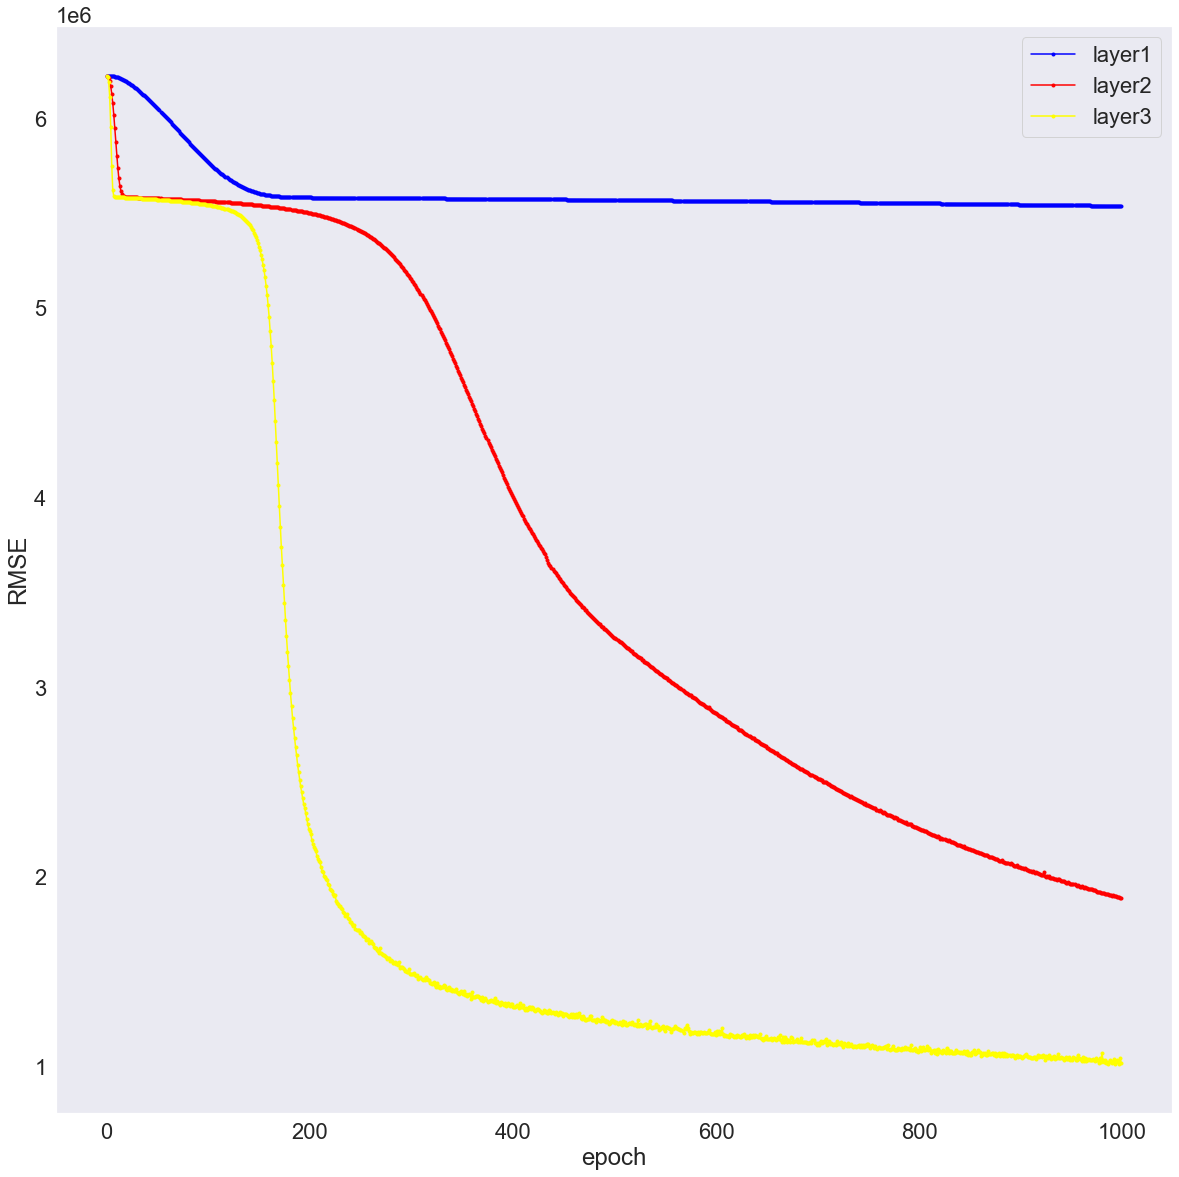

In [34]:
layer1_rmse = np.sqrt(history_model1.history['loss'])
layer2_rmse = np.sqrt(history_model2.history['loss'])
layer3_rmse = np.sqrt(history_model3.history['loss'])


x_len = np.arange(len(layer1_rmse))

plt.plot(x_len, layer1_rmse, marker = '.', c='blue', label = 'layer1')
plt.plot(x_len, layer2_rmse, marker = '.', c='red', label = 'layer2')
plt.plot(x_len, layer3_rmse, marker = '.', c='yellow', label = 'layer3')

plt.legend(loc = 'upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('RMSE')
plt.show()

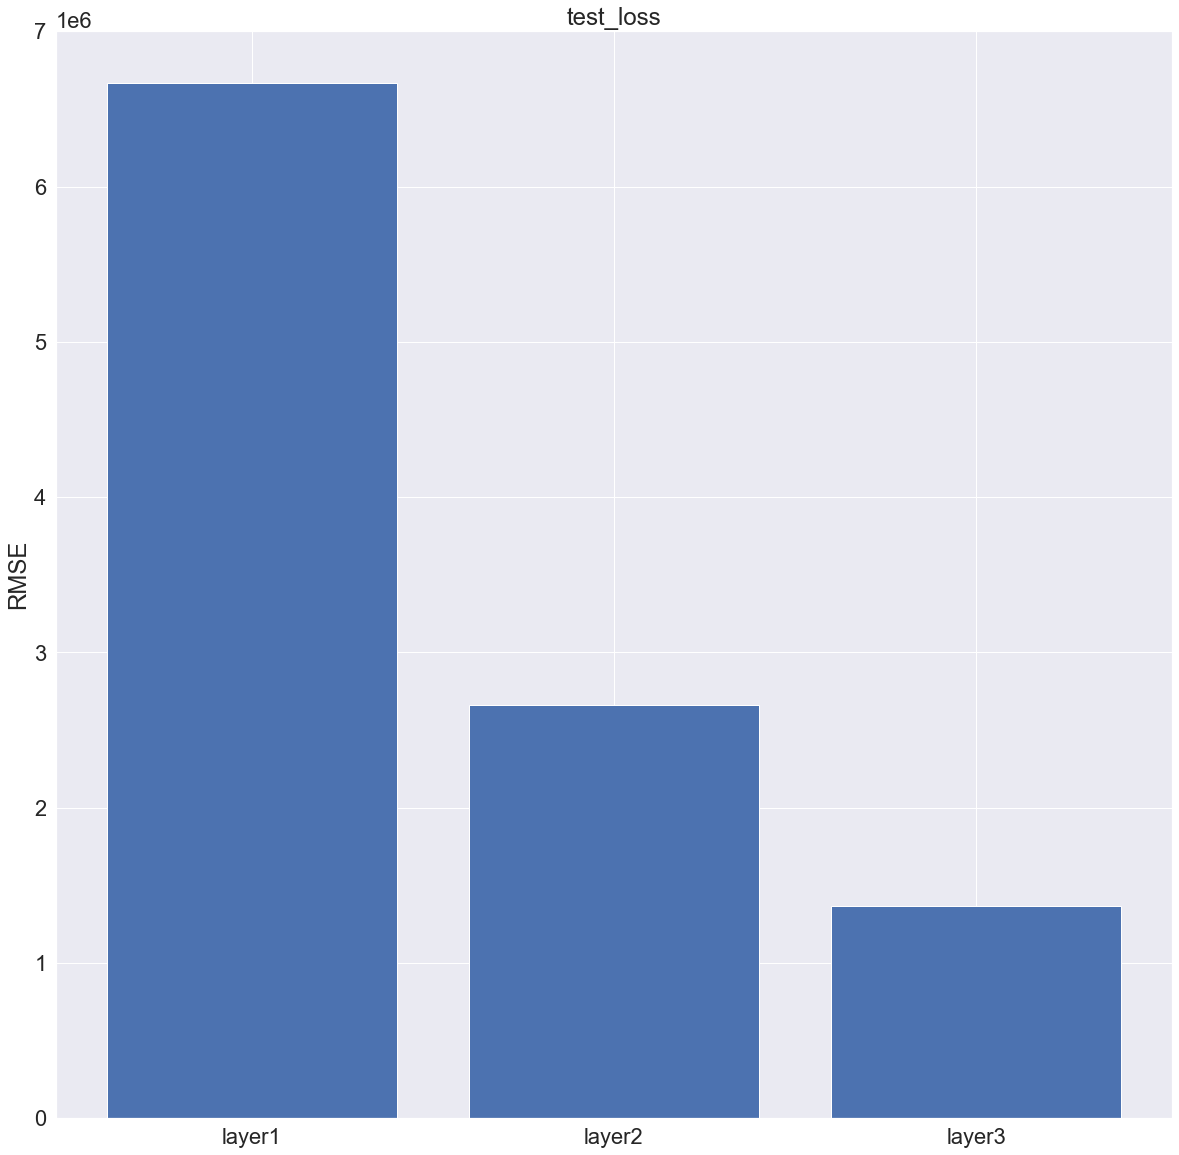

In [35]:
result_models = ['layer1','layer2','layer3' ]
list_result= [np.sqrt(result_model_1[0]), np.sqrt(result_model_2[0]),np.sqrt(result_model_3[0])]

plt.title('test_loss')
plt.bar(result_models,list_result)

plt.xlabel('')
plt.ylabel('RMSE')
plt.show()

In [36]:
#Sequential
model_origin = models.Sequential(name='model_origin')


model_origin.add(layers.Dense(input_dim=input_dim_num, units=input_dim_num*2, activation='relu',
                       kernel_initializer = initializers.he_uniform()))

model_origin.add(layers.Dense(units=input_dim_num*2, activation='relu',
                       kernel_initializer = initializers.he_uniform()))

model_origin.add(layers.Dense(units=input_dim_num*2, activation='relu',
                       kernel_initializer = initializers.he_uniform()))

model_origin.add(layers.Dense(units=1, activation=None))


model_origin.compile(optimizer=optimizers.Adam(),
              loss=losses.mean_squared_error,
              metrics=['mean_squared_error']) 

# summary
model_origin.summary()

Model: "model_origin"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_41 (Dense)            (None, 30)                480       
                                                                 
 dense_42 (Dense)            (None, 30)                930       
                                                                 
 dense_43 (Dense)            (None, 30)                930       
                                                                 
 dense_44 (Dense)            (None, 1)                 31        
                                                                 
Total params: 2,371
Trainable params: 2,371
Non-trainable params: 0
_________________________________________________________________


In [37]:
# model fitting 기본맛
model_name = model_origin.name

history_origin = model_origin.fit(x_train, y_train,
                                  batch_size = 100,  #default batch_size = 32
                                  epochs = 1000,
                                  )

Epoch 1/1000
72/72 [==============================] - 1s 1ms/step - loss: 38770195824640.0000 - mean_squared_error: 38770195824640.0000
Epoch 2/1000
72/72 [==============================] - 0s 1ms/step - loss: 38707637780480.0000 - mean_squared_error: 38707637780480.0000
Epoch 3/1000
72/72 [==============================] - 0s 1ms/step - loss: 38373104287744.0000 - mean_squared_error: 38373104287744.0000
Epoch 4/1000
72/72 [==============================] - 0s 1ms/step - loss: 37194261594112.0000 - mean_squared_error: 37194261594112.0000
Epoch 5/1000
72/72 [==============================] - 0s 1ms/step - loss: 34871403610112.0000 - mean_squared_error: 34871403610112.0000
Epoch 6/1000
72/72 [==============================] - 0s 1ms/step - loss: 32391856914432.0000 - mean_squared_error: 32391852720128.0000
Epoch 7/1000
72/72 [==============================] - 0s 1ms/step - loss: 31354465026048.0000 - mean_squared_error: 31354465026048.0000
Epoch 8/1000
72/72 [============================

72/72 [==============================] - 0s 1ms/step - loss: 30891155914752.0000 - mean_squared_error: 30891153817600.0000
Epoch 61/1000
72/72 [==============================] - 0s 1ms/step - loss: 30883014770688.0000 - mean_squared_error: 30883014770688.0000
Epoch 62/1000
72/72 [==============================] - 0s 1ms/step - loss: 30863041495040.0000 - mean_squared_error: 30863041495040.0000
Epoch 63/1000
72/72 [==============================] - 0s 1ms/step - loss: 30853237309440.0000 - mean_squared_error: 30853237309440.0000
Epoch 64/1000
72/72 [==============================] - 0s 1ms/step - loss: 30841243697152.0000 - mean_squared_error: 30841243697152.0000
Epoch 65/1000
72/72 [==============================] - 0s 1ms/step - loss: 30830973943808.0000 - mean_squared_error: 30830973943808.0000
Epoch 66/1000
72/72 [==============================] - 0s 1ms/step - loss: 30815335481344.0000 - mean_squared_error: 30815335481344.0000
Epoch 67/1000
72/72 [==============================] - 

72/72 [==============================] - 0s 1ms/step - loss: 27231948636160.0000 - mean_squared_error: 27231948636160.0000
Epoch 120/1000
72/72 [==============================] - 0s 1ms/step - loss: 26976312098816.0000 - mean_squared_error: 26976312098816.0000
Epoch 121/1000
72/72 [==============================] - 0s 1ms/step - loss: 26672524951552.0000 - mean_squared_error: 26672524951552.0000
Epoch 122/1000
72/72 [==============================] - 0s 1ms/step - loss: 26355731267584.0000 - mean_squared_error: 26355731267584.0000
Epoch 123/1000
72/72 [==============================] - 0s 1ms/step - loss: 26031811461120.0000 - mean_squared_error: 26031811461120.0000
Epoch 124/1000
72/72 [==============================] - 0s 1ms/step - loss: 25666676326400.0000 - mean_squared_error: 25666676326400.0000
Epoch 125/1000
72/72 [==============================] - 0s 1ms/step - loss: 25311762710528.0000 - mean_squared_error: 25311762710528.0000
Epoch 126/1000
72/72 [===========================

72/72 [==============================] - 0s 1ms/step - loss: 5559163551744.0000 - mean_squared_error: 5559163551744.0000
Epoch 179/1000
72/72 [==============================] - 0s 1ms/step - loss: 5411309092864.0000 - mean_squared_error: 5411309092864.0000
Epoch 180/1000
72/72 [==============================] - 0s 972us/step - loss: 5390059700224.0000 - mean_squared_error: 5390059700224.0000
Epoch 181/1000
72/72 [==============================] - 0s 1ms/step - loss: 5269629698048.0000 - mean_squared_error: 5269629698048.0000
Epoch 182/1000
72/72 [==============================] - 0s 1ms/step - loss: 5170479497216.0000 - mean_squared_error: 5170479497216.0000
Epoch 183/1000
72/72 [==============================] - 0s 1ms/step - loss: 5120305135616.0000 - mean_squared_error: 5120305135616.0000
Epoch 184/1000
72/72 [==============================] - 0s 1ms/step - loss: 5043399950336.0000 - mean_squared_error: 5043399950336.0000
Epoch 185/1000
72/72 [==============================] - 0s 1m

72/72 [==============================] - 0s 1ms/step - loss: 2928704225280.0000 - mean_squared_error: 2928704225280.0000
Epoch 239/1000
72/72 [==============================] - 0s 1ms/step - loss: 2908647063552.0000 - mean_squared_error: 2908647063552.0000
Epoch 240/1000
72/72 [==============================] - 0s 1ms/step - loss: 2918643662848.0000 - mean_squared_error: 2918643662848.0000
Epoch 241/1000
72/72 [==============================] - 0s 1ms/step - loss: 2898533548032.0000 - mean_squared_error: 2898533285888.0000
Epoch 242/1000
72/72 [==============================] - 0s 1ms/step - loss: 2836732051456.0000 - mean_squared_error: 2836732051456.0000
Epoch 243/1000
72/72 [==============================] - 0s 986us/step - loss: 2883471015936.0000 - mean_squared_error: 2883471015936.0000
Epoch 244/1000
72/72 [==============================] - 0s 1ms/step - loss: 2839205380096.0000 - mean_squared_error: 2839205380096.0000
Epoch 245/1000
72/72 [==============================] - 0s 1m

72/72 [==============================] - 0s 1ms/step - loss: 2170185056256.0000 - mean_squared_error: 2170185056256.0000
Epoch 299/1000
72/72 [==============================] - 0s 1ms/step - loss: 2153622274048.0000 - mean_squared_error: 2153622274048.0000
Epoch 300/1000
72/72 [==============================] - 0s 1ms/step - loss: 2180778950656.0000 - mean_squared_error: 2180778950656.0000
Epoch 301/1000
72/72 [==============================] - 0s 1ms/step - loss: 2113176862720.0000 - mean_squared_error: 2113176862720.0000
Epoch 302/1000
72/72 [==============================] - 0s 1ms/step - loss: 2132895465472.0000 - mean_squared_error: 2132895465472.0000
Epoch 303/1000
72/72 [==============================] - 0s 1ms/step - loss: 2104038653952.0000 - mean_squared_error: 2104038653952.0000
Epoch 304/1000
72/72 [==============================] - 0s 1ms/step - loss: 2111256526848.0000 - mean_squared_error: 2111256526848.0000
Epoch 305/1000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 986us/step - loss: 1865041707008.0000 - mean_squared_error: 1865041707008.0000
Epoch 359/1000
72/72 [==============================] - 0s 1ms/step - loss: 1872331800576.0000 - mean_squared_error: 1872331800576.0000
Epoch 360/1000
72/72 [==============================] - 0s 1ms/step - loss: 1834013949952.0000 - mean_squared_error: 1834013949952.0000
Epoch 361/1000
72/72 [==============================] - 0s 986us/step - loss: 1864090648576.0000 - mean_squared_error: 1864090648576.0000
Epoch 362/1000
72/72 [==============================] - 0s 1ms/step - loss: 1841373511680.0000 - mean_squared_error: 1841373511680.0000
Epoch 363/1000
72/72 [==============================] - 0s 1ms/step - loss: 1853161340928.0000 - mean_squared_error: 1853161340928.0000
Epoch 364/1000
72/72 [==============================] - 0s 1ms/step - loss: 1852221292544.0000 - mean_squared_error: 1852221292544.0000
Epoch 365/1000
72/72 [==============================] - 0s 

72/72 [==============================] - 0s 1ms/step - loss: 1699594502144.0000 - mean_squared_error: 1699594502144.0000
Epoch 419/1000
72/72 [==============================] - 0s 1ms/step - loss: 1727049236480.0000 - mean_squared_error: 1727049236480.0000
Epoch 420/1000
72/72 [==============================] - 0s 1ms/step - loss: 1710536785920.0000 - mean_squared_error: 1710536785920.0000
Epoch 421/1000
72/72 [==============================] - 0s 1ms/step - loss: 1675951603712.0000 - mean_squared_error: 1675951603712.0000
Epoch 422/1000
72/72 [==============================] - 0s 1ms/step - loss: 1690470711296.0000 - mean_squared_error: 1690470711296.0000
Epoch 423/1000
72/72 [==============================] - 0s 1ms/step - loss: 1773527367680.0000 - mean_squared_error: 1773527367680.0000
Epoch 424/1000
72/72 [==============================] - 0s 1ms/step - loss: 1703824064512.0000 - mean_squared_error: 1703824064512.0000
Epoch 425/1000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 1614858813440.0000 - mean_squared_error: 1614858813440.0000
Epoch 479/1000
72/72 [==============================] - 0s 1ms/step - loss: 1620359512064.0000 - mean_squared_error: 1620359512064.0000
Epoch 480/1000
72/72 [==============================] - 0s 1ms/step - loss: 1603494477824.0000 - mean_squared_error: 1603494477824.0000
Epoch 481/1000
72/72 [==============================] - 0s 1ms/step - loss: 1624028741632.0000 - mean_squared_error: 1624028741632.0000
Epoch 482/1000
72/72 [==============================] - 0s 1ms/step - loss: 1632254033920.0000 - mean_squared_error: 1632254033920.0000
Epoch 483/1000
72/72 [==============================] - 0s 1ms/step - loss: 1629936025600.0000 - mean_squared_error: 1629936025600.0000
Epoch 484/1000
72/72 [==============================] - 0s 1ms/step - loss: 1595630813184.0000 - mean_squared_error: 1595630813184.0000
Epoch 485/1000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 1519042822144.0000 - mean_squared_error: 1519042822144.0000
Epoch 539/1000
72/72 [==============================] - 0s 1ms/step - loss: 1523496779776.0000 - mean_squared_error: 1523496779776.0000
Epoch 540/1000
72/72 [==============================] - 0s 1ms/step - loss: 1564756803584.0000 - mean_squared_error: 1564756803584.0000
Epoch 541/1000
72/72 [==============================] - 0s 1ms/step - loss: 1520612933632.0000 - mean_squared_error: 1520612933632.0000
Epoch 542/1000
72/72 [==============================] - 0s 1ms/step - loss: 1497661702144.0000 - mean_squared_error: 1497661702144.0000
Epoch 543/1000
72/72 [==============================] - 0s 1ms/step - loss: 1514990862336.0000 - mean_squared_error: 1514990600192.0000
Epoch 544/1000
72/72 [==============================] - 0s 1ms/step - loss: 1531406712832.0000 - mean_squared_error: 1531406450688.0000
Epoch 545/1000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 1492994752512.0000 - mean_squared_error: 1492994752512.0000
Epoch 599/1000
72/72 [==============================] - 0s 1ms/step - loss: 1486949056512.0000 - mean_squared_error: 1486949056512.0000
Epoch 600/1000
72/72 [==============================] - 0s 1ms/step - loss: 1491499089920.0000 - mean_squared_error: 1491499089920.0000
Epoch 601/1000
72/72 [==============================] - 0s 1ms/step - loss: 1500980183040.0000 - mean_squared_error: 1500980183040.0000
Epoch 602/1000
72/72 [==============================] - 0s 1ms/step - loss: 1449503883264.0000 - mean_squared_error: 1449503883264.0000
Epoch 603/1000
72/72 [==============================] - 0s 1ms/step - loss: 1482462330880.0000 - mean_squared_error: 1482462330880.0000
Epoch 604/1000
72/72 [==============================] - 0s 1ms/step - loss: 1489432870912.0000 - mean_squared_error: 1489432870912.0000
Epoch 605/1000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 1392520069120.0000 - mean_squared_error: 1392520069120.0000
Epoch 659/1000
72/72 [==============================] - 0s 1ms/step - loss: 1458855477248.0000 - mean_squared_error: 1458855477248.0000
Epoch 660/1000
72/72 [==============================] - 0s 1ms/step - loss: 1436358803456.0000 - mean_squared_error: 1436358803456.0000
Epoch 661/1000
72/72 [==============================] - 0s 1ms/step - loss: 1388556189696.0000 - mean_squared_error: 1388556189696.0000
Epoch 662/1000
72/72 [==============================] - 0s 1ms/step - loss: 1392170762240.0000 - mean_squared_error: 1392170762240.0000
Epoch 663/1000
72/72 [==============================] - 0s 1ms/step - loss: 1405229858816.0000 - mean_squared_error: 1405229858816.0000
Epoch 664/1000
72/72 [==============================] - 0s 1ms/step - loss: 1455369355264.0000 - mean_squared_error: 1455369355264.0000
Epoch 665/1000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 1335596810240.0000 - mean_squared_error: 1335596810240.0000
Epoch 719/1000
72/72 [==============================] - 0s 1ms/step - loss: 1376300433408.0000 - mean_squared_error: 1376300433408.0000
Epoch 720/1000
72/72 [==============================] - 0s 1ms/step - loss: 1332156956672.0000 - mean_squared_error: 1332156956672.0000
Epoch 721/1000
72/72 [==============================] - 0s 1ms/step - loss: 1362503663616.0000 - mean_squared_error: 1362503663616.0000
Epoch 722/1000
72/72 [==============================] - 0s 1ms/step - loss: 1382074810368.0000 - mean_squared_error: 1382074810368.0000
Epoch 723/1000
72/72 [==============================] - 0s 2ms/step - loss: 1330501124096.0000 - mean_squared_error: 1330501124096.0000
Epoch 724/1000
72/72 [==============================] - 0s 1ms/step - loss: 1339312046080.0000 - mean_squared_error: 1339312046080.0000
Epoch 725/1000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 1347147661312.0000 - mean_squared_error: 1347147661312.0000
Epoch 779/1000
72/72 [==============================] - 0s 1ms/step - loss: 1323565842432.0000 - mean_squared_error: 1323565842432.0000
Epoch 780/1000
72/72 [==============================] - 0s 1ms/step - loss: 1305647120384.0000 - mean_squared_error: 1305647120384.0000
Epoch 781/1000
72/72 [==============================] - 0s 1ms/step - loss: 1315670327296.0000 - mean_squared_error: 1315670327296.0000
Epoch 782/1000
72/72 [==============================] - 0s 1ms/step - loss: 1284563533824.0000 - mean_squared_error: 1284563533824.0000
Epoch 783/1000
72/72 [==============================] - 0s 1ms/step - loss: 1333157691392.0000 - mean_squared_error: 1333157691392.0000
Epoch 784/1000
72/72 [==============================] - 0s 1ms/step - loss: 1323568201728.0000 - mean_squared_error: 1323568201728.0000
Epoch 785/1000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 1279502974976.0000 - mean_squared_error: 1279502974976.0000
Epoch 839/1000
72/72 [==============================] - 0s 1ms/step - loss: 1272303714304.0000 - mean_squared_error: 1272303714304.0000
Epoch 840/1000
72/72 [==============================] - 0s 1ms/step - loss: 1270828761088.0000 - mean_squared_error: 1270828761088.0000
Epoch 841/1000
72/72 [==============================] - 0s 1ms/step - loss: 1282367291392.0000 - mean_squared_error: 1282367291392.0000
Epoch 842/1000
72/72 [==============================] - 0s 1ms/step - loss: 1306299990016.0000 - mean_squared_error: 1306299990016.0000
Epoch 843/1000
72/72 [==============================] - 0s 1ms/step - loss: 1294558298112.0000 - mean_squared_error: 1294558298112.0000
Epoch 844/1000
72/72 [==============================] - 0s 1ms/step - loss: 1253500125184.0000 - mean_squared_error: 1253500125184.0000
Epoch 845/1000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 1237189263360.0000 - mean_squared_error: 1237189263360.0000
Epoch 899/1000
72/72 [==============================] - 0s 1ms/step - loss: 1244455763968.0000 - mean_squared_error: 1244455763968.0000
Epoch 900/1000
72/72 [==============================] - 0s 1ms/step - loss: 1258091184128.0000 - mean_squared_error: 1258091184128.0000
Epoch 901/1000
72/72 [==============================] - 0s 1ms/step - loss: 1229390872576.0000 - mean_squared_error: 1229390872576.0000
Epoch 902/1000
72/72 [==============================] - 0s 1ms/step - loss: 1250154119168.0000 - mean_squared_error: 1250154119168.0000
Epoch 903/1000
72/72 [==============================] - 0s 1ms/step - loss: 1240473141248.0000 - mean_squared_error: 1240473141248.0000
Epoch 904/1000
72/72 [==============================] - 0s 1ms/step - loss: 1212767141888.0000 - mean_squared_error: 1212767141888.0000
Epoch 905/1000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 1221019303936.0000 - mean_squared_error: 1221019303936.0000
Epoch 959/1000
72/72 [==============================] - 0s 1ms/step - loss: 1189439864832.0000 - mean_squared_error: 1189439864832.0000
Epoch 960/1000
72/72 [==============================] - 0s 1ms/step - loss: 1196878462976.0000 - mean_squared_error: 1196878462976.0000
Epoch 961/1000
72/72 [==============================] - 0s 1ms/step - loss: 1207318216704.0000 - mean_squared_error: 1207318216704.0000
Epoch 962/1000
72/72 [==============================] - 0s 1ms/step - loss: 1178403340288.0000 - mean_squared_error: 1178403340288.0000
Epoch 963/1000
72/72 [==============================] - 0s 1ms/step - loss: 1175073718272.0000 - mean_squared_error: 1175073718272.0000
Epoch 964/1000
72/72 [==============================] - 0s 1ms/step - loss: 1207647469568.0000 - mean_squared_error: 1207647469568.0000
Epoch 965/1000
72/72 [==============================] - 0s 1ms/

In [38]:
#Sequential 배치적용 
model_batch = models.Sequential(name = 'model_batch')

# Regression

model_batch.add(layers.Dense(input_dim=input_dim_num, units=input_dim_num*2, activation=None,
                       kernel_initializer = initializers.he_uniform()))
model_batch.add(layers.BatchNormalization())
model_batch.add(layers.Activation('relu'))


model_batch.add(layers.Dense(units=input_dim_num*2, activation=None,
                       kernel_initializer = initializers.he_uniform()))
model_batch.add(layers.BatchNormalization())
model_batch.add(layers.Activation('relu'))


model_batch.add(layers.Dense(units=input_dim_num*2, activation=None,
                       kernel_initializer = initializers.he_uniform()))
model_batch.add(layers.BatchNormalization())
model_batch.add(layers.Activation('relu'))


model_batch.add(layers.Dense(units=1, activation=None))

model_batch.compile(optimizer=optimizers.Adam(),
              loss=losses.mean_squared_error,
              metrics=['mean_squared_error']) 

# summary
model_batch.summary()

Model: "model_batch"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_45 (Dense)            (None, 30)                480       
                                                                 
 batch_normalization (BatchN  (None, 30)               120       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 30)                0         
                                                                 
 dense_46 (Dense)            (None, 30)                930       
                                                                 
 batch_normalization_1 (Batc  (None, 30)               120       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 30)                

In [39]:
# model fitting bachnomal
model_name = model_batch.name

history_batch = model_batch.fit(x_train, y_train,
                                batch_size = 100,  #default batch_size = 32
                                epochs = 1000,
                                )

Epoch 1/1000
72/72 [==============================] - 1s 2ms/step - loss: 38774331408384.0000 - mean_squared_error: 38774331408384.0000
Epoch 2/1000
72/72 [==============================] - 0s 2ms/step - loss: 38774285271040.0000 - mean_squared_error: 38774285271040.0000
Epoch 3/1000
72/72 [==============================] - 0s 2ms/step - loss: 38774251716608.0000 - mean_squared_error: 38774251716608.0000
Epoch 4/1000
72/72 [==============================] - 0s 2ms/step - loss: 38774218162176.0000 - mean_squared_error: 38774218162176.0000
Epoch 5/1000
72/72 [==============================] - 0s 2ms/step - loss: 38774180413440.0000 - mean_squared_error: 38774180413440.0000
Epoch 6/1000
72/72 [==============================] - 0s 2ms/step - loss: 38774134276096.0000 - mean_squared_error: 38774134276096.0000
Epoch 7/1000
72/72 [==============================] - 0s 2ms/step - loss: 38774083944448.0000 - mean_squared_error: 38774083944448.0000
Epoch 8/1000
72/72 [============================

72/72 [==============================] - 0s 2ms/step - loss: 38759949139968.0000 - mean_squared_error: 38759949139968.0000
Epoch 61/1000
72/72 [==============================] - 0s 2ms/step - loss: 38759559069696.0000 - mean_squared_error: 38759559069696.0000
Epoch 62/1000
72/72 [==============================] - 0s 2ms/step - loss: 38758942507008.0000 - mean_squared_error: 38758942507008.0000
Epoch 63/1000
72/72 [==============================] - 0s 2ms/step - loss: 38758648905728.0000 - mean_squared_error: 38758648905728.0000
Epoch 64/1000
72/72 [==============================] - 0s 2ms/step - loss: 38758112034816.0000 - mean_squared_error: 38758112034816.0000
Epoch 65/1000
72/72 [==============================] - 0s 2ms/step - loss: 38757545803776.0000 - mean_squared_error: 38757545803776.0000
Epoch 66/1000
72/72 [==============================] - 0s 2ms/step - loss: 38757243813888.0000 - mean_squared_error: 38757243813888.0000
Epoch 67/1000
72/72 [==============================] - 

72/72 [==============================] - 0s 2ms/step - loss: 38724863787008.0000 - mean_squared_error: 38724863787008.0000
Epoch 120/1000
72/72 [==============================] - 0s 2ms/step - loss: 38723920068608.0000 - mean_squared_error: 38723915874304.0000
Epoch 121/1000
72/72 [==============================] - 0s 2ms/step - loss: 38723496443904.0000 - mean_squared_error: 38723496443904.0000
Epoch 122/1000
72/72 [==============================] - 0s 2ms/step - loss: 38722728886272.0000 - mean_squared_error: 38722733080576.0000
Epoch 123/1000
72/72 [==============================] - 0s 2ms/step - loss: 38721386708992.0000 - mean_squared_error: 38721386708992.0000
Epoch 124/1000
72/72 [==============================] - 0s 2ms/step - loss: 38720694648832.0000 - mean_squared_error: 38720694648832.0000
Epoch 125/1000
72/72 [==============================] - 0s 2ms/step - loss: 38720099057664.0000 - mean_squared_error: 38720099057664.0000
Epoch 126/1000
72/72 [===========================

72/72 [==============================] - 0s 2ms/step - loss: 38671608709120.0000 - mean_squared_error: 38671608709120.0000
Epoch 179/1000
72/72 [==============================] - 0s 2ms/step - loss: 38670501412864.0000 - mean_squared_error: 38670509801472.0000
Epoch 180/1000
72/72 [==============================] - 0s 2ms/step - loss: 38670102953984.0000 - mean_squared_error: 38670102953984.0000
Epoch 181/1000
72/72 [==============================] - 0s 1ms/step - loss: 38668479758336.0000 - mean_squared_error: 38668479758336.0000
Epoch 182/1000
72/72 [==============================] - 0s 2ms/step - loss: 38668043550720.0000 - mean_squared_error: 38668043550720.0000
Epoch 183/1000
72/72 [==============================] - 0s 2ms/step - loss: 38666541989888.0000 - mean_squared_error: 38666541989888.0000
Epoch 184/1000
72/72 [==============================] - 0s 2ms/step - loss: 38665858318336.0000 - mean_squared_error: 38665858318336.0000
Epoch 185/1000
72/72 [===========================

72/72 [==============================] - 0s 2ms/step - loss: 38601798713344.0000 - mean_squared_error: 38601794519040.0000
Epoch 238/1000
72/72 [==============================] - 0s 2ms/step - loss: 38600607531008.0000 - mean_squared_error: 38600607531008.0000
Epoch 239/1000
72/72 [==============================] - 0s 2ms/step - loss: 38600397815808.0000 - mean_squared_error: 38600397815808.0000
Epoch 240/1000
72/72 [==============================] - 0s 2ms/step - loss: 38598527156224.0000 - mean_squared_error: 38598527156224.0000
Epoch 241/1000
72/72 [==============================] - 0s 2ms/step - loss: 38597851873280.0000 - mean_squared_error: 38597851873280.0000
Epoch 242/1000
72/72 [==============================] - 0s 2ms/step - loss: 38595800858624.0000 - mean_squared_error: 38595800858624.0000
Epoch 243/1000
72/72 [==============================] - 0s 2ms/step - loss: 38593900838912.0000 - mean_squared_error: 38593900838912.0000
Epoch 244/1000
72/72 [===========================

72/72 [==============================] - 0s 2ms/step - loss: 38516364935168.0000 - mean_squared_error: 38516364935168.0000
Epoch 297/1000
72/72 [==============================] - 0s 2ms/step - loss: 38514762711040.0000 - mean_squared_error: 38514762711040.0000
Epoch 298/1000
72/72 [==============================] - 0s 2ms/step - loss: 38512086745088.0000 - mean_squared_error: 38512086745088.0000
Epoch 299/1000
72/72 [==============================] - 0s 2ms/step - loss: 38510488715264.0000 - mean_squared_error: 38510488715264.0000
Epoch 300/1000
72/72 [==============================] - 0s 1ms/step - loss: 38509444333568.0000 - mean_squared_error: 38509440139264.0000
Epoch 301/1000
72/72 [==============================] - 0s 2ms/step - loss: 38505833037824.0000 - mean_squared_error: 38505833037824.0000
Epoch 302/1000
72/72 [==============================] - 0s 2ms/step - loss: 38506185359360.0000 - mean_squared_error: 38506185359360.0000
Epoch 303/1000
72/72 [===========================

72/72 [==============================] - 0s 2ms/step - loss: 38410848829440.0000 - mean_squared_error: 38410848829440.0000
Epoch 356/1000
72/72 [==============================] - 0s 2ms/step - loss: 38409988997120.0000 - mean_squared_error: 38409988997120.0000
Epoch 357/1000
72/72 [==============================] - 0s 2ms/step - loss: 38409829613568.0000 - mean_squared_error: 38409829613568.0000
Epoch 358/1000
72/72 [==============================] - 0s 2ms/step - loss: 38410626531328.0000 - mean_squared_error: 38410626531328.0000
Epoch 359/1000
72/72 [==============================] - 0s 2ms/step - loss: 38405375262720.0000 - mean_squared_error: 38405375262720.0000
Epoch 360/1000
72/72 [==============================] - 0s 2ms/step - loss: 38403382968320.0000 - mean_squared_error: 38403382968320.0000
Epoch 361/1000
72/72 [==============================] - 0s 2ms/step - loss: 38405094244352.0000 - mean_squared_error: 38405094244352.0000
Epoch 362/1000
72/72 [===========================

72/72 [==============================] - 0s 2ms/step - loss: 38296025563136.0000 - mean_squared_error: 38296025563136.0000
Epoch 415/1000
72/72 [==============================] - 0s 2ms/step - loss: 38288983326720.0000 - mean_squared_error: 38288983326720.0000
Epoch 416/1000
72/72 [==============================] - 0s 2ms/step - loss: 38292200357888.0000 - mean_squared_error: 38292200357888.0000
Epoch 417/1000
72/72 [==============================] - 0s 2ms/step - loss: 38289356619776.0000 - mean_squared_error: 38289356619776.0000
Epoch 418/1000
72/72 [==============================] - 0s 2ms/step - loss: 38288341598208.0000 - mean_squared_error: 38288341598208.0000
Epoch 419/1000
72/72 [==============================] - 0s 2ms/step - loss: 38286403829760.0000 - mean_squared_error: 38286403829760.0000
Epoch 420/1000
72/72 [==============================] - 0s 2ms/step - loss: 38284126322688.0000 - mean_squared_error: 38284126322688.0000
Epoch 421/1000
72/72 [===========================

72/72 [==============================] - 0s 2ms/step - loss: 38157789691904.0000 - mean_squared_error: 38157789691904.0000
Epoch 474/1000
72/72 [==============================] - 0s 2ms/step - loss: 38159110897664.0000 - mean_squared_error: 38159110897664.0000
Epoch 475/1000
72/72 [==============================] - 0s 2ms/step - loss: 38153482141696.0000 - mean_squared_error: 38153482141696.0000
Epoch 476/1000
72/72 [==============================] - 0s 2ms/step - loss: 38153230483456.0000 - mean_squared_error: 38153230483456.0000
Epoch 477/1000
72/72 [==============================] - 0s 2ms/step - loss: 38149921177600.0000 - mean_squared_error: 38149921177600.0000
Epoch 478/1000
72/72 [==============================] - 0s 2ms/step - loss: 38145869479936.0000 - mean_squared_error: 38145869479936.0000
Epoch 479/1000
72/72 [==============================] - 0s 2ms/step - loss: 38143591972864.0000 - mean_squared_error: 38143591972864.0000
Epoch 480/1000
72/72 [===========================

72/72 [==============================] - 0s 2ms/step - loss: 38003481247744.0000 - mean_squared_error: 38003481247744.0000
Epoch 533/1000
72/72 [==============================] - 0s 2ms/step - loss: 38003980369920.0000 - mean_squared_error: 38003980369920.0000
Epoch 534/1000
72/72 [==============================] - 0s 2ms/step - loss: 38001136631808.0000 - mean_squared_error: 38001136631808.0000
Epoch 535/1000
72/72 [==============================] - 0s 2ms/step - loss: 38011035189248.0000 - mean_squared_error: 38011035189248.0000
Epoch 536/1000
72/72 [==============================] - 0s 2ms/step - loss: 37995524653056.0000 - mean_squared_error: 37995524653056.0000
Epoch 537/1000
72/72 [==============================] - 0s 2ms/step - loss: 37997705691136.0000 - mean_squared_error: 37997705691136.0000
Epoch 538/1000
72/72 [==============================] - 0s 2ms/step - loss: 37987417063424.0000 - mean_squared_error: 37987417063424.0000
Epoch 539/1000
72/72 [===========================

72/72 [==============================] - 0s 2ms/step - loss: 37849692897280.0000 - mean_squared_error: 37849688702976.0000
Epoch 592/1000
72/72 [==============================] - 0s 1ms/step - loss: 37843212697600.0000 - mean_squared_error: 37843212697600.0000
Epoch 593/1000
72/72 [==============================] - 0s 2ms/step - loss: 37828952064000.0000 - mean_squared_error: 37828952064000.0000
Epoch 594/1000
72/72 [==============================] - 0s 2ms/step - loss: 37839785951232.0000 - mean_squared_error: 37839785951232.0000
Epoch 595/1000
72/72 [==============================] - 0s 2ms/step - loss: 37841232986112.0000 - mean_squared_error: 37841232986112.0000
Epoch 596/1000
72/72 [==============================] - 0s 2ms/step - loss: 37827089793024.0000 - mean_squared_error: 37827089793024.0000
Epoch 597/1000
72/72 [==============================] - 0s 2ms/step - loss: 37823365251072.0000 - mean_squared_error: 37823365251072.0000
Epoch 598/1000
72/72 [===========================

72/72 [==============================] - 0s 2ms/step - loss: 37654343188480.0000 - mean_squared_error: 37654343188480.0000
Epoch 651/1000
72/72 [==============================] - 0s 2ms/step - loss: 37665252573184.0000 - mean_squared_error: 37665252573184.0000
Epoch 652/1000
72/72 [==============================] - 0s 2ms/step - loss: 37653625962496.0000 - mean_squared_error: 37653625962496.0000
Epoch 653/1000
72/72 [==============================] - 0s 2ms/step - loss: 37650262130688.0000 - mean_squared_error: 37650262130688.0000
Epoch 654/1000
72/72 [==============================] - 0s 2ms/step - loss: 37652657078272.0000 - mean_squared_error: 37652657078272.0000
Epoch 655/1000
72/72 [==============================] - 0s 2ms/step - loss: 37650010472448.0000 - mean_squared_error: 37650010472448.0000
Epoch 656/1000
72/72 [==============================] - 0s 2ms/step - loss: 37633526857728.0000 - mean_squared_error: 37633526857728.0000
Epoch 657/1000
72/72 [===========================

72/72 [==============================] - 0s 2ms/step - loss: 37467843461120.0000 - mean_squared_error: 37467843461120.0000
Epoch 710/1000
72/72 [==============================] - 0s 2ms/step - loss: 37457840046080.0000 - mean_squared_error: 37457840046080.0000
Epoch 711/1000
72/72 [==============================] - 0s 2ms/step - loss: 37456355262464.0000 - mean_squared_error: 37456355262464.0000
Epoch 712/1000
72/72 [==============================] - 0s 2ms/step - loss: 37451552784384.0000 - mean_squared_error: 37451552784384.0000
Epoch 713/1000
72/72 [==============================] - 0s 2ms/step - loss: 37449988308992.0000 - mean_squared_error: 37449988308992.0000
Epoch 714/1000
72/72 [==============================] - 0s 2ms/step - loss: 37446234406912.0000 - mean_squared_error: 37446230212608.0000
Epoch 715/1000
72/72 [==============================] - 0s 2ms/step - loss: 37445118722048.0000 - mean_squared_error: 37445118722048.0000
Epoch 716/1000
72/72 [===========================

72/72 [==============================] - 0s 2ms/step - loss: 37251954245632.0000 - mean_squared_error: 37251954245632.0000
Epoch 769/1000
72/72 [==============================] - 0s 2ms/step - loss: 37253111873536.0000 - mean_squared_error: 37253111873536.0000
Epoch 770/1000
72/72 [==============================] - 0s 2ms/step - loss: 37249806761984.0000 - mean_squared_error: 37249806761984.0000
Epoch 771/1000
72/72 [==============================] - 0s 2ms/step - loss: 37246400987136.0000 - mean_squared_error: 37246400987136.0000
Epoch 772/1000
72/72 [==============================] - 0s 2ms/step - loss: 37230542323712.0000 - mean_squared_error: 37230546518016.0000
Epoch 773/1000
72/72 [==============================] - 0s 2ms/step - loss: 37235206389760.0000 - mean_squared_error: 37235206389760.0000
Epoch 774/1000
72/72 [==============================] - 0s 2ms/step - loss: 37237018329088.0000 - mean_squared_error: 37237018329088.0000
Epoch 775/1000
72/72 [===========================

72/72 [==============================] - 0s 2ms/step - loss: 37013663252480.0000 - mean_squared_error: 37013663252480.0000
Epoch 828/1000
72/72 [==============================] - 0s 2ms/step - loss: 37016511184896.0000 - mean_squared_error: 37016511184896.0000
Epoch 829/1000
72/72 [==============================] - 0s 2ms/step - loss: 37022093803520.0000 - mean_squared_error: 37022093803520.0000
Epoch 830/1000
72/72 [==============================] - 0s 2ms/step - loss: 37000505720832.0000 - mean_squared_error: 37000505720832.0000
Epoch 831/1000
72/72 [==============================] - 0s 2ms/step - loss: 37015403888640.0000 - mean_squared_error: 37015403888640.0000
Epoch 832/1000
72/72 [==============================] - 0s 2ms/step - loss: 36995757768704.0000 - mean_squared_error: 36995757768704.0000
Epoch 833/1000
72/72 [==============================] - 0s 2ms/step - loss: 37011989725184.0000 - mean_squared_error: 37011989725184.0000
Epoch 834/1000
72/72 [===========================

72/72 [==============================] - 0s 2ms/step - loss: 36780954877952.0000 - mean_squared_error: 36780954877952.0000
Epoch 887/1000
72/72 [==============================] - 0s 2ms/step - loss: 36771110846464.0000 - mean_squared_error: 36771110846464.0000
Epoch 888/1000
72/72 [==============================] - 0s 2ms/step - loss: 36780430589952.0000 - mean_squared_error: 36780430589952.0000
Epoch 889/1000
72/72 [==============================] - 0s 2ms/step - loss: 36794179518464.0000 - mean_squared_error: 36794175324160.0000
Epoch 890/1000
72/72 [==============================] - 0s 2ms/step - loss: 36768204193792.0000 - mean_squared_error: 36768204193792.0000
Epoch 891/1000
72/72 [==============================] - 0s 2ms/step - loss: 36757152202752.0000 - mean_squared_error: 36757152202752.0000
Epoch 892/1000
72/72 [==============================] - 0s 2ms/step - loss: 36769969995776.0000 - mean_squared_error: 36769969995776.0000
Epoch 893/1000
72/72 [===========================

72/72 [==============================] - 0s 1ms/step - loss: 36507201044480.0000 - mean_squared_error: 36507201044480.0000
Epoch 946/1000
72/72 [==============================] - 0s 2ms/step - loss: 36546002550784.0000 - mean_squared_error: 36546002550784.0000
Epoch 947/1000
72/72 [==============================] - 0s 2ms/step - loss: 36514855649280.0000 - mean_squared_error: 36514855649280.0000
Epoch 948/1000
72/72 [==============================] - 0s 2ms/step - loss: 36515023421440.0000 - mean_squared_error: 36515023421440.0000
Epoch 949/1000
72/72 [==============================] - 0s 1ms/step - loss: 36519108673536.0000 - mean_squared_error: 36519108673536.0000
Epoch 950/1000
72/72 [==============================] - 0s 1ms/step - loss: 36517833605120.0000 - mean_squared_error: 36517833605120.0000
Epoch 951/1000
72/72 [==============================] - 0s 2ms/step - loss: 36485751373824.0000 - mean_squared_error: 36485751373824.0000
Epoch 952/1000
72/72 [===========================

In [40]:
#Sequential 드롭아웃 적용
model_drop = models.Sequential(name = 'model_drop')

model_drop.add(layers.Dense(input_dim=input_dim_num, units=input_dim_num*2, activation='relu',
                       kernel_initializer = initializers.he_uniform()))

model_drop.add(layers.Dense(units=input_dim_num*2, activation='relu',
                       kernel_initializer = initializers.he_uniform()))

model_drop.add(layers.Dense(units=input_dim_num*2, activation='relu',
                       kernel_initializer = initializers.he_uniform()))
model_drop.add(layers.Dropout(rate=0.2))

model_drop.add(layers.Dense(units=1, activation=None))


model_drop.compile(optimizer=optimizers.Adam(),
              loss=losses.mean_squared_error,
              metrics=['mean_squared_error']) 

# summary
model_drop.summary()

Model: "model_drop"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_49 (Dense)            (None, 30)                480       
                                                                 
 dense_50 (Dense)            (None, 30)                930       
                                                                 
 dense_51 (Dense)            (None, 30)                930       
                                                                 
 dropout (Dropout)           (None, 30)                0         
                                                                 
 dense_52 (Dense)            (None, 1)                 31        
                                                                 
Total params: 2,371
Trainable params: 2,371
Non-trainable params: 0
_________________________________________________________________


In [41]:
# model3 fitting on drop out
model_name = model_drop.name

history_drop = model_drop.fit(x_train, y_train,
                              batch_size = 100,  #default batch_size = 32
                              epochs = 1000,
                             )

Epoch 1/1000
72/72 [==============================] - 1s 1ms/step - loss: 38764277661696.0000 - mean_squared_error: 38764277661696.0000
Epoch 2/1000
72/72 [==============================] - 0s 1ms/step - loss: 38676822228992.0000 - mean_squared_error: 38676822228992.0000
Epoch 3/1000
72/72 [==============================] - 0s 1ms/step - loss: 38267080671232.0000 - mean_squared_error: 38267080671232.0000
Epoch 4/1000
72/72 [==============================] - 0s 1ms/step - loss: 37054050205696.0000 - mean_squared_error: 37054046011392.0000
Epoch 5/1000
72/72 [==============================] - 0s 1ms/step - loss: 34879418925056.0000 - mean_squared_error: 34879418925056.0000
Epoch 6/1000
72/72 [==============================] - 0s 1ms/step - loss: 32648172929024.0000 - mean_squared_error: 32648172929024.0000
Epoch 7/1000
72/72 [==============================] - 0s 1ms/step - loss: 31590400917504.0000 - mean_squared_error: 31590400917504.0000
Epoch 8/1000
72/72 [============================

72/72 [==============================] - 0s 1ms/step - loss: 31173713592320.0000 - mean_squared_error: 31173713592320.0000
Epoch 61/1000
72/72 [==============================] - 0s 1ms/step - loss: 31219869810688.0000 - mean_squared_error: 31219869810688.0000
Epoch 62/1000
72/72 [==============================] - 0s 1ms/step - loss: 31142294061056.0000 - mean_squared_error: 31142294061056.0000
Epoch 63/1000
72/72 [==============================] - 0s 1ms/step - loss: 31135685935104.0000 - mean_squared_error: 31135685935104.0000
Epoch 64/1000
72/72 [==============================] - 0s 1ms/step - loss: 31130638090240.0000 - mean_squared_error: 31130638090240.0000
Epoch 65/1000
72/72 [==============================] - 0s 1ms/step - loss: 31140008165376.0000 - mean_squared_error: 31140003971072.0000
Epoch 66/1000
72/72 [==============================] - 0s 1ms/step - loss: 31097756844032.0000 - mean_squared_error: 31097756844032.0000
Epoch 67/1000
72/72 [==============================] - 

72/72 [==============================] - 0s 1ms/step - loss: 30625476116480.0000 - mean_squared_error: 30625476116480.0000
Epoch 120/1000
72/72 [==============================] - 0s 1ms/step - loss: 30588870328320.0000 - mean_squared_error: 30588870328320.0000
Epoch 121/1000
72/72 [==============================] - 0s 1ms/step - loss: 30659974266880.0000 - mean_squared_error: 30659974266880.0000
Epoch 122/1000
72/72 [==============================] - 0s 1ms/step - loss: 30541686505472.0000 - mean_squared_error: 30541686505472.0000
Epoch 123/1000
72/72 [==============================] - 0s 1ms/step - loss: 30615359455232.0000 - mean_squared_error: 30615359455232.0000
Epoch 124/1000
72/72 [==============================] - 0s 1ms/step - loss: 30467996778496.0000 - mean_squared_error: 30467996778496.0000
Epoch 125/1000
72/72 [==============================] - 0s 1ms/step - loss: 30433244872704.0000 - mean_squared_error: 30433244872704.0000
Epoch 126/1000
72/72 [===========================

72/72 [==============================] - 0s 1ms/step - loss: 11993289326592.0000 - mean_squared_error: 11993289326592.0000
Epoch 179/1000
72/72 [==============================] - 0s 1ms/step - loss: 11391765315584.0000 - mean_squared_error: 11391766364160.0000
Epoch 180/1000
72/72 [==============================] - 0s 1ms/step - loss: 11252319387648.0000 - mean_squared_error: 11252319387648.0000
Epoch 181/1000
72/72 [==============================] - 0s 1ms/step - loss: 10247978614784.0000 - mean_squared_error: 10247978614784.0000
Epoch 182/1000
72/72 [==============================] - 0s 1ms/step - loss: 9954913157120.0000 - mean_squared_error: 9954913157120.0000
Epoch 183/1000
72/72 [==============================] - 0s 1ms/step - loss: 9948683567104.0000 - mean_squared_error: 9948683567104.0000
Epoch 184/1000
72/72 [==============================] - 0s 1ms/step - loss: 9675110088704.0000 - mean_squared_error: 9675110088704.0000
Epoch 185/1000
72/72 [==============================] -

72/72 [==============================] - 0s 1ms/step - loss: 4062658166784.0000 - mean_squared_error: 4062658166784.0000
Epoch 239/1000
72/72 [==============================] - 0s 1ms/step - loss: 4225776746496.0000 - mean_squared_error: 4225776746496.0000
Epoch 240/1000
72/72 [==============================] - 0s 1ms/step - loss: 4279574200320.0000 - mean_squared_error: 4279574200320.0000
Epoch 241/1000
72/72 [==============================] - 0s 1ms/step - loss: 4290592899072.0000 - mean_squared_error: 4290592899072.0000
Epoch 242/1000
72/72 [==============================] - 0s 1ms/step - loss: 3901130276864.0000 - mean_squared_error: 3901130276864.0000
Epoch 243/1000
72/72 [==============================] - 0s 1ms/step - loss: 3872632864768.0000 - mean_squared_error: 3872632864768.0000
Epoch 244/1000
72/72 [==============================] - 0s 1ms/step - loss: 4071293976576.0000 - mean_squared_error: 4071293190144.0000
Epoch 245/1000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 2949935792128.0000 - mean_squared_error: 2949935792128.0000
Epoch 299/1000
72/72 [==============================] - 0s 1ms/step - loss: 3164825452544.0000 - mean_squared_error: 3164825452544.0000
Epoch 300/1000
72/72 [==============================] - 0s 1ms/step - loss: 2658374778880.0000 - mean_squared_error: 2658374778880.0000
Epoch 301/1000
72/72 [==============================] - 0s 1ms/step - loss: 2794747068416.0000 - mean_squared_error: 2794747068416.0000
Epoch 302/1000
72/72 [==============================] - 0s 1ms/step - loss: 2745295699968.0000 - mean_squared_error: 2745295699968.0000
Epoch 303/1000
72/72 [==============================] - 0s 1ms/step - loss: 2836030816256.0000 - mean_squared_error: 2836030816256.0000
Epoch 304/1000
72/72 [==============================] - 0s 1ms/step - loss: 3102979915776.0000 - mean_squared_error: 3102979915776.0000
Epoch 305/1000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 2479406448640.0000 - mean_squared_error: 2479406448640.0000
Epoch 359/1000
72/72 [==============================] - 0s 1ms/step - loss: 2660432609280.0000 - mean_squared_error: 2660432347136.0000
Epoch 360/1000
72/72 [==============================] - 0s 1ms/step - loss: 2703238627328.0000 - mean_squared_error: 2703238627328.0000
Epoch 361/1000
72/72 [==============================] - 0s 1ms/step - loss: 2625822523392.0000 - mean_squared_error: 2625822523392.0000
Epoch 362/1000
72/72 [==============================] - 0s 1ms/step - loss: 2599878393856.0000 - mean_squared_error: 2599878393856.0000
Epoch 363/1000
72/72 [==============================] - 0s 1ms/step - loss: 2503963836416.0000 - mean_squared_error: 2503963836416.0000
Epoch 364/1000
72/72 [==============================] - 0s 1ms/step - loss: 2594444673024.0000 - mean_squared_error: 2594444673024.0000
Epoch 365/1000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 2378134192128.0000 - mean_squared_error: 2378134192128.0000
Epoch 419/1000
72/72 [==============================] - 0s 1ms/step - loss: 2980860657664.0000 - mean_squared_error: 2980860657664.0000
Epoch 420/1000
72/72 [==============================] - 0s 1ms/step - loss: 2578174967808.0000 - mean_squared_error: 2578174967808.0000
Epoch 421/1000
72/72 [==============================] - 0s 1ms/step - loss: 2394740228096.0000 - mean_squared_error: 2394740228096.0000
Epoch 422/1000
72/72 [==============================] - 0s 1ms/step - loss: 2376855977984.0000 - mean_squared_error: 2376855977984.0000
Epoch 423/1000
72/72 [==============================] - 0s 1ms/step - loss: 2135924146176.0000 - mean_squared_error: 2135924146176.0000
Epoch 424/1000
72/72 [==============================] - 0s 1ms/step - loss: 2338594750464.0000 - mean_squared_error: 2338594750464.0000
Epoch 425/1000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 2433653932032.0000 - mean_squared_error: 2433653932032.0000
Epoch 479/1000
72/72 [==============================] - 0s 1ms/step - loss: 2322785370112.0000 - mean_squared_error: 2322785370112.0000
Epoch 480/1000
72/72 [==============================] - 0s 1ms/step - loss: 2556076228608.0000 - mean_squared_error: 2556076228608.0000
Epoch 481/1000
72/72 [==============================] - 0s 1ms/step - loss: 2282923229184.0000 - mean_squared_error: 2282923229184.0000
Epoch 482/1000
72/72 [==============================] - 0s 1ms/step - loss: 2336075022336.0000 - mean_squared_error: 2336075022336.0000
Epoch 483/1000
72/72 [==============================] - 0s 1ms/step - loss: 2143653330944.0000 - mean_squared_error: 2143653330944.0000
Epoch 484/1000
72/72 [==============================] - 0s 1ms/step - loss: 2388428587008.0000 - mean_squared_error: 2388428587008.0000
Epoch 485/1000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 2220685524992.0000 - mean_squared_error: 2220685524992.0000
Epoch 539/1000
72/72 [==============================] - 0s 1ms/step - loss: 2069319909376.0000 - mean_squared_error: 2069320040448.0000
Epoch 540/1000
72/72 [==============================] - 0s 1ms/step - loss: 1943563534336.0000 - mean_squared_error: 1943563534336.0000
Epoch 541/1000
72/72 [==============================] - 0s 1ms/step - loss: 2479970844672.0000 - mean_squared_error: 2479970844672.0000
Epoch 542/1000
72/72 [==============================] - 0s 1ms/step - loss: 2495322259456.0000 - mean_squared_error: 2495322259456.0000
Epoch 543/1000
72/72 [==============================] - 0s 1ms/step - loss: 2074556628992.0000 - mean_squared_error: 2074556628992.0000
Epoch 544/1000
72/72 [==============================] - 0s 1ms/step - loss: 2315830951936.0000 - mean_squared_error: 2315830951936.0000
Epoch 545/1000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 2231286628352.0000 - mean_squared_error: 2231286628352.0000
Epoch 599/1000
72/72 [==============================] - 0s 1ms/step - loss: 1793162477568.0000 - mean_squared_error: 1793162477568.0000
Epoch 600/1000
72/72 [==============================] - 0s 1ms/step - loss: 2322996920320.0000 - mean_squared_error: 2322996920320.0000
Epoch 601/1000
72/72 [==============================] - 0s 1ms/step - loss: 2122952343552.0000 - mean_squared_error: 2122952343552.0000
Epoch 602/1000
72/72 [==============================] - 0s 1ms/step - loss: 1807030419456.0000 - mean_squared_error: 1807030419456.0000
Epoch 603/1000
72/72 [==============================] - 0s 1ms/step - loss: 1883937177600.0000 - mean_squared_error: 1883937177600.0000
Epoch 604/1000
72/72 [==============================] - 0s 1ms/step - loss: 2278847676416.0000 - mean_squared_error: 2278847676416.0000
Epoch 605/1000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 2276859314176.0000 - mean_squared_error: 2276859314176.0000
Epoch 659/1000
72/72 [==============================] - 0s 1ms/step - loss: 2148316348416.0000 - mean_squared_error: 2148316348416.0000
Epoch 660/1000
72/72 [==============================] - 0s 1ms/step - loss: 1878968238080.0000 - mean_squared_error: 1878968238080.0000
Epoch 661/1000
72/72 [==============================] - 0s 1ms/step - loss: 2111055593472.0000 - mean_squared_error: 2111055462400.0000
Epoch 662/1000
72/72 [==============================] - 0s 1ms/step - loss: 1939714998272.0000 - mean_squared_error: 1939714998272.0000
Epoch 663/1000
72/72 [==============================] - 0s 1ms/step - loss: 1804659720192.0000 - mean_squared_error: 1804659720192.0000
Epoch 664/1000
72/72 [==============================] - 0s 1ms/step - loss: 2091789451264.0000 - mean_squared_error: 2091789451264.0000
Epoch 665/1000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 1828207591424.0000 - mean_squared_error: 1828207591424.0000
Epoch 719/1000
72/72 [==============================] - 0s 1ms/step - loss: 1805473546240.0000 - mean_squared_error: 1805473546240.0000
Epoch 720/1000
72/72 [==============================] - 0s 1ms/step - loss: 1906111021056.0000 - mean_squared_error: 1906111021056.0000
Epoch 721/1000
72/72 [==============================] - 0s 1ms/step - loss: 2257374674944.0000 - mean_squared_error: 2257374674944.0000
Epoch 722/1000
72/72 [==============================] - 0s 1ms/step - loss: 2199579262976.0000 - mean_squared_error: 2199579262976.0000
Epoch 723/1000
72/72 [==============================] - 0s 1ms/step - loss: 1907681525760.0000 - mean_squared_error: 1907681525760.0000
Epoch 724/1000
72/72 [==============================] - 0s 1ms/step - loss: 2047249612800.0000 - mean_squared_error: 2047249612800.0000
Epoch 725/1000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 1874005721088.0000 - mean_squared_error: 1874005721088.0000
Epoch 779/1000
72/72 [==============================] - 0s 1ms/step - loss: 1900611502080.0000 - mean_squared_error: 1900611502080.0000
Epoch 780/1000
72/72 [==============================] - 0s 1ms/step - loss: 2017157840896.0000 - mean_squared_error: 2017157840896.0000
Epoch 781/1000
72/72 [==============================] - 0s 1ms/step - loss: 1911209459712.0000 - mean_squared_error: 1911209459712.0000
Epoch 782/1000
72/72 [==============================] - 0s 1ms/step - loss: 1834525261824.0000 - mean_squared_error: 1834525261824.0000
Epoch 783/1000
72/72 [==============================] - 0s 1ms/step - loss: 2066203672576.0000 - mean_squared_error: 2066203672576.0000
Epoch 784/1000
72/72 [==============================] - 0s 1ms/step - loss: 1959997210624.0000 - mean_squared_error: 1959997210624.0000
Epoch 785/1000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 1981016309760.0000 - mean_squared_error: 1981016309760.0000
Epoch 839/1000
72/72 [==============================] - 0s 1ms/step - loss: 1909100642304.0000 - mean_squared_error: 1909100642304.0000
Epoch 840/1000
72/72 [==============================] - 0s 1ms/step - loss: 1841156587520.0000 - mean_squared_error: 1841156587520.0000
Epoch 841/1000
72/72 [==============================] - 0s 1ms/step - loss: 1987063447552.0000 - mean_squared_error: 1987063447552.0000
Epoch 842/1000
72/72 [==============================] - 0s 1ms/step - loss: 2168741822464.0000 - mean_squared_error: 2168741822464.0000
Epoch 843/1000
72/72 [==============================] - 0s 1ms/step - loss: 1866382835712.0000 - mean_squared_error: 1866382835712.0000
Epoch 844/1000
72/72 [==============================] - 0s 1ms/step - loss: 1906547752960.0000 - mean_squared_error: 1906547752960.0000
Epoch 845/1000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 1962354278400.0000 - mean_squared_error: 1962354278400.0000
Epoch 899/1000
72/72 [==============================] - 0s 1ms/step - loss: 2266449051648.0000 - mean_squared_error: 2266449051648.0000
Epoch 900/1000
72/72 [==============================] - 0s 1ms/step - loss: 1884069036032.0000 - mean_squared_error: 1884069036032.0000
Epoch 901/1000
72/72 [==============================] - 0s 1ms/step - loss: 1998666072064.0000 - mean_squared_error: 1998666072064.0000
Epoch 902/1000
72/72 [==============================] - 0s 1ms/step - loss: 2092184633344.0000 - mean_squared_error: 2092184633344.0000
Epoch 903/1000
72/72 [==============================] - 0s 2ms/step - loss: 2203698855936.0000 - mean_squared_error: 2203698855936.0000
Epoch 904/1000
72/72 [==============================] - 0s 1ms/step - loss: 1832955150336.0000 - mean_squared_error: 1832955150336.0000
Epoch 905/1000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 1870445674496.0000 - mean_squared_error: 1870445674496.0000
Epoch 959/1000
72/72 [==============================] - 0s 1ms/step - loss: 2191250423808.0000 - mean_squared_error: 2191250423808.0000
Epoch 960/1000
72/72 [==============================] - 0s 1ms/step - loss: 1938597609472.0000 - mean_squared_error: 1938597609472.0000
Epoch 961/1000
72/72 [==============================] - 0s 1ms/step - loss: 1890816491520.0000 - mean_squared_error: 1890816229376.0000
Epoch 962/1000
72/72 [==============================] - 0s 1ms/step - loss: 1736142880768.0000 - mean_squared_error: 1736142880768.0000
Epoch 963/1000
72/72 [==============================] - 0s 1ms/step - loss: 1867338874880.0000 - mean_squared_error: 1867338874880.0000
Epoch 964/1000
72/72 [==============================] - 0s 1ms/step - loss: 1983779962880.0000 - mean_squared_error: 1983779962880.0000
Epoch 965/1000
72/72 [==============================] - 0s 1ms/

In [42]:
result_test_origin = model_origin.evaluate(x_test, y_test, batch_size=100)
result_test_batch = model_batch.evaluate(x_test, y_test, batch_size=100)
result_test_drop = model_drop.evaluate(x_test, y_test, batch_size=100)

18/18 [==============================] - 0s 1ms/step - loss: 2120484126720.0000 - mean_squared_error: 2120484126720.0000


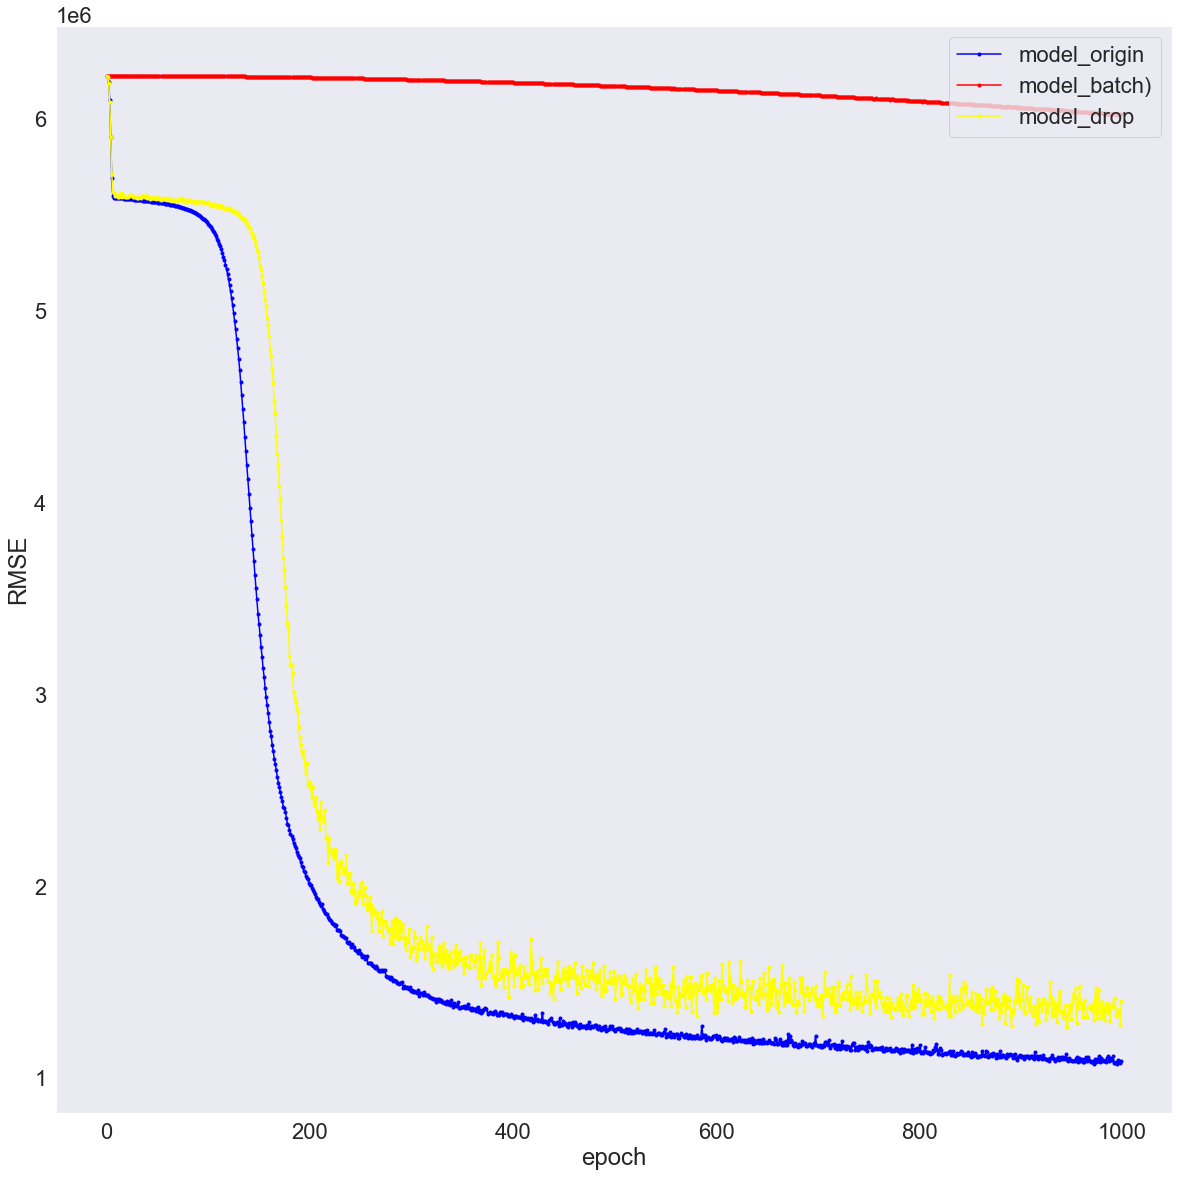

In [43]:
model1_rmse = np.sqrt(history_origin.history['loss'])
model2_rmse = np.sqrt(history_batch.history['loss'])
model3_rmse = np.sqrt(history_drop.history['loss'])


x_len = np.arange(len(model1_rmse))

plt.plot(x_len, model1_rmse, marker = '.', c='blue', label = 'model_origin')
plt.plot(x_len, model2_rmse, marker = '.', c='red', label = 'model_batch)')
plt.plot(x_len, model3_rmse, marker = '.', c='yellow', label = 'model_drop')

plt.legend(loc = 'upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('RMSE')
plt.show()

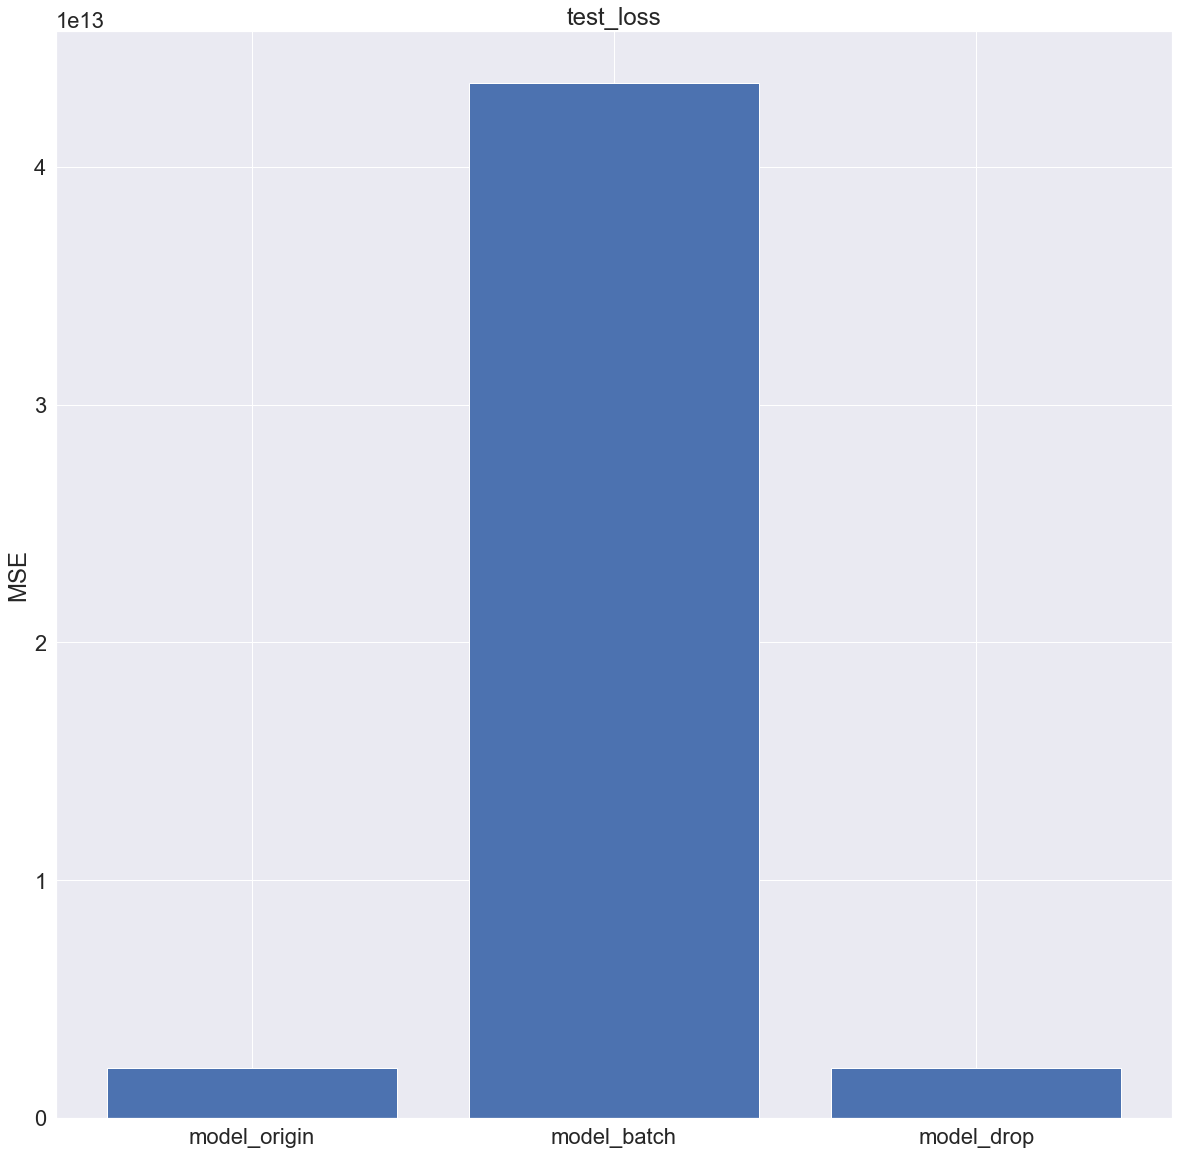

In [44]:
len_result = ['model_origin', 'model_batch','model_drop' ]
list_result= [result_test_origin[0], result_test_batch[0], result_test_drop[0]]

plt.title('test_loss')
plt.bar(len_result,list_result)

plt.xlabel('')
plt.ylabel('MSE')
plt.show()

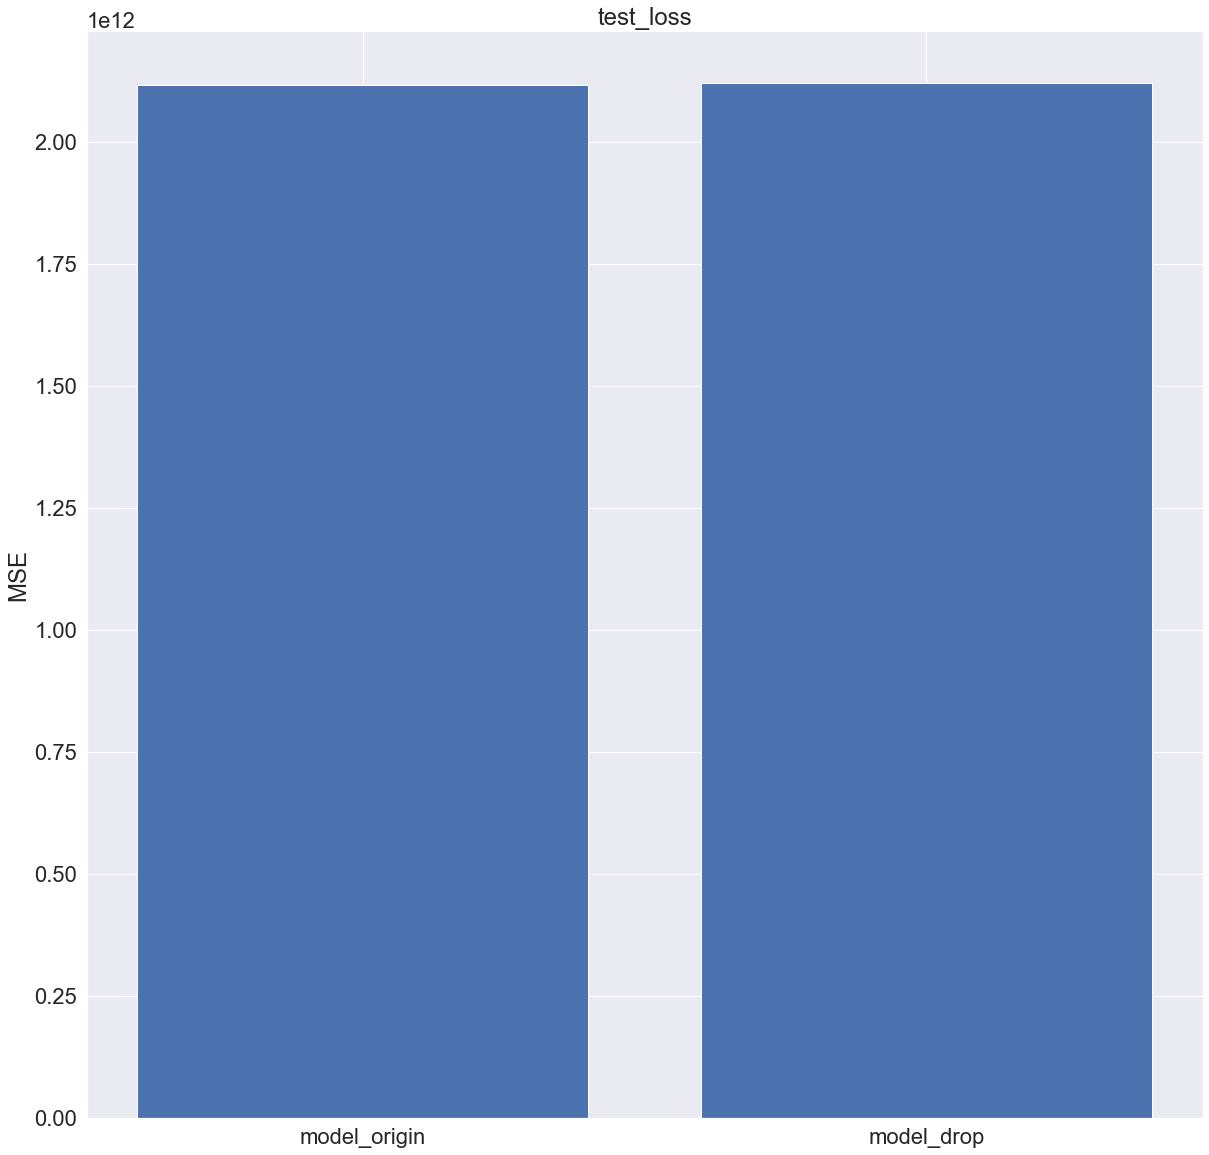

In [45]:
len_result = ['model_origin','model_drop' ]
list_result= [result_test_origin[0], result_test_drop[0]]

plt.title('test_loss')
plt.bar(len_result,list_result)

plt.xlabel('')
plt.ylabel('MSE')
plt.show()